In [7]:
#@title Setup
import sys
sys.path.insert(0, '/home/judah/icml/smart_buildings')

import os
import gin
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

from smart_buildings.smart_control.environment import environment, hybrid_action_environment
from smart_buildings.smart_control.proto import smart_control_building_pb2
from smart_buildings.smart_control.proto import smart_control_reward_pb2
from smart_buildings.smart_control.reward import setpoint_energy_carbon_regret
from smart_buildings.smart_control.reward import electricity_energy_cost
from smart_buildings.smart_control.reward import natural_gas_energy_cost
from smart_buildings.smart_control.simulator import base_convection_simulator
from smart_buildings.smart_control.simulator import building
from smart_buildings.smart_control.simulator import hvac
from smart_buildings.smart_control.simulator import hvac_floorplan_based
from smart_buildings.smart_control.simulator import stochastic_convection_simulator
from smart_buildings.smart_control.simulator import blend_convection_simulator
from smart_buildings.smart_control.simulator import tf_simulator
from smart_buildings.smart_control.simulator import randomized_arrival_departure_occupancy
from smart_buildings.smart_control.simulator import simulator_building
from smart_buildings.smart_control.utils import building_renderer
from smart_buildings.smart_control.utils import conversion_utils
from smart_buildings.smart_control.utils import real_building_temperature_array_generator as temp_array
from smart_buildings.smart_control.utils import environment_utils
from smart_buildings.smart_control.utils import observation_normalizer
from smart_buildings.smart_control.utils.floor_generator import BSPFloorPlan,MultiFloorPlan, assign_rooms_to_ahus, display_floor_plan

def plot_hvac_data_with_timestamps(data_tuples):
    """
    Parses and plots HVAC data from tuples, including explicit timestamps.

    Args:
        data_tuples: List of (temps, setpoints, outside_air, pd_timestamp)
                     temps: list of k floats
                     setpoints: list of [low, high]
                     outside_air: float scalar
                     pd_timestamp: pandas.Timestamp object
    """

    if not data_tuples:
        print("No data to plot.")
        return

    # 1. Parse Data
    # Initialize lists to hold the components
    timestamps = []
    oa_data = []
    sp_low_data = []
    sp_high_data = []

    # Check the consistency of 'k' (number of temperature sensors)
    k = len(data_tuples[0][0]) if data_tuples else 0
    if k == 0:
        print("Temps list is empty in the first tuple.")
        return

    # Pre-allocate list of lists for the 'k' temp sensors
    temp_traces = [[] for _ in range(k)]

    # Unpack the 4 elements from the tuple
    for t_list, sp_list, oa_val, timestamp in data_tuples:
        timestamps.append(timestamp)
        oa_data.append(oa_val)
        sp_low_data.append(sp_list[0])
        sp_high_data.append(sp_list[1])

        # Distribute the k temps into their respective trace lists
        for i in range(k):
            temp_traces[i].append(t_list[i])

    # Convert timestamps list to datetime objects for matplotlib
    mpl_timestamps = [ts.to_pydatetime() for ts in timestamps]

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot Setpoint Range (Green)
    ax.fill_between(mpl_timestamps, sp_low_data, sp_high_data,
                    color='green', alpha=0.3, label='Setpoint Range')

    # Plot Outside Air (Blue)
    ax.plot(mpl_timestamps, oa_data, color='blue', linewidth=2, label='Outside Air')

    # Plot Temps (Yellow)
    for i, trace in enumerate(temp_traces):
        label = 'Temps' if i == 0 else "_nolegend_" # Only label the first one
        # Use a slightly transparent color if k is large
        ax.plot(mpl_timestamps, trace, color='#FFD700', linewidth=1.5, alpha=0.7, label=label)

    ax.set_ylabel('Temperature (°C)')
    ax.set_xlabel('Time')
    ax.set_title(f'HVAC System Monitor ({k} Zone Sensors)')

    # Format X-axis to handle dates nicely
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    fig.autofmt_xdate()

    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()


def plot_hvac_data_with_reward(data_tuples, rewards):
    """
    Plots HVAC data and reward on two subplots.

    Args:
        data_tuples: List of (temps, setpoints, outside_air, pd_timestamp)
        rewards: List of reward values (floats)
    """
    if not data_tuples:
        print("No data to plot.")
        return

    # Parse temperature data
    timestamps = []
    oa_data = []
    sp_low_data = []
    sp_high_data = []

    k = len(data_tuples[0][0]) if data_tuples else 0
    if k == 0:
        print("Temps list is empty in the first tuple.")
        return

    temp_traces = [[] for _ in range(k)]

    for t_list, sp_list, oa_val, timestamp in data_tuples:
        timestamps.append(timestamp)
        oa_data.append(oa_val)
        sp_low_data.append(sp_list[0])
        sp_high_data.append(sp_list[1])
        for i in range(k):
            temp_traces[i].append(t_list[i])

    mpl_timestamps = [ts.to_pydatetime() for ts in timestamps]

    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True,
                                    gridspec_kw={'height_ratios': [2, 1]})

    # Top plot: Temperature data
    ax1.fill_between(mpl_timestamps, sp_low_data, sp_high_data,
                     color='green', alpha=0.3, label='Setpoint Range')
    ax1.plot(mpl_timestamps, oa_data, color='blue', linewidth=2, label='Outside Air')

    for i, trace in enumerate(temp_traces):
        label = 'Zone Temps' if i == 0 else "_nolegend_"
        ax1.plot(mpl_timestamps, trace, color='#FFD700', linewidth=1.5, alpha=0.7, label=label)

    ax1.set_ylabel('Temperature (K)')
    ax1.set_title(f'HVAC System Monitor ({k} Zone Sensors)')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend(loc='upper left')

    # Bottom plot: Reward
    ax2.plot(mpl_timestamps[:len(rewards)], rewards, color='purple', linewidth=2, label='Reward')
    ax2.fill_between(mpl_timestamps[:len(rewards)], rewards, alpha=0.3, color='purple')
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax2.set_ylabel('Reward')
    ax2.set_xlabel('Time')
    ax2.set_title('Episode Reward')
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend(loc='upper left')

    # Add cumulative reward annotation
    cumulative_reward = sum(rewards)
    ax2.annotate(f'Cumulative: {cumulative_reward:.2f}',
                 xy=(0.98, 0.95), xycoords='axes fraction',
                 ha='right', va='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    fig.autofmt_xdate()

    plt.tight_layout()
    plt.show()


def plot_hvac_data_with_reward_and_occupancy(data_tuples, rewards, occupancy_data):
    """
    Plots HVAC data, reward, and occupancy on three subplots.

    Args:
        data_tuples: List of (temps, setpoints, outside_air, pd_timestamp)
        rewards: List of reward values (floats)
        occupancy_data: List of total occupancy values (floats)
    """
    if not data_tuples:
        print("No data to plot.")
        return

    # Parse temperature data
    timestamps = []
    oa_data = []
    sp_low_data = []
    sp_high_data = []

    k = len(data_tuples[0][0]) if data_tuples else 0
    if k == 0:
        print("Temps list is empty in the first tuple.")
        return

    temp_traces = [[] for _ in range(k)]

    for t_list, sp_list, oa_val, timestamp in data_tuples:
        timestamps.append(timestamp)
        oa_data.append(oa_val)
        sp_low_data.append(sp_list[0])
        sp_high_data.append(sp_list[1])
        for i in range(k):
            temp_traces[i].append(t_list[i])

    mpl_timestamps = [ts.to_pydatetime() for ts in timestamps]

    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True,
                                         gridspec_kw={'height_ratios': [2, 1, 1]})

    # Top plot: Temperature data
    ax1.fill_between(mpl_timestamps, sp_low_data, sp_high_data,
                     color='green', alpha=0.3, label='Setpoint Range')
    ax1.plot(mpl_timestamps, oa_data, color='blue', linewidth=2, label='Outside Air')

    for i, trace in enumerate(temp_traces):
        label = 'Zone Temps' if i == 0 else "_nolegend_"
        ax1.plot(mpl_timestamps, trace, color='#FFD700', linewidth=1.5, alpha=0.7, label=label)

    ax1.set_ylabel('Temperature (K)')
    ax1.set_title(f'HVAC System Monitor ({k} Zone Sensors)')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend(loc='upper left')

    # Middle plot: Reward
    ax2.plot(mpl_timestamps[:len(rewards)], rewards, color='purple', linewidth=2, label='Reward')
    ax2.fill_between(mpl_timestamps[:len(rewards)], rewards, alpha=0.3, color='purple')
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax2.set_ylabel('Reward')
    ax2.set_title('Episode Reward')
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend(loc='upper left')

    cumulative_reward = sum(rewards)
    ax2.annotate(f'Cumulative: {cumulative_reward:.2f}',
                 xy=(0.98, 0.95), xycoords='axes fraction',
                 ha='right', va='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Bottom plot: Occupancy
    ax3.plot(mpl_timestamps[:len(occupancy_data)], occupancy_data, color='orange', linewidth=2, label='Total Occupancy')
    ax3.fill_between(mpl_timestamps[:len(occupancy_data)], occupancy_data, alpha=0.3, color='orange')
    ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax3.set_ylabel('Occupancy')
    ax3.set_xlabel('Time')
    ax3.set_title('Building Occupancy')
    ax3.grid(True, linestyle='--', alpha=0.6)
    ax3.legend(loc='upper left')

    avg_occupancy = sum(occupancy_data) / len(occupancy_data) if occupancy_data else 0
    ax3.annotate(f'Average: {avg_occupancy:.2f}',
                 xy=(0.98, 0.95), xycoords='axes fraction',
                 ha='right', va='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    fig.autofmt_xdate()

    plt.tight_layout()
    plt.show()

Grid unique values: [0 1 2]
Value counts: 0(floor)=174963, 1(wall)=4997, 2(door)=40
Generated h_shape building: 600x300
Floor plan shape: (310, 610)
Number of rooms: 24


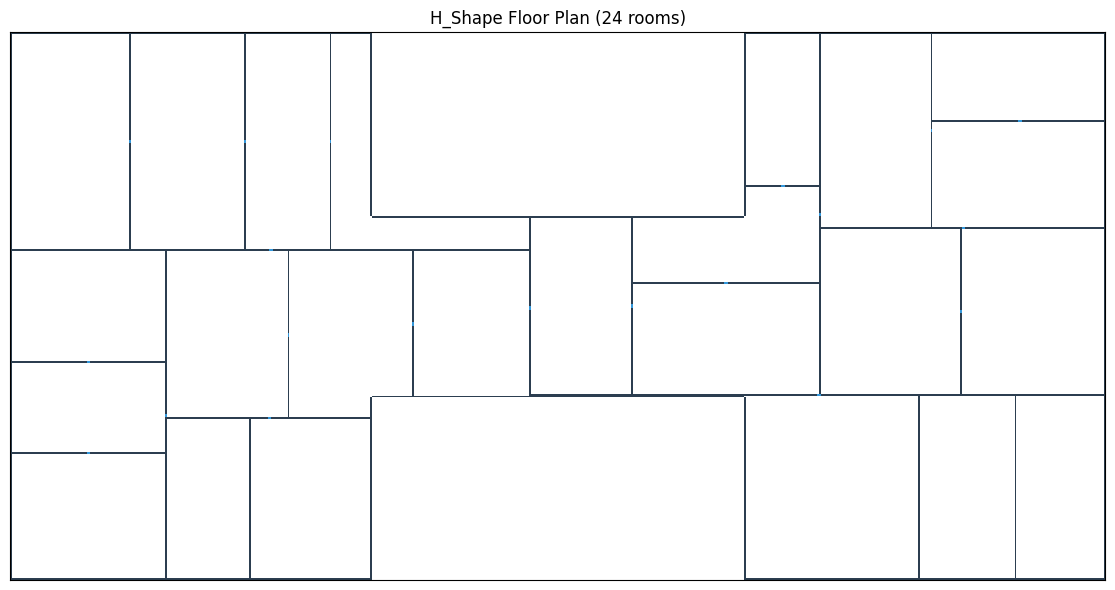

Floor plan saved to: /home/judah/icml/smart_buildings/generated_configs/generated_floor_plan.npy
Zone map saved to: /home/judah/icml/smart_buildings/generated_configs/generated_zone_map.npy
  AHU 1: 16 rooms
  AHU 2: 8 rooms


In [8]:
#@title Generate Floor Plan
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# @markdown ### Floor Plan Settings
width = 600  # @param {type:"integer"}
height = 300  # @param {type:"integer"}
min_room_size = 40  # @param {type:"integer"}
building_shape = "h_shape"  # @param ["rectangle", "trapezoid", "h_shape", "t_shape", "pentagon", "oval", "u_shape", "parallelogram", "semicircle", "triangle"]
num_ahus = 2  # @param {type:"integer"}

# Generate single floor plan
bsp = BSPFloorPlan(
    width=width,
    height=height,
    min_room_size=min_room_size,
    wall_thickness=1,
    building_shape=building_shape,
)
bsp.generate()

# Debug: check grid values
print(f"Grid unique values: {np.unique(bsp.grid)}")
print(f"Value counts: 0(floor)={np.sum(bsp.grid==0)}, 1(wall)={np.sum(bsp.grid==1)}, 2(door)={np.sum(bsp.grid==2)}")

# Export for simulator
floor_plan = bsp.export_for_simulator()
zone_map = bsp.export_zone_map()

# Save floor plan and zone map
output_dir = "/home/judah/icml/smart_buildings/generated_configs"
os.makedirs(output_dir, exist_ok=True)
floor_plan_path = os.path.join(output_dir, "generated_floor_plan.npy")
zone_map_path = os.path.join(output_dir, "generated_zone_map.npy")
np.save(floor_plan_path, floor_plan)
np.save(zone_map_path, zone_map)

# Count rooms and assign to AHUs
num_rooms = bsp.get_num_rooms()
ahu_assignments = assign_rooms_to_ahus(num_rooms, num_ahus, seed=42)

print(f"Generated {building_shape} building: {width}x{height}")
print(f"Floor plan shape: {floor_plan.shape}")
print(f"Number of rooms: {num_rooms}")

# Display with correct colors: 0=floor(white), 1=wall(dark), 2=door(blue)
fig, ax = plt.subplots(figsize=(12, 6))
cmap = ListedColormap(['#FFFFFF', '#2C3E50', '#3498DB'])
ax.imshow(bsp.grid, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
ax.set_title(f"{building_shape.title()} Floor Plan ({num_rooms} rooms)")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

print(f"Floor plan saved to: {floor_plan_path}")
print(f"Zone map saved to: {zone_map_path}")
for i, rooms in enumerate(ahu_assignments, 1):
    print(f"  AHU {i}: {len(rooms)} rooms")

In [9]:
#@title Generate Multi-Floor Plan
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# @markdown ### Floor Plan Settings
width = 600  # @param {type:"integer"}
height = 300  # @param {type:"integer"}
num_floors = 3  # @param {type:"integer"}
min_room_size = 40  # @param {type:"integer"}
building_shape = "composite"  # @param ["rectangle", "trapezoid", "h_shape", "t_shape", "pentagon", "oval", "u_shape", "parallelogram", "semicircle", "triangle"]
num_ahus = 5  # @param {type:"integer"}

# Generate multi-floor plan
multi = MultiFloorPlan(
    width=width,
    height=height,
    num_floors=num_floors,
    min_room_size=min_room_size,
    wall_thickness=1,
    building_shape=building_shape,
    composite_coverage=0.75,  # % minimum coverage
)
multi.generate()

# Debug: check grid values
print(f"Grid shape: {multi.grid.shape}")
print(f"Grid unique values: {np.unique(multi.grid)}")
print(f"Value counts: 0(floor)={np.sum(multi.grid==0)}, 1(wall)={np.sum(multi.grid==1)}, 2(door)={np.sum(multi.grid==2)}")

# Export for simulator
floor_plan = multi.export_for_simulator()
zone_map = multi.export_zone_map()

# Save floor plan and zone map
output_dir = "/home/judah/icml/smart_buildings/generated_configs"
os.makedirs(output_dir, exist_ok=True)
floor_plan_path = os.path.join(output_dir, "generated_floor_plan.npy")
zone_map_path = os.path.join(output_dir, "generated_zone_map.npy")
np.save(floor_plan_path, floor_plan)
np.save(zone_map_path, zone_map)

# Count rooms and assign to AHUs
num_rooms = multi.get_num_rooms()
ahu_assignments = assign_rooms_to_ahus(num_rooms, num_ahus, seed=42)

print(f"Generated {num_floors}-floor {building_shape} building: {width}x{height} per floor")
print(f"Floor plan shape: {floor_plan.shape}")
print(f"Number of rooms: {num_rooms}")

# Display with correct colors: 0=floor(white), 1=wall(dark), 2=door(blue)
# fig, ax = plt.subplots(figsize=(12, 12))
# cmap = ListedColormap(['#FFFFFF', '#2C3E50', '#3498DB'])
# ax.imshow(multi.grid, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
# ax.set_title(f"{num_floors}-Floor {building_shape.title()} Building ({num_rooms} rooms)")
# ax.set_xticks([])
# ax.set_yticks([])
# plt.tight_layout()
#plt.show()

print(f"Floor plan saved to: {floor_plan_path}")
print(f"Zone map saved to: {zone_map_path}")
for i, rooms in enumerate(ahu_assignments, 1):
    print(f"  AHU {i}: {len(rooms)} rooms")


Grid shape: (920, 600)
Grid unique values: [0 1 2]
Value counts: 0(floor)=534149, 1(wall)=17701, 2(door)=150
Generated 3-floor composite building: 600x300 per floor
Floor plan shape: (950, 610)
Number of rooms: 95
Floor plan saved to: /home/judah/icml/smart_buildings/generated_configs/generated_floor_plan.npy
Zone map saved to: /home/judah/icml/smart_buildings/generated_configs/generated_zone_map.npy
  AHU 1: 29 rooms
  AHU 2: 12 rooms
  AHU 3: 9 rooms
  AHU 4: 32 rooms
  AHU 5: 13 rooms


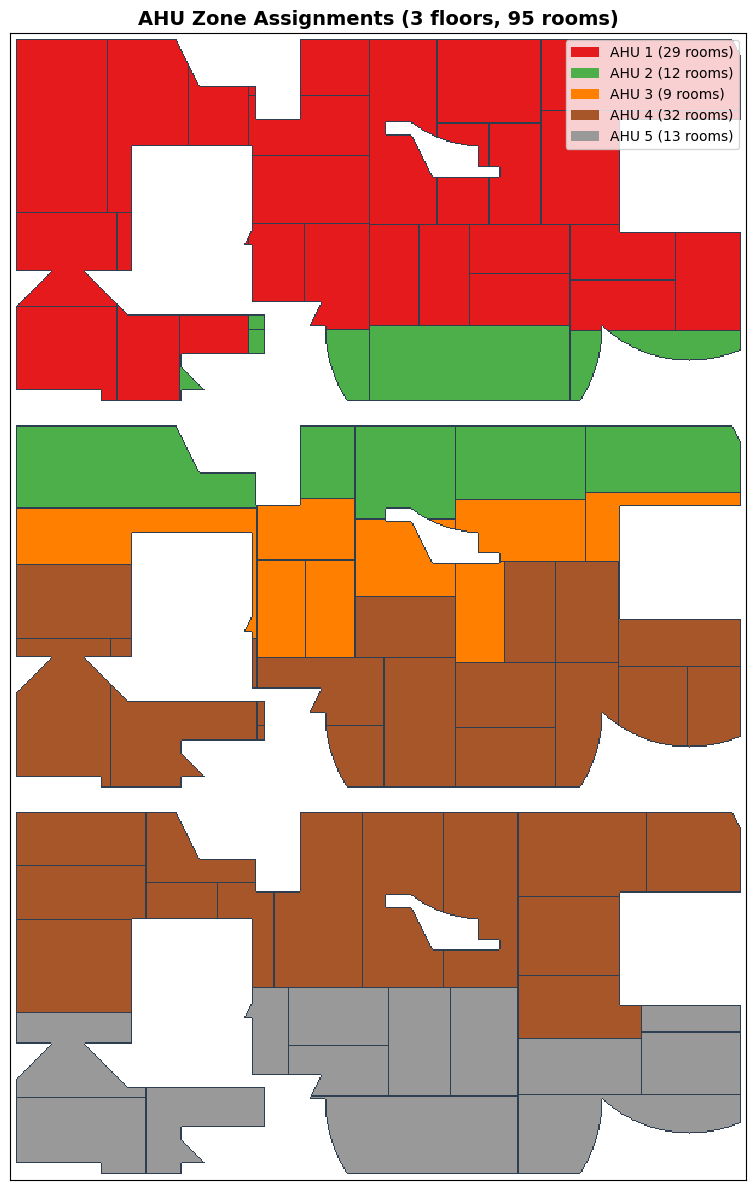

In [10]:
#@title Visualize AHU Zone Assignments
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Get zone map and label rooms
zone_map = multi.export_zone_map(padding=5)
binary = np.uint8(zone_map == 0)
num_labels, labels = cv2.connectedComponents(binary, connectivity=4)

# Map room numbers to AHU assignments
room_to_ahu = {}
for ahu_idx, rooms in enumerate(ahu_assignments):
    for room in rooms:
        room_num = int(room.split('_')[-1])
        room_to_ahu[room_num] = ahu_idx

# Create colored grid
colored = np.zeros_like(labels, dtype=np.int8)
colored[zone_map == 2] = 0  # exterior = white
colored[zone_map == 1] = 1  # walls = dark

for room_num, ahu_idx in room_to_ahu.items():
    colored[labels == room_num] = ahu_idx + 2

# Set up colors: white (exterior), dark (walls), then one color per AHU
ahu_colors = plt.cm.Set1(np.linspace(0, 1, max(num_ahus, 3)))[:num_ahus]
colors = ['#FFFFFF', '#2C3E50'] + [ahu_colors[i] for i in range(num_ahus)]
cmap = ListedColormap(colors)

# Plot
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(colored, cmap=cmap, interpolation='nearest', vmin=0, vmax=1+num_ahus)
ax.set_title(f"AHU Zone Assignments ({num_floors} floors, {num_rooms} rooms)", fontsize=14, fontweight='bold')
ax.set_xticks([])
ax.set_yticks([])

# Legend
legend_elements = [Patch(facecolor=colors[i+2], label=f'AHU {i+1} ({len(ahu_assignments[i])} rooms)')
                   for i in range(num_ahus)]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()


In [11]:
    #@title Config

def get_config(high_temp, low_temp, floor_plan_path, zone_map_path, ahu_assignments):
  # Generate room lists for each AHU from assignments
  ahu_room_lists = ""
  for i, rooms in enumerate(ahu_assignments, 1):
    room_strs = ", ".join([f"'{r}'" for r in rooms])
    ahu_room_lists += f"    ahu_{i}_rooms = [{room_strs}]\n"

  # Generate AHU definitions
  ahu_defs = ""
  for i in range(1, len(ahu_assignments) + 1):
    ahu_defs += f"""
    ahu_{i}/AirHandler:
      recirculation = %air_handler_recirculation_ratio
      heating_air_temp_setpoint = %air_handler_heating_setpoint
      cooling_air_temp_setpoint = %air_handler_cooling_setpoint
      fan_static_pressure = %fan_static_pressure
      fan_efficiency = %fan_efficiency
      max_air_flow_rate = 50#8.67
      sim_weather_controller = %weather_controller
      device_id = 'ahu_{i}'
"""

  # Generate AHU mappings for AirHandlerSystem
  ahu_mappings = ",\n        ".join([f"@ahu_{i}/AirHandler(): %ahu_{i}_rooms" for i in range(1, len(ahu_assignments) + 1)])

  # Generate action normalizer entries for each AHU
  ahu_action_normalizers = ""
  for i in range(1, len(ahu_assignments) + 1):
    ahu_action_normalizers += f"""        'ahu_{i}_supply_air_temperature_setpoint': @supply_air_temperature_setpoint/set_action_normalization_constants(),
        'ahu_{i}_static_pressure_setpoint': @static_pressure_setpoint/set_action_normalization_constants(),
        'ahu_{i}_supervisor_run_command': @run_command/set_action_normalization_constants(),
"""

  # Generate default actions for each AHU
  ahu_default_actions = ""
  for i in range(1, len(ahu_assignments) + 1):
    ahu_default_actions += f"""        'ahu_ahu_{i}_supply_air_temperature_setpoint': 293.0,
        'ahu_ahu_{i}_static_pressure_setpoint': 20000.0,
        'ahu_ahu_{i}_supervisor_run_command': 1.0,
"""

  # Generate device_action_tuples for each AHU
  ahu_device_tuples = ""
  for i in range(1, len(ahu_assignments) + 1):
    ahu_device_tuples += f"        ('ahu', 'ahu_{i}_supervisor_run_command'),\n"
  for i in range(1, len(ahu_assignments) + 1):
    ahu_device_tuples += f"""        ('ahu', 'ahu_{i}_supply_air_temperature_setpoint'),
        ('ahu', 'ahu_{i}_static_pressure_setpoint'),
"""

  gin_config_contents=f"""
    ########a#######################################################
    # Low occupancy, constant setpoint
    ###############################################################

    ##########################
    ### WEATHER CONTROLLER
    ##########################

    # ORIGINAL:
    convection_coefficient = 1#100.0
    ambient_high_temp = {high_temp}#280#305 # K
    ambient_low_temp =  {low_temp}#280#305 # K

    sim/WeatherController:
      default_low_temp = %ambient_low_temp
      default_high_temp = %ambient_high_temp
      convection_coefficient = %convection_coefficient

    weather_controller = @sim/WeatherController()




    ##########################
    ### BUILDING
    ##########################

    initial_temp = 294.0
    control_volume_cm = 10 #20
    floor_height_cm = 300.0

    floor_plan_filepath = "{floor_plan_path}"
    zone_map_filepath = "{zone_map_path}"

    exterior_cv_conductivity = 0.05#5.5 #0.05 # Biggest cause of divergence
    exterior_cv_density = 1.0
    exterior_cv_heat_capacity = 700.0

    interior_wall_cv_conductivity = 50.0
    interior_wall_cv_density = 1.0
    interior_wall_cv_heat_capacity = 700.0

    interior_cv_conductivity =  200.0
    interior_cv_density = 0.1#1.0
    interior_cv_heat_capacity = 200

    inside_air_properties/MaterialProperties:
      conductivity = %interior_cv_conductivity
      heat_capacity = %interior_cv_heat_capacity
      density = %interior_cv_density

    inside_wall_properties/MaterialProperties:
      conductivity = %interior_wall_cv_conductivity
      heat_capacity = %interior_wall_cv_heat_capacity
      density = %interior_wall_cv_density

    building_exterior_properties/MaterialProperties:
      conductivity = %exterior_cv_conductivity
      heat_capacity = %exterior_cv_heat_capacity
      density = %exterior_cv_density

    sim/FloorPlanBasedBuilding:
      cv_size_cm = %control_volume_cm
      floor_height_cm = %floor_height_cm
      initial_temp  = %initial_temp
      inside_air_properties = @inside_air_properties/MaterialProperties()
      inside_wall_properties = @inside_wall_properties/MaterialProperties()
      building_exterior_properties = @building_exterior_properties/MaterialProperties()
      floor_plan_filepath = %floor_plan_filepath
      zone_map_filepath = %zone_map_filepath
      #save_debugging_images = False
      #convection_simulator = @StochasticConvectionSimulator()
      convection_simulator = @BlendConvectionSimulator()



    ##########################
    ### SCHEDULE ...
    ### https://source.corp.google.com/piper///depot/google3/corp/ml/smart_buildings/smart_control/configs/real_building/us_mtv_1055/base_config.gin;l=7?q=%23%20HVAC%20heating%2Fcooling%20schedule&ct=os&sq=package:piper%20file:%2F%2Fdepot%2Fgoogle3%20-file:google3%2Fexperimental
    ##########################

    morning_start_hour =  6
    evening_start_hour = 19
    heating_setpoint_day = 294
    cooling_setpoint_day = 297
    heating_setpoint_night = 289
    cooling_setpoint_night = 298
    time_zone="US/Pacific"

    hvac/SetpointSchedule:
      morning_start_hour = %morning_start_hour
      evening_start_hour = %evening_start_hour
      comfort_temp_window = (%heating_setpoint_day, %cooling_setpoint_day)
      eco_temp_window = (%heating_setpoint_night, %cooling_setpoint_night)
      time_zone = %time_zone



    ##########################
    ### HVAC
    ##########################

    water_pump_differential_head =  6.0
    water_pump_efficiency = 0.98
    reheat_water_setpoint = 360.0
    boiler_heating_rate = 0.5 # K / min
    boiler_cooling_rate = 0.1 # K / min

    fan_static_pressure = 10000.0
    fan_efficiency = 0.9

    air_handler_heating_setpoint = 285.0
    air_handler_cooling_setpoint = 298.0
    air_handler_recirculation_ratio = 0.3

    vav_max_air_flowrate = 20.0#0.035
    vav_reheat_water_flowrate =  0.3#0.03

{ahu_room_lists}
{ahu_defs}

    hvac/AirHandlerSystem:
      ahus =  {{
        {ahu_mappings},
      }}
      device_id = 'ahu'

    hvac/WaterPump:
      water_pump_differential_head = %water_pump_differential_head
      water_pump_efficiency = %water_pump_efficiency

    hvac/Boiler:
      reheat_water_setpoint = %reheat_water_setpoint
      heating_rate = %boiler_heating_rate
      cooling_rate = %boiler_cooling_rate

    hvac/HotWaterSystem:
      pump = @hvac/WaterPump()
      boiler = @hvac/Boiler()
      device_id = 'hws'


    sim/FloorPlanBasedHvac:
      air_handler = @hvac/AirHandlerSystem()
      hot_water_system = @hvac/HotWaterSystem()
      schedule = @hvac/SetpointSchedule()
      vav_max_air_flow_rate = %vav_max_air_flowrate
      vav_reheat_max_water_flow_factor = %vav_reheat_water_flowrate


    ##########################
    ### SIMULATOR
    ##########################
    # shuffle parameters
    StochasticConvectionSimulator.p = 1.0
    StochasticConvectionSimulator.distance = -1
    StochasticConvectionSimulator.seed = 5

    BlendConvectionSimulator.alpha = 0.5


    # Finite difference settings.
    time_step_sec =  300
    convergence_threshold = 0.01
    iteration_limit = 100
    iteration_warning = 20
    start_timestamp = '2023-07-10 19:00' # '2021-04-01 00:00'

    sim/to_timestamp.date_str = %start_timestamp

    #sim_building/SimulatorFlexibleGeometries:
    sim_building/TFSimulator:
      building = @sim/FloorPlanBasedBuilding()
      hvac  = @sim/FloorPlanBasedHvac()
      weather_controller = %weather_controller
      time_step_sec = %time_step_sec
      convergence_threshold = %convergence_threshold
      iteration_limit = %iteration_limit
      iteration_warning = %iteration_warning
      start_timestamp = @sim/to_timestamp()


    work_occupancy = 1
    nonwork_occupancy = 0.1
    # occupancy_start_time = '07:00:00'
    # occupancy_end_time = '17:00:00'
    occupancy_start/local_time.time_str =  %occupancy_start_time
    occupancy_end/local_time.time_str = %occupancy_end_time


    randomized_occupancy/RandomizedArrivalDepartureOccupancy:
      zone_assignment = %work_occupancy
      earliest_expected_arrival_hour = 3
      latest_expected_arrival_hour = 12
      earliest_expected_departure_hour = 13
      latest_expected_departure_hour = 23
      time_step_sec = %time_step_sec
      min_occupancy = %nonwork_occupancy

    #SimulatorBuilding.simulator = @sim_building/SimulatorFlexibleGeometries()
    SimulatorBuilding.simulator = @sim_building/TFSimulator()
    # SimulatorBuilding.occupancy = @step_function_occupancy/StepFunctionOccupancy()
    SimulatorBuilding.occupancy = @randomized_occupancy/RandomizedArrivalDepartureOccupancy()


    ##########################
    ### REWARDS
    ##########################

    productivity_personhour_usd = 300.00

    productivity_midpoint_delta_temp =  1.5
    decay_stiffness =  4.3

    electricity_weight =  1.0
    carbon_weight =  1.0

    reward_normalizer_shift = 0.0
    reward_normalizer_scale = 450.0

    max_productivity_personhour_usd = 300.00
    min_productivity_personhour_usd = 100.00
    productivity_midpoint_delta =  0.5
    productivity_decay_stiffness =  4.3

    max_electricity_rate=5000000
    max_natural_gas_rate=400000

    productivity_weight=0.2
    energy_cost_weight=0.4
    carbon_emission_weight=0.4

    SetpointEnergyCarbonRegretFunction.max_productivity_personhour_usd = %max_productivity_personhour_usd
    SetpointEnergyCarbonRegretFunction.min_productivity_personhour_usd = %min_productivity_personhour_usd
    SetpointEnergyCarbonRegretFunction.max_electricity_rate = %max_electricity_rate
    SetpointEnergyCarbonRegretFunction.max_natural_gas_rate = %max_natural_gas_rate
    SetpointEnergyCarbonRegretFunction.productivity_decay_stiffness = %productivity_decay_stiffness
    SetpointEnergyCarbonRegretFunction.productivity_midpoint_delta = %productivity_midpoint_delta
    SetpointEnergyCarbonRegretFunction.electricity_energy_cost = @ElectricityEnergyCost()
    SetpointEnergyCarbonRegretFunction.natural_gas_energy_cost = @NaturalGasEnergyCost()
    SetpointEnergyCarbonRegretFunction.productivity_weight = %productivity_weight
    SetpointEnergyCarbonRegretFunction.energy_cost_weight= %energy_cost_weight
    SetpointEnergyCarbonRegretFunction.carbon_emission_weight = %carbon_emission_weight


    ##########################
    ### ACTIONS
    ##########################

    # Action Normalization Parameters -> edited to match real building: https://source.corp.google.com/piper///depot/google3/corp/ml/smart_buildings/smart_control/configs/real_building/us_mtv_1055/base_config.gin;rcl=520286766;l=89
    supply_water_bounded_action_normalizer/set_action_normalization_constants.min_normalized_value = -1.
    supply_water_bounded_action_normalizer/set_action_normalization_constants.max_normalized_value = 1.0
    supply_water_bounded_action_normalizer/set_action_normalization_constants.min_native_value = 310 #300.0
    supply_water_bounded_action_normalizer/set_action_normalization_constants.max_native_value = 350.0

    supply_air_heating_temperature_setpoint/set_action_normalization_constants.min_normalized_value = -1.
    supply_air_heating_temperature_setpoint/set_action_normalization_constants.max_normalized_value = 1.
    supply_air_heating_temperature_setpoint/set_action_normalization_constants.min_native_value = 285 #275.0
    supply_air_heating_temperature_setpoint/set_action_normalization_constants.max_native_value = 295.0

    supply_air_temperature_setpoint/set_action_normalization_constants.min_normalized_value = -1.
    supply_air_temperature_setpoint/set_action_normalization_constants.max_normalized_value = 1.
    supply_air_temperature_setpoint/set_action_normalization_constants.min_native_value = 285 #275.0
    supply_air_temperature_setpoint/set_action_normalization_constants.max_native_value = 305.0

    differential_pressure_setpoint/set_action_normalization_constants.min_normalized_value = -1.
    differential_pressure_setpoint/set_action_normalization_constants.max_normalized_value = 1.
    differential_pressure_setpoint/set_action_normalization_constants.min_native_value = 0 #275.0
    differential_pressure_setpoint/set_action_normalization_constants.max_native_value = 20.0

    static_pressure_setpoint/set_action_normalization_constants.min_normalized_value = -1.
    static_pressure_setpoint/set_action_normalization_constants.max_normalized_value = 1.
    static_pressure_setpoint/set_action_normalization_constants.min_native_value = 0 #275.0
    static_pressure_setpoint/set_action_normalization_constants.max_native_value = 20000.0

    run_command/set_action_normalization_constants.min_normalized_value = -1.
    run_command/set_action_normalization_constants.max_normalized_value = 1.
    run_command/set_action_normalization_constants.min_native_value = 0.0
    run_command/set_action_normalization_constants.max_native_value = 1.0

    # Keys must match setpoint_name in device_action_tuples
    action_normalizer_map = {{
        'supply_water_setpoint': @supply_water_bounded_action_normalizer/set_action_normalization_constants(),
        'differential_pressure': @differential_pressure_setpoint/set_action_normalization_constants(),
{ahu_action_normalizers}        'supervisor_run_command': @run_command/set_action_normalization_constants(),
    }}
    ActionConfig:
        action_normalizers = %action_normalizer_map

    # Keys must match field_id = device_id + '_' + setpoint_name
    default_actions = {{
        'hws_supply_water_setpoint': 340.0,
        'hws_differential_pressure': 20.0,
{ahu_default_actions}        'hws_supervisor_run_command': 1.0,
    }}


    ##########################
    ### OBSERVATIONS
    ##########################

    temperature_observation_normalizer/set_observation_normalization_constants.field_id = 'temperature'
    temperature_observation_normalizer/set_observation_normalization_constants.sample_mean =  310.0
    temperature_observation_normalizer/set_observation_normalization_constants.sample_variance =  2500.0

    supply_water_setpoint_observation_normalizer/set_observation_normalization_constants.field_id = 'supply_water_setpoint'
    supply_water_setpoint_observation_normalizer/set_observation_normalization_constants.sample_mean =  310.0
    supply_water_setpoint_observation_normalizer/set_observation_normalization_constants.sample_variance =  2500.0

    air_flowrate_observation_normalizer/set_observation_normalization_constants.field_id = 'air_flowrate'
    air_flowrate_observation_normalizer/set_observation_normalization_constants.sample_mean =  0.5
    air_flowrate_observation_normalizer/set_observation_normalization_constants.sample_variance =  4.0

    differential_pressure_observation_normalizer/set_observation_normalization_constants.field_id = 'differential_pressure'
    differential_pressure_observation_normalizer/set_observation_normalization_constants.sample_mean =  10000.0
    differential_pressure_observation_normalizer/set_observation_normalization_constants.sample_variance =  100000.0

    percentage_observation_normalizer/set_observation_normalization_constants.field_id = 'percentage'
    percentage_observation_normalizer/set_observation_normalization_constants.sample_mean =  0.50
    percentage_observation_normalizer/set_observation_normalization_constants.sample_variance =  1.0

    request_count_observation_normalizer/set_observation_normalization_constants.field_id = 'request_count'
    request_count_observation_normalizer/set_observation_normalization_constants.sample_mean =  100.0
    request_count_observation_normalizer/set_observation_normalization_constants.sample_variance =  25.0

    # measurement 0 building_air_static_pressure_sensor
    building_air_static_pressure_sensor_normalizer/set_observation_normalization_constants.field_id = 'building_air_static_pressure_sensor'
    building_air_static_pressure_sensor_normalizer/set_observation_normalization_constants.sample_mean = 3.779228
    building_air_static_pressure_sensor_normalizer/set_observation_normalization_constants.sample_variance = 14.599437

    # measurement 1 building_air_static_pressure_setpoint
    building_air_static_pressure_setpoint_normalizer/set_observation_normalization_constants.field_id = 'building_air_static_pressure_setpoint'
    building_air_static_pressure_setpoint_normalizer/set_observation_normalization_constants.sample_mean = 7.472401
    building_air_static_pressure_setpoint_normalizer/set_observation_normalization_constants.sample_variance = 0.000000

    # measurement 2 cooling_percentage_command
    cooling_percentage_command_normalizer/set_observation_normalization_constants.field_id = 'cooling_percentage_command'
    cooling_percentage_command_normalizer/set_observation_normalization_constants.sample_mean = 9.658281
    cooling_percentage_command_normalizer/set_observation_normalization_constants.sample_variance = 295.833612

    # measurement 3 differential_pressure_sensor
    differential_pressure_sensor_normalizer/set_observation_normalization_constants.field_id = 'differential_pressure_sensor'
    differential_pressure_sensor_normalizer/set_observation_normalization_constants.sample_mean = 31611.814379
    differential_pressure_sensor_normalizer/set_observation_normalization_constants.sample_variance = 1844378631.487996

    # measurement 4 differential_pressure_setpoint
    differential_pressure_setpoint_normalizer/set_observation_normalization_constants.field_id = 'differential_pressure_setpoint'
    differential_pressure_setpoint_normalizer/set_observation_normalization_constants.sample_mean = 83810.269540
    differential_pressure_setpoint_normalizer/set_observation_normalization_constants.sample_variance = 14889040.603647

    # measurement 5 discharge_air_temperature_sensor
    discharge_air_temperature_sensor_normalizer/set_observation_normalization_constants.field_id = 'discharge_air_temperature_sensor'
    discharge_air_temperature_sensor_normalizer/set_observation_normalization_constants.sample_mean = 69.889025
    discharge_air_temperature_sensor_normalizer/set_observation_normalization_constants.sample_variance = 541.455462

    # measurement 6 discharge_air_temperature_setpoint
    discharge_air_temperature_setpoint_normalizer/set_observation_normalization_constants.field_id = 'discharge_air_temperature_setpoint'
    discharge_air_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_mean = 57.665244
    discharge_air_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_variance = 97.254479

    # measurement 7 exhaust_air_damper_percentage_command
    exhaust_air_damper_percentage_command_normalizer/set_observation_normalization_constants.field_id = 'exhaust_air_damper_percentage_command'
    exhaust_air_damper_percentage_command_normalizer/set_observation_normalization_constants.sample_mean = 25.000000
    exhaust_air_damper_percentage_command_normalizer/set_observation_normalization_constants.sample_variance = 0.000000

    # measurement 8 exhaust_air_damper_percentage_sensor
    exhaust_air_damper_percentage_sensor_normalizer/set_observation_normalization_constants.field_id = 'exhaust_air_damper_percentage_sensor'
    exhaust_air_damper_percentage_sensor_normalizer/set_observation_normalization_constants.sample_mean = 10.680755
    exhaust_air_damper_percentage_sensor_normalizer/set_observation_normalization_constants.sample_variance = 539.207818

    # measurement 9 exhaust_fan_speed_frequency_sensor
    exhaust_fan_speed_frequency_sensor_normalizer/set_observation_normalization_constants.field_id = 'exhaust_fan_speed_frequency_sensor'
    exhaust_fan_speed_frequency_sensor_normalizer/set_observation_normalization_constants.sample_mean = 4.273057
    exhaust_fan_speed_frequency_sensor_normalizer/set_observation_normalization_constants.sample_variance = 138.559759

    # measurement 10 exhaust_fan_speed_percentage_command
    exhaust_fan_speed_percentage_command_normalizer/set_observation_normalization_constants.field_id = 'exhaust_fan_speed_percentage_command'
    exhaust_fan_speed_percentage_command_normalizer/set_observation_normalization_constants.sample_mean = 7.121761
    exhaust_fan_speed_percentage_command_normalizer/set_observation_normalization_constants.sample_variance = 384.888218

    # measurement 11 heating_water_valve_percentage_command
    heating_water_valve_percentage_command_normalizer/set_observation_normalization_constants.field_id = 'heating_water_valve_percentage_command'
    heating_water_valve_percentage_command_normalizer/set_observation_normalization_constants.sample_mean = 3.105189
    heating_water_valve_percentage_command_normalizer/set_observation_normalization_constants.sample_variance = 202.006249

    # measurement 12 mixed_air_temperature_sensor
    mixed_air_temperature_sensor_normalizer/set_observation_normalization_constants.field_id = 'mixed_air_temperature_sensor'
    mixed_air_temperature_sensor_normalizer/set_observation_normalization_constants.sample_mean = 293.718710
    mixed_air_temperature_sensor_normalizer/set_observation_normalization_constants.sample_variance = 12.517696

    # measurement 13 mixed_air_temperature_setpoint
    mixed_air_temperature_setpoint_normalizer/set_observation_normalization_constants.field_id = 'mixed_air_temperature_setpoint'
    mixed_air_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_mean = 288.218302
    mixed_air_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_variance = 3.186768

    # measurement 14 outside_air_damper_percentage_command
    outside_air_damper_percentage_command_normalizer/set_observation_normalization_constants.field_id = 'outside_air_damper_percentage_command'
    outside_air_damper_percentage_command_normalizer/set_observation_normalization_constants.sample_mean = 34.504101
    outside_air_damper_percentage_command_normalizer/set_observation_normalization_constants.sample_variance = 2053.149002

    # measurement 15 outside_air_dewpoint_temperature_sensor
    outside_air_dewpoint_temperature_sensor_normalizer/set_observation_normalization_constants.field_id = 'outside_air_dewpoint_temperature_sensor'
    outside_air_dewpoint_temperature_sensor_normalizer/set_observation_normalization_constants.sample_mean = 285.774428
    outside_air_dewpoint_temperature_sensor_normalizer/set_observation_normalization_constants.sample_variance = 2.504610

    # measurement 16 outside_air_flowrate_sensor
    outside_air_flowrate_sensor_normalizer/set_observation_normalization_constants.field_id = 'outside_air_flowrate_sensor'
    outside_air_flowrate_sensor_normalizer/set_observation_normalization_constants.sample_mean = 3.701930
    outside_air_flowrate_sensor_normalizer/set_observation_normalization_constants.sample_variance = 20.300565

    # measurement 17 outside_air_flowrate_setpoint
    outside_air_flowrate_setpoint_normalizer/set_observation_normalization_constants.field_id = 'outside_air_flowrate_setpoint'
    outside_air_flowrate_setpoint_normalizer/set_observation_normalization_constants.sample_mean = 8.730134
    outside_air_flowrate_setpoint_normalizer/set_observation_normalization_constants.sample_variance = 0.240364

    # measurement 18 outside_air_relative_humidity_sensor
    outside_air_relative_humidity_sensor_normalizer/set_observation_normalization_constants.field_id = 'outside_air_relative_humidity_sensor'
    outside_air_relative_humidity_sensor_normalizer/set_observation_normalization_constants.sample_mean = 71.799372
    outside_air_relative_humidity_sensor_normalizer/set_observation_normalization_constants.sample_variance = 172.388773

    # measurement 19 outside_air_specificenthalpy_sensor
    outside_air_specificenthalpy_sensor_normalizer/set_observation_normalization_constants.field_id = 'outside_air_specificenthalpy_sensor'
    outside_air_specificenthalpy_sensor_normalizer/set_observation_normalization_constants.sample_mean = 60711.656343
    outside_air_specificenthalpy_sensor_normalizer/set_observation_normalization_constants.sample_variance = 25491060.173822

    # measurement 20 outside_air_temperature_sensor
    outside_air_temperature_sensor_normalizer/set_observation_normalization_constants.field_id = 'outside_air_temperature_sensor'
    outside_air_temperature_sensor_normalizer/set_observation_normalization_constants.sample_mean = 291.244931
    outside_air_temperature_sensor_normalizer/set_observation_normalization_constants.sample_variance = 12.904175

    # measurement 21 outside_air_wetbulb_temperature_sensor
    outside_air_wetbulb_temperature_sensor_normalizer/set_observation_normalization_constants.field_id = 'outside_air_wetbulb_temperature_sensor'
    outside_air_wetbulb_temperature_sensor_normalizer/set_observation_normalization_constants.sample_mean = 287.709943
    outside_air_wetbulb_temperature_sensor_normalizer/set_observation_normalization_constants.sample_variance = 3.594260

    # measurement 22 program_differential_pressure_setpoint
    program_differential_pressure_setpoint_normalizer/set_observation_normalization_constants.field_id = 'program_differential_pressure_setpoint'
    program_differential_pressure_setpoint_normalizer/set_observation_normalization_constants.sample_mean = 83808.578375
    program_differential_pressure_setpoint_normalizer/set_observation_normalization_constants.sample_variance = 14897544.664858

    # measurement 23 program_supply_air_static_pressure_setpoint
    program_supply_air_static_pressure_setpoint_normalizer/set_observation_normalization_constants.field_id = 'program_supply_air_static_pressure_setpoint'
    program_supply_air_static_pressure_setpoint_normalizer/set_observation_normalization_constants.sample_mean = 163.396282
    program_supply_air_static_pressure_setpoint_normalizer/set_observation_normalization_constants.sample_variance = 1092.073231

    # measurement 24 program_supply_air_temperature_setpoint
    program_supply_air_temperature_setpoint_normalizer/set_observation_normalization_constants.field_id = 'program_supply_air_temperature_setpoint'
    program_supply_air_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_mean = 289.490004
    program_supply_air_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_variance = 2.854515

    # measurement 25 program_supply_water_temperature_setpoint
    program_supply_water_temperature_setpoint_normalizer/set_observation_normalization_constants.field_id = 'program_supply_water_temperature_setpoint'
    program_supply_water_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_mean = 341.467705
    program_supply_water_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_variance = 74.961483

    # measurement 26 return_air_temperature_sensor
    return_air_temperature_sensor_normalizer/set_observation_normalization_constants.field_id = 'return_air_temperature_sensor'
    return_air_temperature_sensor_normalizer/set_observation_normalization_constants.sample_mean = 295.602164
    return_air_temperature_sensor_normalizer/set_observation_normalization_constants.sample_variance = 11.309930

    # measurement 27 return_water_temperature_sensor
    return_water_temperature_sensor_normalizer/set_observation_normalization_constants.field_id = 'return_water_temperature_sensor'
    return_water_temperature_sensor_normalizer/set_observation_normalization_constants.sample_mean = 326.219913
    return_water_temperature_sensor_normalizer/set_observation_normalization_constants.sample_variance = 497.847788

    # measurement 28 run_status
    run_status_normalizer/set_observation_normalization_constants.field_id = 'run_status'
    run_status_normalizer/set_observation_normalization_constants.sample_mean = -0.638340
    run_status_normalizer/set_observation_normalization_constants.sample_variance = 0.592523

    # measurement 29 speed_frequency_sensor
    speed_frequency_sensor_normalizer/set_observation_normalization_constants.field_id = 'speed_frequency_sensor'
    speed_frequency_sensor_normalizer/set_observation_normalization_constants.sample_mean = 7.003487
    speed_frequency_sensor_normalizer/set_observation_normalization_constants.sample_variance = 227.751249

    # measurement 30 speed_percentage_command
    speed_percentage_command_normalizer/set_observation_normalization_constants.field_id = 'speed_percentage_command'
    speed_percentage_command_normalizer/set_observation_normalization_constants.sample_mean = 11.330966
    speed_percentage_command_normalizer/set_observation_normalization_constants.sample_variance = 602.718159

    # measurement 31 supervisor_supply_air_static_pressure_setpoint
    supervisor_supply_air_static_pressure_setpoint_normalizer/set_observation_normalization_constants.field_id = 'supervisor_supply_air_static_pressure_setpoint'
    supervisor_supply_air_static_pressure_setpoint_normalizer/set_observation_normalization_constants.sample_mean = 179.409052
    supervisor_supply_air_static_pressure_setpoint_normalizer/set_observation_normalization_constants.sample_variance = 352.049768

    # measurement 32 supervisor_supply_air_temperature_setpoint
    supervisor_supply_air_temperature_setpoint_normalizer/set_observation_normalization_constants.field_id = 'supervisor_supply_air_temperature_setpoint'
    supervisor_supply_air_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_mean = 290.2
    supervisor_supply_air_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_variance = 9.66245

    # measurement 33 supervisor_supply_water_temperature_setpoint
    supervisor_supply_water_temperature_setpoint_normalizer/set_observation_normalization_constants.field_id = 'supervisor_supply_water_temperature_setpoint'
    supervisor_supply_water_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_mean = 332.164444
    supervisor_supply_water_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_variance = 1.534112

    # measurement 34 supply_air_damper_percentage_command
    supply_air_damper_percentage_command_normalizer/set_observation_normalization_constants.field_id = 'supply_air_damper_percentage_command'
    supply_air_damper_percentage_command_normalizer/set_observation_normalization_constants.sample_mean = 51.173986
    supply_air_damper_percentage_command_normalizer/set_observation_normalization_constants.sample_variance = 1059.265742

    # measurement 35 supply_air_flowrate_sensor
    supply_air_flowrate_sensor_normalizer/set_observation_normalization_constants.field_id = 'supply_air_flowrate_sensor'
    supply_air_flowrate_sensor_normalizer/set_observation_normalization_constants.sample_mean = 177.520026
    supply_air_flowrate_sensor_normalizer/set_observation_normalization_constants.sample_variance = 50499.153481

    # measurement 36 supply_air_flowrate_setpoint
    supply_air_flowrate_setpoint_normalizer/set_observation_normalization_constants.field_id = 'supply_air_flowrate_setpoint'
    supply_air_flowrate_setpoint_normalizer/set_observation_normalization_constants.sample_mean = 209.557558
    supply_air_flowrate_setpoint_normalizer/set_observation_normalization_constants.sample_variance = 47308.757207

    # measurement 37 supply_air_static_pressure_sensor
    supply_air_static_pressure_sensor_normalizer/set_observation_normalization_constants.field_id = 'supply_air_static_pressure_sensor'
    supply_air_static_pressure_sensor_normalizer/set_observation_normalization_constants.sample_mean = 128.527912
    supply_air_static_pressure_sensor_normalizer/set_observation_normalization_constants.sample_variance = 6679.599175

    # measurement 38 supply_air_static_pressure_setpoint
    supply_air_static_pressure_setpoint_normalizer/set_observation_normalization_constants.field_id = 'supply_air_static_pressure_setpoint'
    supply_air_static_pressure_setpoint_normalizer/set_observation_normalization_constants.sample_mean = 181.307432
    supply_air_static_pressure_setpoint_normalizer/set_observation_normalization_constants.sample_variance = 361.757966

    # measurement 39 supply_air_temperature_sensor
    supply_air_temperature_sensor_normalizer/set_observation_normalization_constants.field_id = 'supply_air_temperature_sensor'
    supply_air_temperature_sensor_normalizer/set_observation_normalization_constants.sample_mean = 289.737939
    supply_air_temperature_sensor_normalizer/set_observation_normalization_constants.sample_variance = 6.265837

    # measurement 40 supply_air_temperature_setpoint
    supply_air_temperature_setpoint_normalizer/set_observation_normalization_constants.field_id = 'supply_air_temperature_setpoint'
    supply_air_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_mean = 289.329414
    supply_air_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_variance = 3.186769

    # measurement 41 supply_fan_run_status
    supply_fan_run_status_normalizer/set_observation_normalization_constants.field_id = 'supply_fan_run_status'
    supply_fan_run_status_normalizer/set_observation_normalization_constants.sample_mean = 0.439849
    supply_fan_run_status_normalizer/set_observation_normalization_constants.sample_variance = 0.806533

    # measurement 42 supply_fan_speed_frequency_sensor
    supply_fan_speed_frequency_sensor_normalizer/set_observation_normalization_constants.field_id = 'supply_fan_speed_frequency_sensor'
    supply_fan_speed_frequency_sensor_normalizer/set_observation_normalization_constants.sample_mean = 15.926249
    supply_fan_speed_frequency_sensor_normalizer/set_observation_normalization_constants.sample_variance = 207.034194

    # measurement 43 supply_fan_speed_percentage_command
    supply_fan_speed_percentage_command_normalizer/set_observation_normalization_constants.field_id = 'supply_fan_speed_percentage_command'
    supply_fan_speed_percentage_command_normalizer/set_observation_normalization_constants.sample_mean = 26.543748
    supply_fan_speed_percentage_command_normalizer/set_observation_normalization_constants.sample_variance = 575.094979

    # measurement 44 supply_water_temperature_sensor
    supply_water_temperature_sensor_normalizer/set_observation_normalization_constants.field_id = 'supply_water_temperature_sensor'
    supply_water_temperature_sensor_normalizer/set_observation_normalization_constants.sample_mean = 321.520315
    supply_water_temperature_sensor_normalizer/set_observation_normalization_constants.sample_variance = 658.413066

    # measurement 45 supply_water_temperature_setpoint
    supply_water_temperature_setpoint_normalizer/set_observation_normalization_constants.field_id = 'supply_water_temperature_setpoint'
    supply_water_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_mean = 320.261985
    supply_water_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_variance = 240.195517

    # measurement 46 zone_air_co2_concentration_sensor
    zone_air_co2_concentration_sensor_normalizer/set_observation_normalization_constants.field_id = 'zone_air_co2_concentration_sensor'
    zone_air_co2_concentration_sensor_normalizer/set_observation_normalization_constants.sample_mean = 432.092062
    zone_air_co2_concentration_sensor_normalizer/set_observation_normalization_constants.sample_variance = 962.903840

    # measurement 47 zone_air_co2_concentration_setpoint
    zone_air_co2_concentration_setpoint_normalizer/set_observation_normalization_constants.field_id = 'zone_air_co2_concentration_setpoint'
    zone_air_co2_concentration_setpoint_normalizer/set_observation_normalization_constants.sample_mean = 739.337708
    zone_air_co2_concentration_setpoint_normalizer/set_observation_normalization_constants.sample_variance = 3618.117781

    # measurement 48 zone_air_cooling_temperature_setpoint
    zone_air_cooling_temperature_setpoint_normalizer/set_observation_normalization_constants.field_id = 'zone_air_cooling_temperature_setpoint'
    zone_air_cooling_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_mean = 82.084227
    zone_air_cooling_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_variance = 402.158853

    # measurement 49 zone_air_heating_temperature_setpoint
    zone_air_heating_temperature_setpoint_normalizer/set_observation_normalization_constants.field_id = 'zone_air_heating_temperature_setpoint'
    zone_air_heating_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_mean = 64.231868
    zone_air_heating_temperature_setpoint_normalizer/set_observation_normalization_constants.sample_variance = 24.461668

    # measurement 50 zone_air_temperature_sensor
    zone_air_temperature_sensor_normalizer/set_observation_normalization_constants.field_id = 'zone_air_temperature_sensor'
    zone_air_temperature_sensor_normalizer/set_observation_normalization_constants.sample_mean = 190
    zone_air_temperature_sensor_normalizer/set_observation_normalization_constants.sample_variance = 408.113303

    supervisor_run_command_normalizer/set_observation_normalization_constants.field_id = 'supervisor_run_command'
    supervisor_run_command_normalizer/set_observation_normalization_constants.sample_mean = 0
    supervisor_run_command_normalizer/set_observation_normalization_constants.sample_variance = 1.0

    observation_normalizer_map = {{
    'building_air_static_pressure_sensor' : @building_air_static_pressure_sensor_normalizer/set_observation_normalization_constants(),
    'building_air_static_pressure_setpoint' : @building_air_static_pressure_setpoint_normalizer/set_observation_normalization_constants(),
    'cooling_percentage_command' : @cooling_percentage_command_normalizer/set_observation_normalization_constants(),
    'differential_pressure_sensor' : @differential_pressure_sensor_normalizer/set_observation_normalization_constants(),
    'differential_pressure_setpoint' : @differential_pressure_setpoint_normalizer/set_observation_normalization_constants(),
    'discharge_air_temperature_sensor' : @discharge_air_temperature_sensor_normalizer/set_observation_normalization_constants(),
    'discharge_air_temperature_setpoint' : @discharge_air_temperature_setpoint_normalizer/set_observation_normalization_constants(),
    'exhaust_air_damper_percentage_command' : @exhaust_air_damper_percentage_command_normalizer/set_observation_normalization_constants(),
    'exhaust_air_damper_percentage_sensor' : @exhaust_air_damper_percentage_sensor_normalizer/set_observation_normalization_constants(),
    'exhaust_fan_speed_frequency_sensor' : @exhaust_fan_speed_frequency_sensor_normalizer/set_observation_normalization_constants(),
    'exhaust_fan_speed_percentage_command' : @exhaust_fan_speed_percentage_command_normalizer/set_observation_normalization_constants(),
    'heating_water_valve_percentage_command' : @heating_water_valve_percentage_command_normalizer/set_observation_normalization_constants(),
    'mixed_air_temperature_sensor' : @mixed_air_temperature_sensor_normalizer/set_observation_normalization_constants(),
    'mixed_air_temperature_setpoint' : @mixed_air_temperature_setpoint_normalizer/set_observation_normalization_constants(),
    'outside_air_damper_percentage_command' : @outside_air_damper_percentage_command_normalizer/set_observation_normalization_constants(),
    'outside_air_dewpoint_temperature_sensor' : @outside_air_dewpoint_temperature_sensor_normalizer/set_observation_normalization_constants(),
    'outside_air_flowrate_sensor' : @outside_air_flowrate_sensor_normalizer/set_observation_normalization_constants(),
    'outside_air_flowrate_setpoint' : @outside_air_flowrate_setpoint_normalizer/set_observation_normalization_constants(),
    'outside_air_relative_humidity_sensor' : @outside_air_relative_humidity_sensor_normalizer/set_observation_normalization_constants(),
    'outside_air_specificenthalpy_sensor' : @outside_air_specificenthalpy_sensor_normalizer/set_observation_normalization_constants(),
    'outside_air_temperature_sensor' : @outside_air_temperature_sensor_normalizer/set_observation_normalization_constants(),
    'outside_air_wetbulb_temperature_sensor' : @outside_air_wetbulb_temperature_sensor_normalizer/set_observation_normalization_constants(),
    'program_differential_pressure_setpoint' : @program_differential_pressure_setpoint_normalizer/set_observation_normalization_constants(),
    'program_supply_air_static_pressure_setpoint' : @program_supply_air_static_pressure_setpoint_normalizer/set_observation_normalization_constants(),
    'program_supply_air_temperature_setpoint' : @program_supply_air_temperature_setpoint_normalizer/set_observation_normalization_constants(),
    'program_supply_water_temperature_setpoint' : @program_supply_water_temperature_setpoint_normalizer/set_observation_normalization_constants(),
    'return_air_temperature_sensor' : @return_air_temperature_sensor_normalizer/set_observation_normalization_constants(),
    'return_water_temperature_sensor' : @return_water_temperature_sensor_normalizer/set_observation_normalization_constants(),
    'run_status' : @run_status_normalizer/set_observation_normalization_constants(),
    'speed_frequency_sensor' : @speed_frequency_sensor_normalizer/set_observation_normalization_constants(),
    'speed_percentage_command' : @speed_percentage_command_normalizer/set_observation_normalization_constants(),
    'supervisor_supply_air_static_pressure_setpoint' : @supervisor_supply_air_static_pressure_setpoint_normalizer/set_observation_normalization_constants(),
    'supervisor_supply_air_temperature_setpoint' : @supervisor_supply_air_temperature_setpoint_normalizer/set_observation_normalization_constants(),
    'supervisor_supply_water_temperature_setpoint' : @supervisor_supply_water_temperature_setpoint_normalizer/set_observation_normalization_constants(),
    'supply_air_damper_percentage_command' : @supply_air_damper_percentage_command_normalizer/set_observation_normalization_constants(),
    'supply_air_flowrate_sensor' : @supply_air_flowrate_sensor_normalizer/set_observation_normalization_constants(),
    'supply_air_flowrate_setpoint' : @supply_air_flowrate_setpoint_normalizer/set_observation_normalization_constants(),
    'supply_air_static_pressure_sensor' : @supply_air_static_pressure_sensor_normalizer/set_observation_normalization_constants(),
    'supply_air_static_pressure_setpoint' : @supply_air_static_pressure_setpoint_normalizer/set_observation_normalization_constants(),
    'supply_air_temperature_sensor' : @supply_air_temperature_sensor_normalizer/set_observation_normalization_constants(),
    'supply_air_temperature_setpoint' : @supply_air_temperature_setpoint_normalizer/set_observation_normalization_constants(),
    'supply_air_cooling_temperature_setpoint' : @supply_air_temperature_setpoint_normalizer/set_observation_normalization_constants(),
    'supply_air_heating_temperature_setpoint' : @supply_air_temperature_setpoint_normalizer/set_observation_normalization_constants(),

    'supply_fan_run_status' : @supply_fan_run_status_normalizer/set_observation_normalization_constants(),
    'supply_fan_speed_frequency_sensor' : @supply_fan_speed_frequency_sensor_normalizer/set_observation_normalization_constants(),
    'supply_fan_speed_percentage_command' : @supply_fan_speed_percentage_command_normalizer/set_observation_normalization_constants(),
    'supply_water_temperature_sensor' : @supply_water_temperature_sensor_normalizer/set_observation_normalization_constants(),
    'supply_water_setpoint' : @supply_water_temperature_setpoint_normalizer/set_observation_normalization_constants(),
    'zone_air_co2_concentration_sensor' : @zone_air_co2_concentration_sensor_normalizer/set_observation_normalization_constants(),
    'zone_air_co2_concentration_setpoint' : @zone_air_co2_concentration_setpoint_normalizer/set_observation_normalization_constants(),
    'zone_air_cooling_temperature_setpoint' : @zone_air_cooling_temperature_setpoint_normalizer/set_observation_normalization_constants(),
    'zone_air_heating_temperature_setpoint' : @zone_air_heating_temperature_setpoint_normalizer/set_observation_normalization_constants(),
    'zone_air_temperature_sensor' : @zone_air_temperature_sensor_normalizer/set_observation_normalization_constants(),

    'cooling_request_count': @request_count_observation_normalizer/set_observation_normalization_constants(),
    }}



    StandardScoreObservationNormalizer:
        normalization_constants = %observation_normalizer_map



    ##########################
    ### ENVIRONMENT
    ##########################


    # metrics_path = '/cns/oz-d/home/smart-buildings-control-team/smart-buildings/geometric_simulation_collects'
    discount_factor = 0.9

    num_days_in_episode=21
    metrics_reporting_interval=10
    label='2_cv_flr_1_outlined_floorplan_based_simulation_no_HVAC'
    num_hod_features = 12
    num_dow_features = 12

    Environment.building = @SimulatorBuilding()
    Environment.reward_function = @SetpointEnergyCarbonRegretFunction()
    Environment.observation_normalizer = @StandardScoreObservationNormalizer()
    Environment.action_config = @ActionConfig()
    Environment.metrics_reporting_interval = %metrics_reporting_interval

    Environment.discount_factor = %discount_factor
    Environment.label = %label
    Environment.num_days_in_episode= %num_days_in_episode
    Environment.default_actions = %default_actions
    Environment.num_hod_features = %num_hod_features
    Environment.num_dow_features = %num_dow_features


    HybridActionEnvironment.building = @SimulatorBuilding()
    HybridActionEnvironment.reward_function = @SetpointEnergyCarbonRegretFunction()
    HybridActionEnvironment.observation_normalizer = @StandardScoreObservationNormalizer()
    HybridActionEnvironment.action_config = @ActionConfig()
    HybridActionEnvironment.metrics_reporting_interval = %metrics_reporting_interval

    HybridActionEnvironment.discount_factor = %discount_factor
    HybridActionEnvironment.label = %label
    HybridActionEnvironment.num_days_in_episode= %num_days_in_episode
    HybridActionEnvironment.default_actions = %default_actions
    HybridActionEnvironment.num_hod_features = %num_hod_features
    HybridActionEnvironment.num_dow_features = %num_dow_features
    HybridActionEnvironment.device_action_tuples = [
        # --- AHU SYSTEM ACTIONS ---
        # setpoint_name must match action_normalizer_map keys
        # field_id = device_id + '_' + setpoint_name (must match default_actions keys)
{ahu_device_tuples}
        # --- HOT WATER SYSTEM ACTIONS ---
        ('hws', 'supervisor_run_command'),
        ('hws', 'supply_water_setpoint'),
        ('hws', 'differential_pressure'),
    ]
    """
  return gin_config_contents

Configuring simulation with 5 AHUs
Reward weights: productivity=0.2, energy=0.4, carbon=0.4


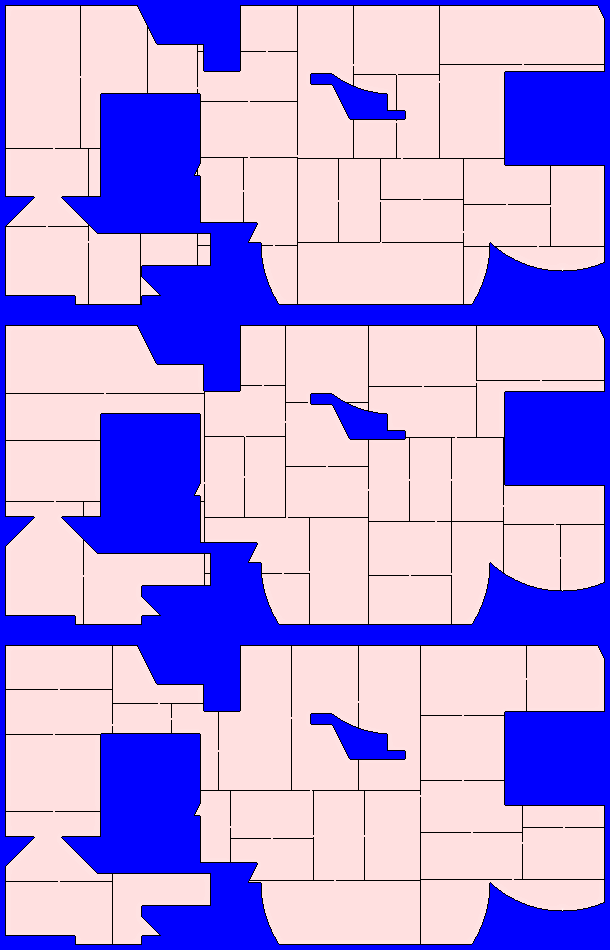

Step 1 | Reward: -0.7413 | Outside Air: 280.00K | Occupancy: 9.50
Avg zone temp: 294.00K | Avg damper: 0.10 | Avg VAV flow: 2.0000
AHU supply temps: ['284.2K', '284.2K', '284.2K', '284.2K', '284.2K']
AHU run cmds: [1, 1, 1, 1, 1] | AHU flow rates: ['50.00', '24.00', '18.00', '50.00', '26.00']
Total cooling: -1874.8 kW | Thermostat modes: {'OFF': 95}
Recirculation temp: 293.97K
Reward components: Productivity=$237.50  Elec=$66.67  Gas=$0.00  Carbon=38.53kg



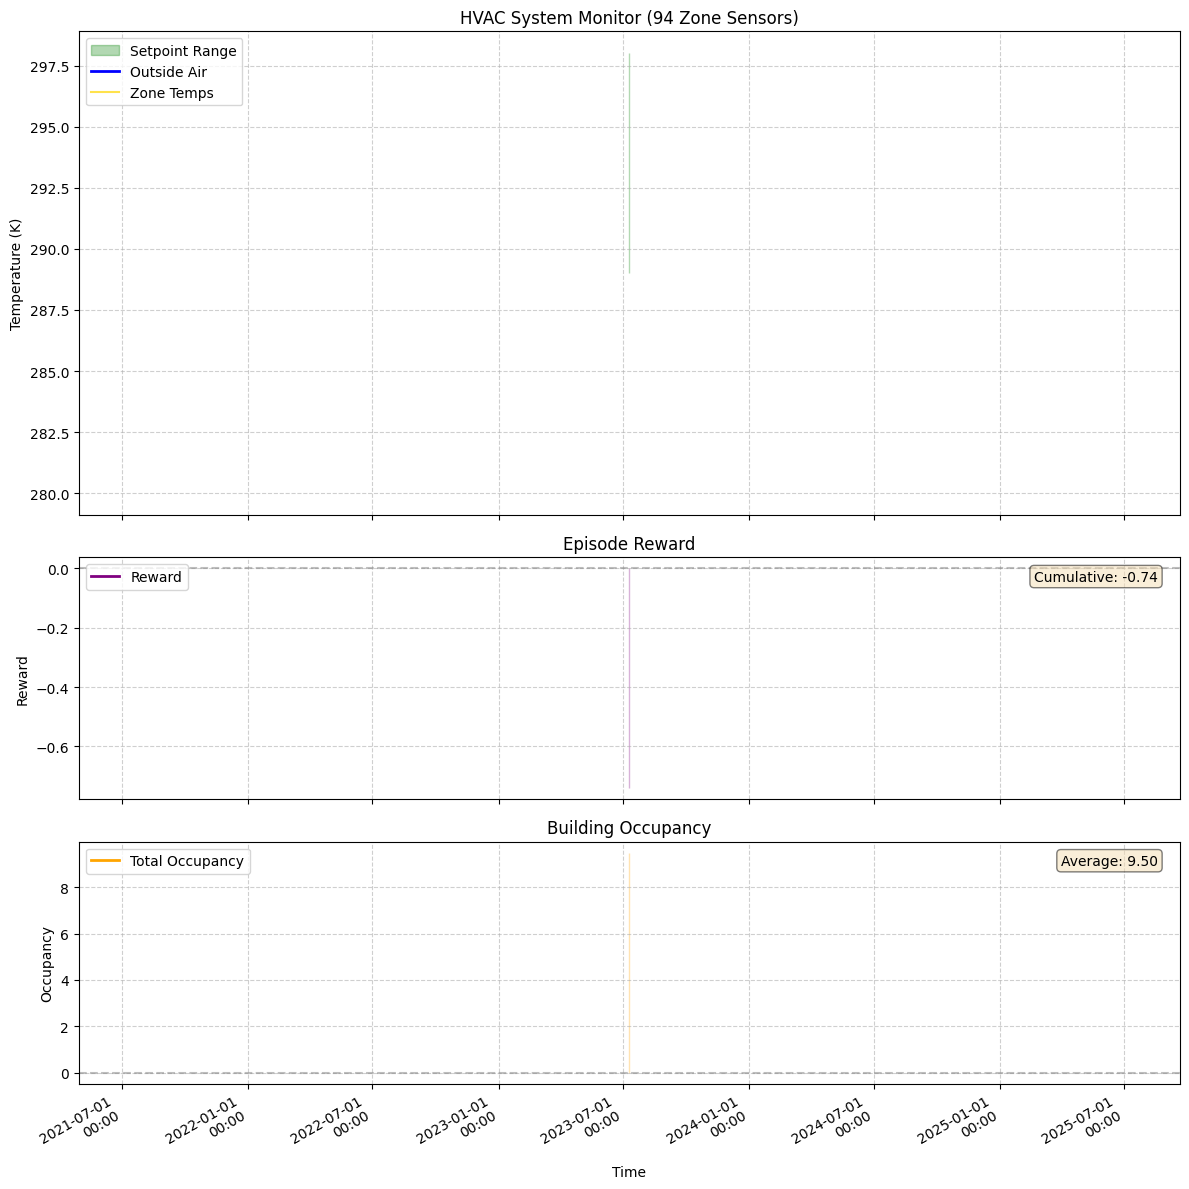

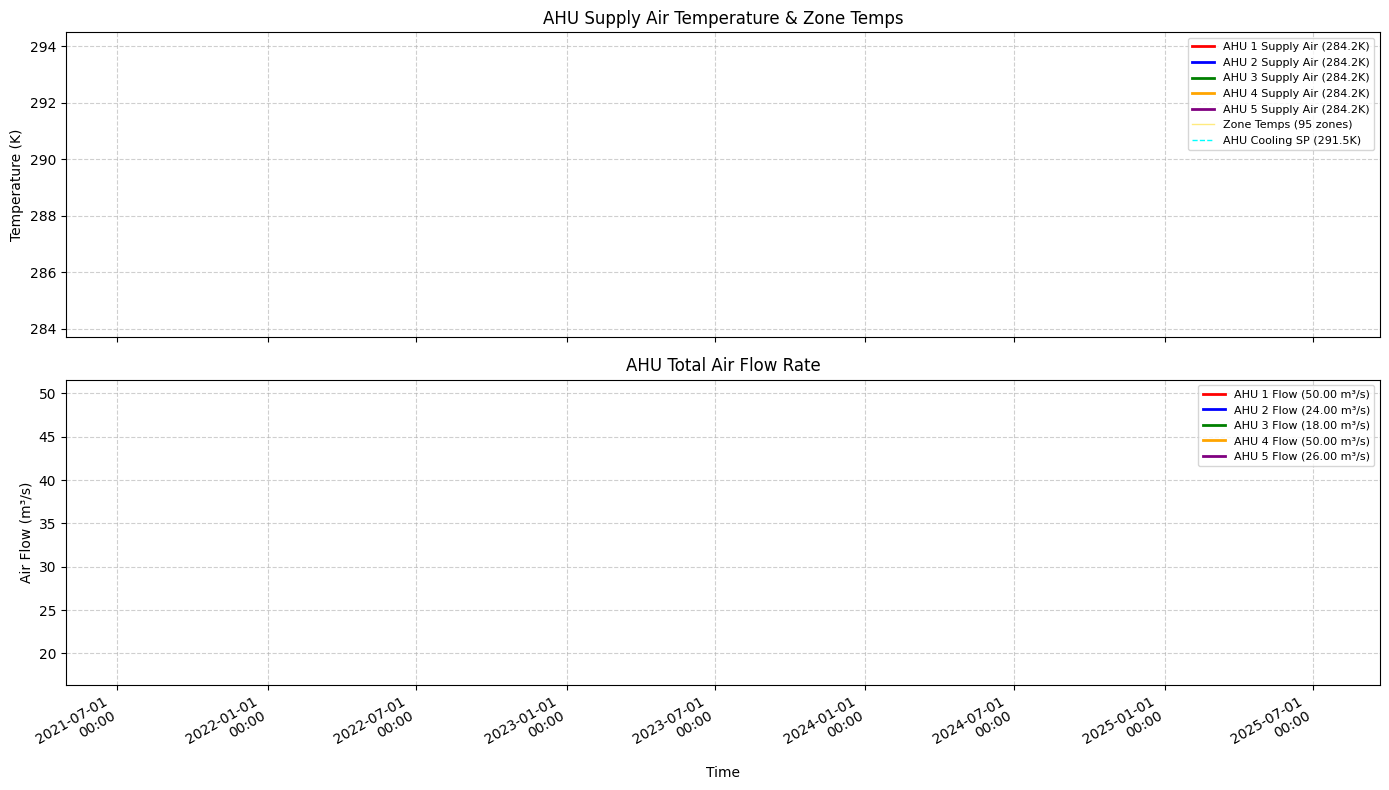

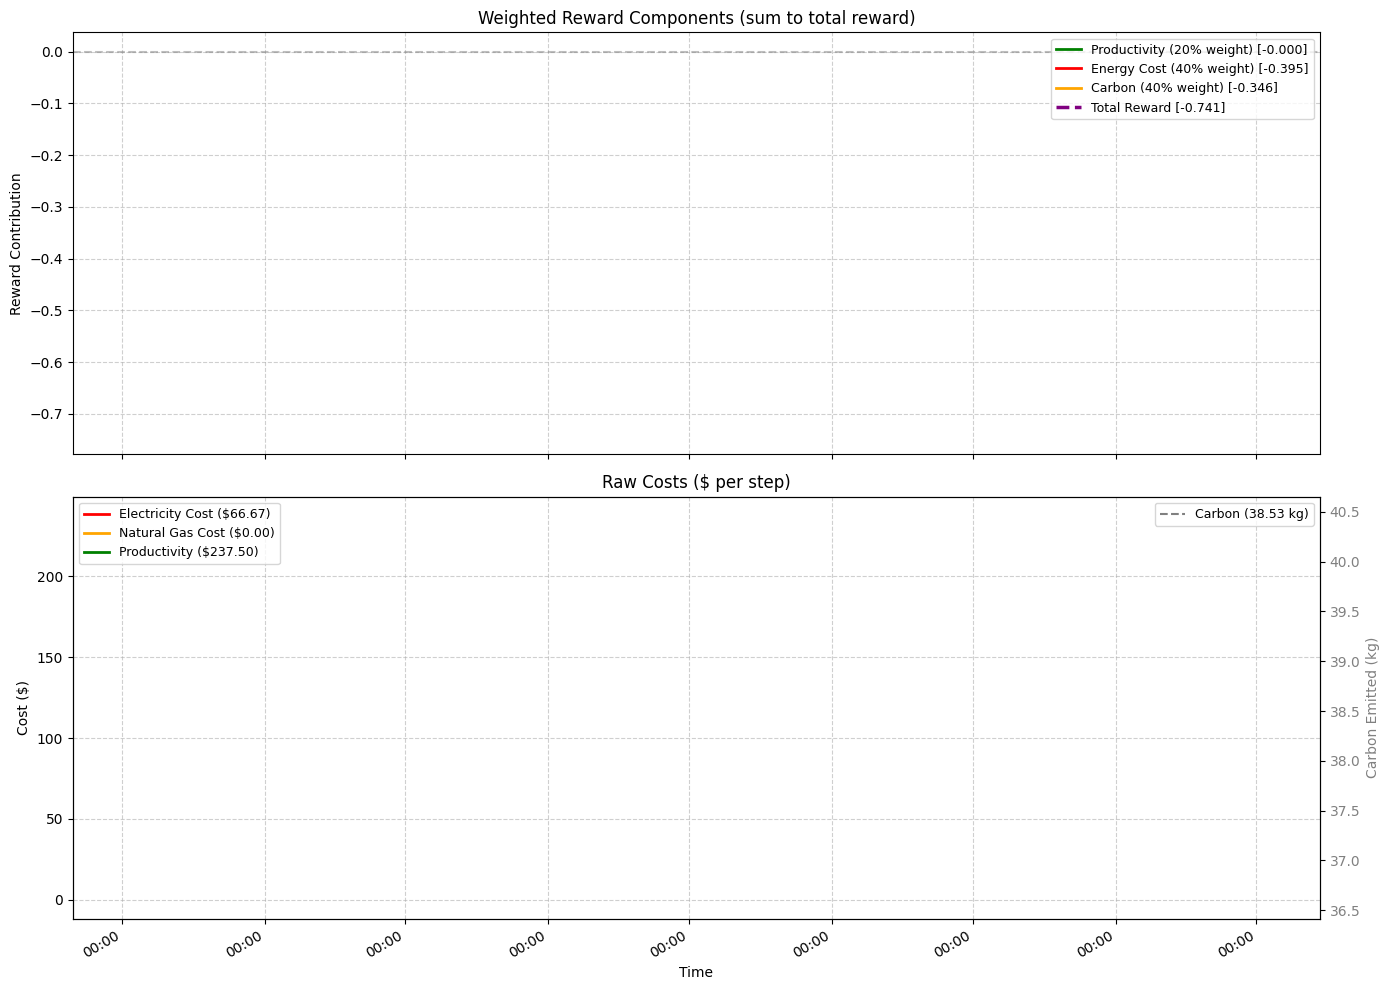

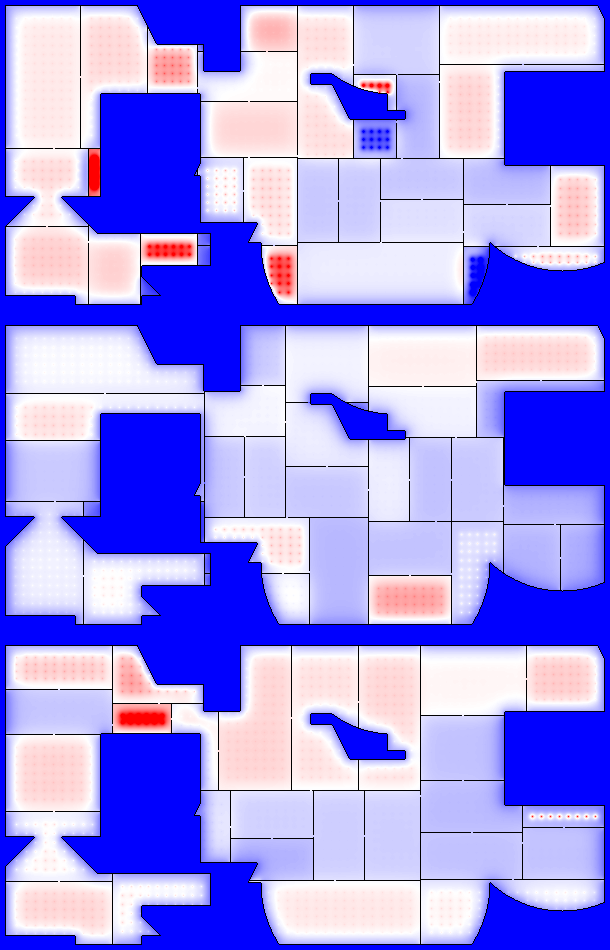

Step 101 | Reward: -0.8354 | Outside Air: 280.00K | Occupancy: 20.30
Avg zone temp: 290.06K | Avg damper: 0.56 | Avg VAV flow: 11.2842
AHU supply temps: ['283.3K', '283.3K', '283.3K', '283.3K', '283.3K']
AHU run cmds: [1, 1, 1, 1, 1] | AHU flow rates: ['50.00', '50.00', '50.00', '50.00', '50.00']
Total cooling: 11219.1 kW | Thermostat modes: {'COOL': 2, 'HEAT': 47, 'OFF': 46}
Recirculation temp: 290.88K
Reward components: Productivity=$708.25  Elec=$66.67  Gas=$0.77  Carbon=42.64kg



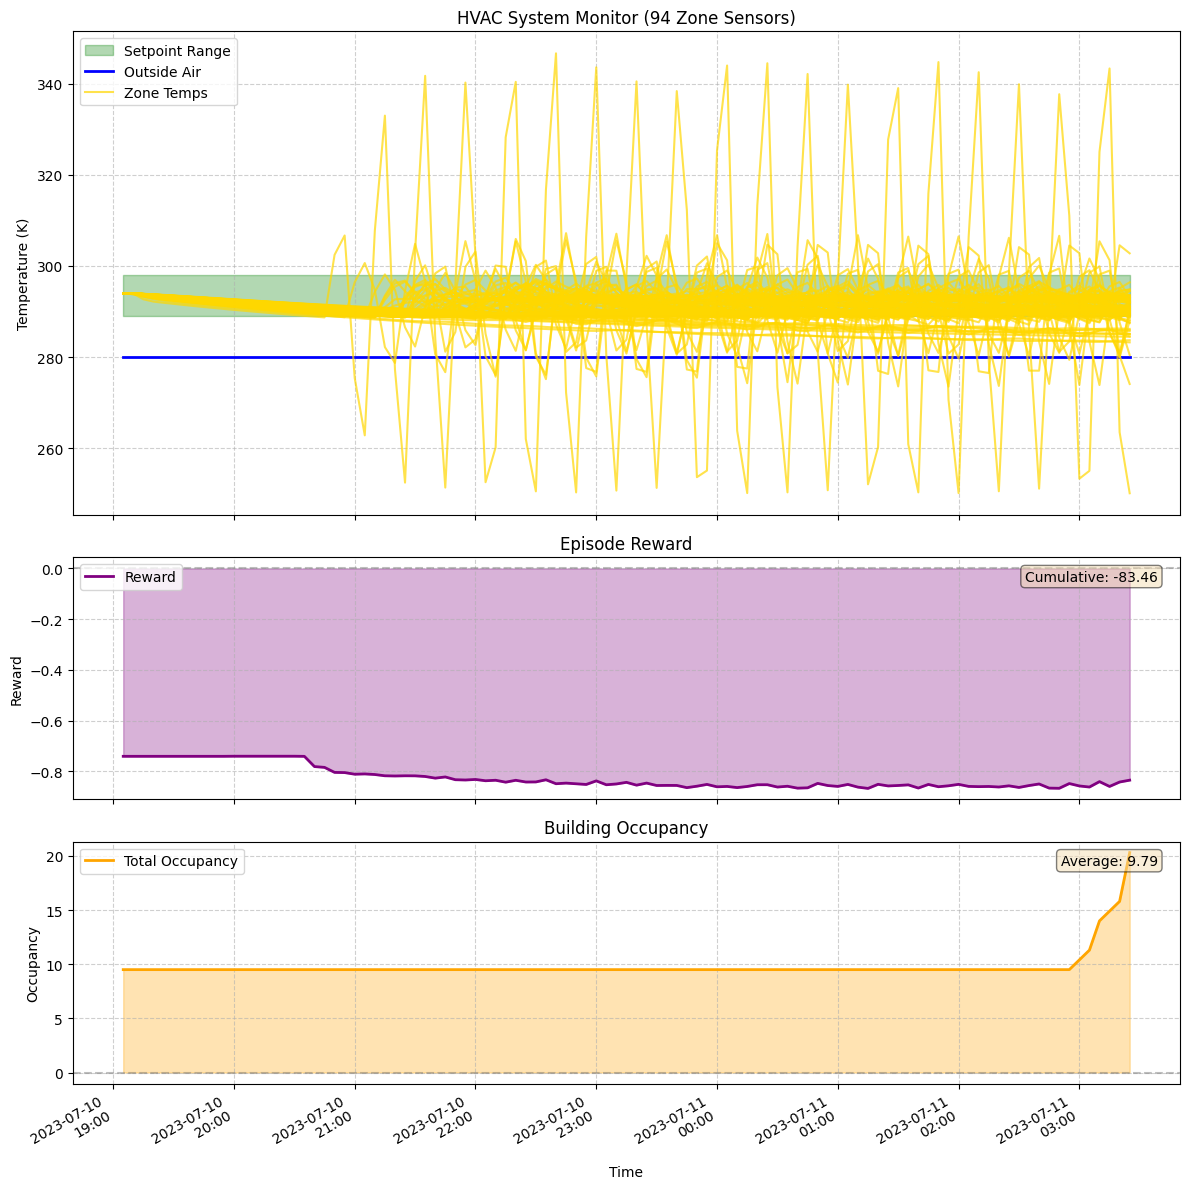

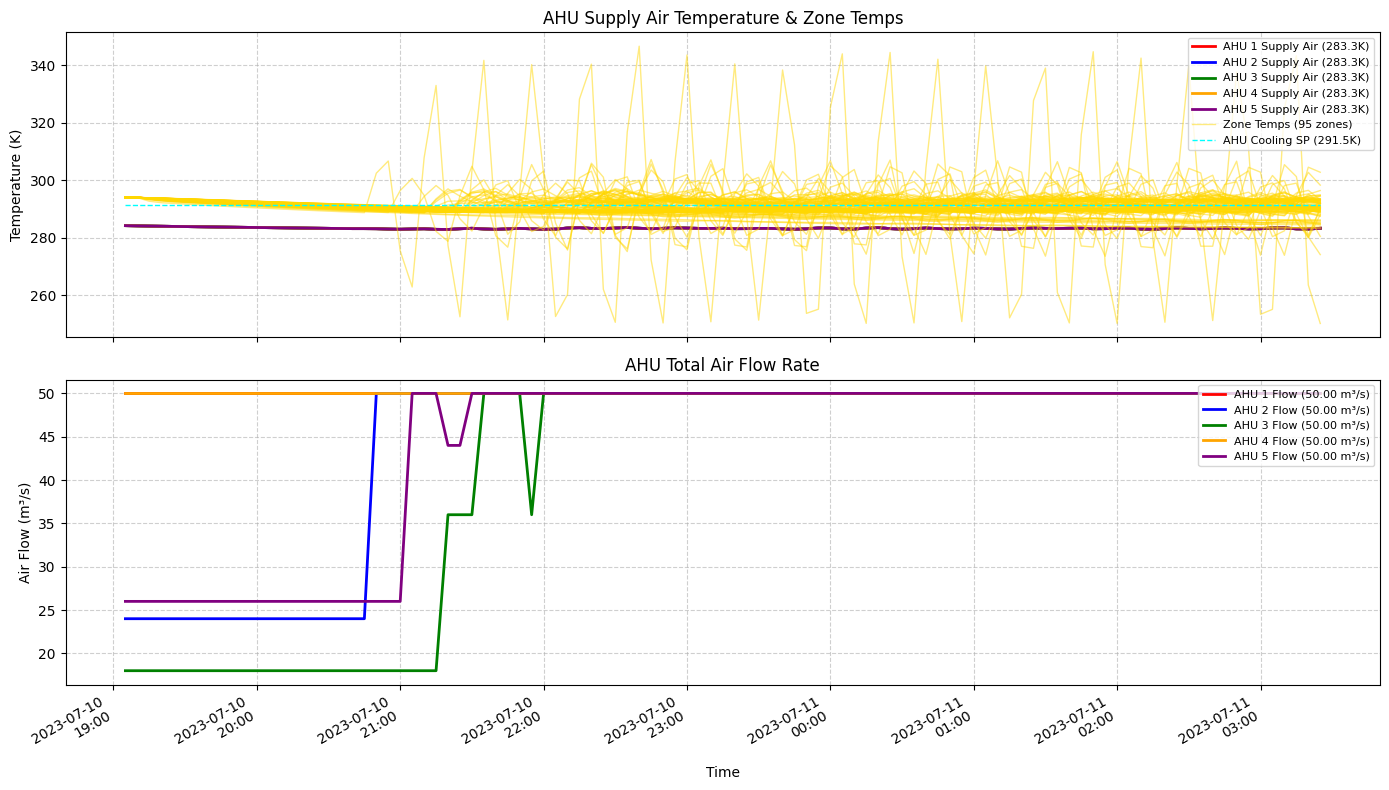

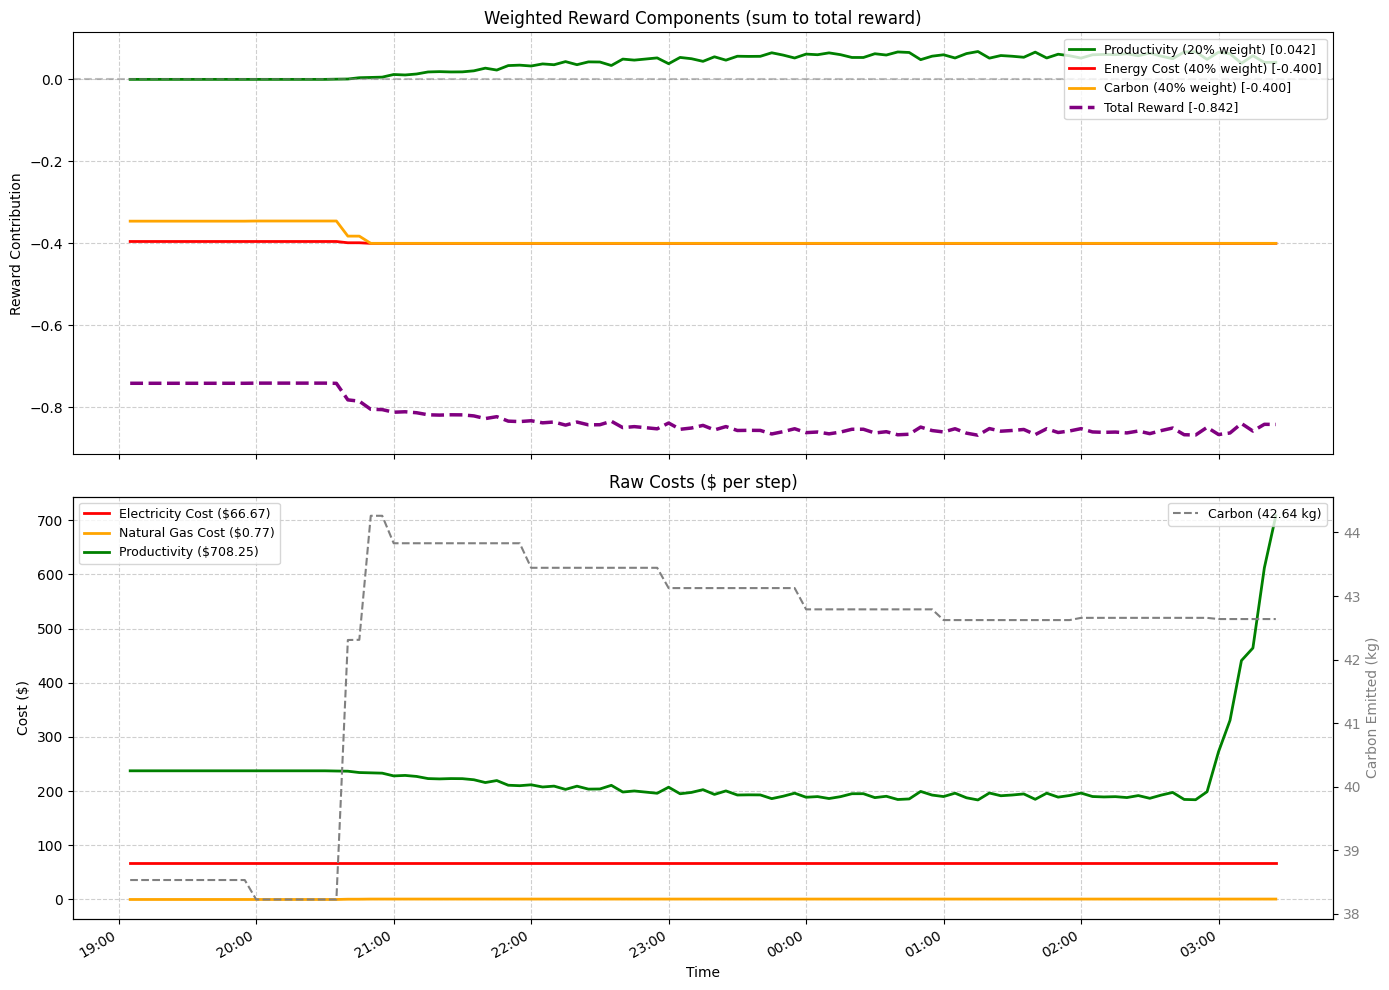

In [ ]:
# @title Simulation Settings

# @markdown ### Viewing Ranges
vmin = 280 # @param {type:"integer"}
vmax = 305 # @param {type:"integer"}

# @markdown ---
# @markdown ### Outside Air Temperature
high_temp = 280 # @param {type:"number"}
low_temp = 280 # @param {type:"number"}

# @markdown ---
# @markdown ### HVAC State (Normalized Actions)

# @markdown **All AHUs (shared settings)**
ahu_run_command = 1 # @param [0, 1] {type:"raw"}
ahu_supply_air_temperature_setpoint = -1 # @param {type:"slider", min:-1, max:1, step:0.1}
ahu_static_pressure_setpoint = 1 # @param {type:"slider", min:-1, max:1, step:0.1}

# @markdown **Hot Water System**
hws_run_command = 1 # @param [0, 1] {type:"raw"}
supply_water_setpoint = 1.0 # @param {type:"slider", min:-1, max:1, step:0.1}
differential_pressure = 1 # @param {type:"slider", min:-1, max:1, step:0.1}

# Determine number of AHUs from assignments
num_ahus = len(ahu_assignments)
print(f"Configuring simulation with {num_ahus} AHUs")

GIN_CONFIG_PATH = "demo_config.gin"
with open(GIN_CONFIG_PATH, "w") as text_file:
  text_file.write(get_config(high_temp, low_temp, floor_plan_path, zone_map_path, ahu_assignments))
gin.parse_config_file(GIN_CONFIG_PATH)

env = hybrid_action_environment.HybridActionEnvironment()
env.reset()
building_layout = env.building.simulator.building.floor_plan
renderer = building_renderer.BuildingRenderer(building_layout, 1)
def render_env(env):
  temps = env.building.simulator.building.temp
  image = renderer.render(temps, cmap='bwr',vmin=vmin,vmax=vmax).convert('RGB')
  return image

# Get reward weights from the environment's reward function
reward_fn = env.reward_function
productivity_weight = reward_fn._productivity_weight
energy_weight = reward_fn._energy_cost_weight
carbon_weight = reward_fn._carbon_emission_weight
print(f"Reward weights: productivity={productivity_weight}, energy={energy_weight}, carbon={carbon_weight}")


def plot_hvac_data_with_reward_and_occupancy(data_tuples, rewards, occupancy_data):
    if not data_tuples:
        print("No data to plot.")
        return
    timestamps = []
    oa_data = []
    sp_low_data = []
    sp_high_data = []
    k = len(data_tuples[0][0]) if data_tuples else 0
    if k == 0:
        print("Temps list is empty in the first tuple.")
        return
    temp_traces = [[] for _ in range(k)]
    for t_list, sp_list, oa_val, timestamp in data_tuples:
        timestamps.append(timestamp)
        oa_data.append(oa_val)
        sp_low_data.append(sp_list[0])
        sp_high_data.append(sp_list[1])
        for i in range(k):
            temp_traces[i].append(t_list[i])
    mpl_timestamps = [ts.to_pydatetime() for ts in timestamps]
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True,
                                         gridspec_kw={'height_ratios': [2, 1, 1]})
    ax1.fill_between(mpl_timestamps, sp_low_data, sp_high_data,
                     color='green', alpha=0.3, label='Setpoint Range')
    ax1.plot(mpl_timestamps, oa_data, color='blue', linewidth=2, label='Outside Air')
    for i, trace in enumerate(temp_traces):
        label = 'Zone Temps' if i == 0 else "_nolegend_"
        ax1.plot(mpl_timestamps, trace, color='#FFD700', linewidth=1.5, alpha=0.7, label=label)
    ax1.set_ylabel('Temperature (K)')
    ax1.set_title(f'HVAC System Monitor ({k} Zone Sensors)')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend(loc='upper left')
    ax2.plot(mpl_timestamps[:len(rewards)], rewards, color='purple', linewidth=2, label='Reward')
    ax2.fill_between(mpl_timestamps[:len(rewards)], rewards, alpha=0.3, color='purple')
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax2.set_ylabel('Reward')
    ax2.set_title('Episode Reward')
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend(loc='upper left')
    cumulative_reward = sum(rewards)
    ax2.annotate(f'Cumulative: {cumulative_reward:.2f}',
                 xy=(0.98, 0.95), xycoords='axes fraction',
                 ha='right', va='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax3.plot(mpl_timestamps[:len(occupancy_data)], occupancy_data, color='orange', linewidth=2, label='Total Occupancy')
    ax3.fill_between(mpl_timestamps[:len(occupancy_data)], occupancy_data, alpha=0.3, color='orange')
    ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax3.set_ylabel('Occupancy')
    ax3.set_xlabel('Time')
    ax3.set_title('Building Occupancy')
    ax3.grid(True, linestyle='--', alpha=0.6)
    ax3.legend(loc='upper left')
    avg_occupancy = sum(occupancy_data) / len(occupancy_data) if occupancy_data else 0
    ax3.annotate(f'Average: {avg_occupancy:.2f}',
                 xy=(0.98, 0.95), xycoords='axes fraction',
                 ha='right', va='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


def plot_ahu_diagnostics(ahu_vav_log):
    """Plots AHU supply air temps and AHU flow rates."""
    if not ahu_vav_log:
        return
    timestamps = [d['timestamp'] for d in ahu_vav_log]
    mpl_ts = [ts.to_pydatetime() for ts in timestamps]
    n_ahus = len(ahu_vav_log[0]['ahu_supply_temps'])
    n_zones = len(ahu_vav_log[0]['zone_dampers'])
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    # Panel 1: AHU Supply Air Temperature & Zone Temps
    ax = axes[0]
    colors_ahu = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'cyan']
    for a_idx in range(n_ahus):
        supply_temps = [d['ahu_supply_temps'][a_idx] for d in ahu_vav_log]
        run_cmds = [d['ahu_run_cmds'][a_idx] for d in ahu_vav_log]
        ax.plot(mpl_ts, supply_temps, color=colors_ahu[a_idx % len(colors_ahu)],
                linewidth=2, label=f'AHU {a_idx+1} Supply Air ({supply_temps[-1]:.1f}K)')
        off_ts = [t for t, r in zip(mpl_ts, run_cmds) if r == 0]
        off_temps = [s for s, r in zip(supply_temps, run_cmds) if r == 0]
        if off_ts:
            ax.scatter(off_ts, off_temps, color=colors_ahu[a_idx % len(colors_ahu)],
                       marker='x', s=50, zorder=5)
    for z_idx in range(n_zones):
        zone_temps = [d['zone_temps'][z_idx] for d in ahu_vav_log]
        label = f'Zone Temps ({n_zones} zones)' if z_idx == 0 else "_nolegend_"
        ax.plot(mpl_ts, zone_temps, color='#FFD700', linewidth=1, alpha=0.5, label=label)
    cooling_sps = [d['ahu_cooling_setpoints'][0] for d in ahu_vav_log]
    ax.plot(mpl_ts, cooling_sps, color='cyan', linewidth=1, linestyle='--',
            label=f'AHU Cooling SP ({cooling_sps[-1]:.1f}K)')
    ax.set_ylabel('Temperature (K)')
    ax.set_title('AHU Supply Air Temperature & Zone Temps')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Panel 2: AHU Total Air Flow Rate
    ax = axes[1]
    for a_idx in range(n_ahus):
        flow = [d['ahu_flow_rates'][a_idx] for d in ahu_vav_log]
        ax.plot(mpl_ts, flow, color=colors_ahu[a_idx % len(colors_ahu)],
                linewidth=2, label=f'AHU {a_idx+1} Flow ({flow[-1]:.2f} m³/s)')
    ax.set_ylabel('Air Flow (m³/s)')
    ax.set_xlabel('Time')
    ax.set_title('AHU Total Air Flow Rate')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


def plot_reward_components(reward_components_log):
    """Plots reward components: raw values and weighted contributions."""
    if not reward_components_log:
        return
    mpl_ts = [d['timestamp'].to_pydatetime() for d in reward_components_log]

    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Panel 1: Weighted contributions to total reward
    ax = axes[0]
    # Compute weighted contributions (these sum to agent_reward)
    # Formula from setpoint_energy_carbon_regret.py:
    #   raw = prod_regret * w1 - energy * w2 - carbon * w3
    #   agent_reward = raw / (w1 + w2 + w3)
    total_weight = productivity_weight + energy_weight + carbon_weight
    prod_contribution = [d['normalized_productivity_regret'] * productivity_weight / total_weight for d in reward_components_log]
    energy_contribution = [-d['normalized_energy_cost'] * energy_weight / total_weight for d in reward_components_log]
    carbon_contribution = [-d['normalized_carbon_emission'] * carbon_weight / total_weight for d in reward_components_log]
    agent_reward = [d['agent_reward'] for d in reward_components_log]

    ax.plot(mpl_ts, prod_contribution, 'g-', linewidth=2, 
            label=f'Productivity ({productivity_weight:.0%} weight) [{prod_contribution[-1]:.3f}]')
    ax.plot(mpl_ts, energy_contribution, 'r-', linewidth=2, 
            label=f'Energy Cost ({energy_weight:.0%} weight) [{energy_contribution[-1]:.3f}]')
    ax.plot(mpl_ts, carbon_contribution, 'orange', linewidth=2, 
            label=f'Carbon ({carbon_weight:.0%} weight) [{carbon_contribution[-1]:.3f}]')
    ax.plot(mpl_ts, agent_reward, 'purple', linewidth=2.5, linestyle='--',
            label=f'Total Reward [{agent_reward[-1]:.3f}]')
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_ylabel('Reward Contribution')
    ax.set_title('Weighted Reward Components (sum to total reward)')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, linestyle='--', alpha=0.6)

    # Panel 2: Raw costs (actual $ and kg values)
    ax = axes[1]
    elec_cost = [d['electricity_energy_cost'] for d in reward_components_log]
    gas_cost = [d['natural_gas_energy_cost'] for d in reward_components_log]
    carbon_kg = [d['carbon_emitted'] for d in reward_components_log]
    productivity = [d['productivity_reward'] for d in reward_components_log]

    ax.plot(mpl_ts, elec_cost, 'r-', linewidth=2, label=f'Electricity Cost (${elec_cost[-1]:.2f})')
    ax.plot(mpl_ts, gas_cost, 'orange', linewidth=2, label=f'Natural Gas Cost (${gas_cost[-1]:.2f})')
    ax.plot(mpl_ts, productivity, 'g-', linewidth=2, label=f'Productivity (${productivity[-1]:.2f})')

    ax2 = ax.twinx()
    ax2.plot(mpl_ts, carbon_kg, 'gray', linewidth=1.5, linestyle='--', label=f'Carbon ({carbon_kg[-1]:.2f} kg)')
    ax2.set_ylabel('Carbon Emitted (kg)', color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    ax.set_ylabel('Cost ($)')
    ax.set_xlabel('Time')
    ax.set_title('Raw Costs ($ per step)')
    ax.legend(loc='upper left', fontsize=9)
    ax2.legend(loc='upper right', fontsize=9)
    ax.grid(True, linestyle='--', alpha=0.6)

    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


info_to_log = []
rewards_to_log = []
occupancy_to_log = []
ahu_vav_log = []
reward_components_log = []

# Get zone IDs for occupancy calculation
zone_ids = list(env.building.simulator._hvac._vavs.keys())
time_step_sec = env.building.simulator._time_step_sec
ahus = env.building.simulator._hvac.air_handler._ahus

for i in range(2000):

  # Build action dynamically based on number of AHUs
  discrete_actions = [ahu_run_command] * num_ahus + [hws_run_command]
  continuous_actions = []
  for _ in range(num_ahus):
    continuous_actions.extend([ahu_supply_air_temperature_setpoint, ahu_static_pressure_setpoint])
  continuous_actions.extend([supply_water_setpoint, differential_pressure])

  action = {
      'discrete_action': discrete_actions,
      'continuous_action': continuous_actions,
  }
  time_step = env.step(action)
  reward = float(time_step.reward)
  rewards_to_log.append(reward)
  timestamp = env.building.current_timestamp
  outside_air = ahus[0].outside_air_temperature_sensor

  # Get reward response with individual components
  _, reward_response = env.get_reward_info_and_response()
  reward_components_log.append({
      'timestamp': timestamp,
      'agent_reward': reward_response.agent_reward_value,
      'productivity_reward': reward_response.productivity_reward,
      'electricity_energy_cost': reward_response.electricity_energy_cost,
      'natural_gas_energy_cost': reward_response.natural_gas_energy_cost,
      'carbon_emitted': reward_response.carbon_emitted,
      'carbon_cost': reward_response.carbon_cost,
      'normalized_productivity_regret': reward_response.normalized_productivity_regret,
      'normalized_energy_cost': reward_response.normalized_energy_cost,
      'normalized_carbon_emission': reward_response.normalized_carbon_emission,
      'total_occupancy': reward_response.total_occupancy,
  })

  # Calculate total occupancy across all zones
  total_occupancy = 0.0
  end_time = timestamp + pd.Timedelta(time_step_sec, unit='s')
  for zone_id in zone_ids:
    zone_occupancy = env.building.occupancy.average_zone_occupancy(zone_id, timestamp, end_time)
    total_occupancy += zone_occupancy
  occupancy_to_log.append(total_occupancy)

  vavs = env.building.simulator._hvac._vavs
  temps = []
  dampers = []
  flow_rates = []
  zone_q_watts = []
  thermostat_modes = []

  avg_temps_dict = env.building.simulator.building.get_zone_average_temps()
  recirculation_temp = sum(avg_temps_dict.values()) / len(avg_temps_dict)

  for zone_key, vav in vavs.items():
    temps.append(vav.zone_air_temperature)
    dampers.append(vav.damper_setting)
    flow_rates.append(vav.flow_rate_demand)
    thermostat_modes.append(vav.thermostat._current_mode.name)

    zone_temp = vav.zone_air_temperature
    ahu = vav.air_handler
    supply_temp = ahu.get_supply_air_temp(recirculation_temp, outside_air)
    q = vav.compute_energy_applied_to_zone(
        zone_temp, supply_temp,
        vav.hot_water_system.supply_water_temperature_sensor)
    zone_q_watts.append(q)

  temp_window = list(vavs.values())[0].thermostat.get_setpoint_schedule().get_temperature_window(timestamp)
  info_to_log.append((temps[:13] + temps[13+1:], temp_window, outside_air, timestamp))

  ahu_vav_log.append({
      'timestamp': timestamp,
      'ahu_supply_temps': [ahu.get_supply_air_temp(recirculation_temp, outside_air) for ahu in ahus],
      'ahu_run_cmds': [int(ahu.run_command) for ahu in ahus],
      'ahu_flow_rates': [ahu.air_flow_rate for ahu in ahus],
      'ahu_cooling_setpoints': [ahu.cooling_air_temp_setpoint for ahu in ahus],
      'ahu_sat_setpoints': [ahu.supply_air_temperature_setpoint for ahu in ahus],
      'zone_temps': list(temps),
      'zone_dampers': list(dampers),
      'zone_flow_rates': list(flow_rates),
      'zone_q_watts': list(zone_q_watts),
      'zone_thermostat_modes': list(thermostat_modes),
      'recirculation_temp': recirculation_temp,
  })

  if i % 100 == 0:
    display(render_env(env))
    print(f'Step {i+1} | Reward: {reward:.4f} | Outside Air: {outside_air:.2f}K | Occupancy: {total_occupancy:.2f}')
    print(f"Avg zone temp: {sum(temps)/len(temps):.2f}K | Avg damper: {sum(dampers)/len(dampers):.2f} | Avg VAV flow: {sum(flow_rates)/len(flow_rates):.4f}")
    print(f"AHU supply temps: {[f'{ahu.get_supply_air_temp(recirculation_temp, outside_air):.1f}K' for ahu in ahus]}")
    print(f"AHU run cmds: {[int(ahu.run_command) for ahu in ahus]} | AHU flow rates: {[f'{ahu.air_flow_rate:.2f}' for ahu in ahus]}")
    print(f"Total cooling: {sum(zone_q_watts)/1000:.1f} kW | Thermostat modes: {dict(zip(*np.unique(thermostat_modes, return_counts=True)))}")
    print(f"Recirculation temp: {recirculation_temp:.2f}K")
    if reward_components_log:
      rc = reward_components_log[-1]
      print(f"Reward components: Productivity=${rc['productivity_reward']:.2f}  Elec=${rc['electricity_energy_cost']:.2f}  Gas=${rc['natural_gas_energy_cost']:.2f}  Carbon={rc['carbon_emitted']:.2f}kg")
    print()

    plot_hvac_data_with_reward_and_occupancy(info_to_log, rewards_to_log, occupancy_to_log)
    plot_ahu_diagnostics(ahu_vav_log)
    plot_reward_components(reward_components_log)

# Print final summary
print(f"\n{'='*50}")
print(f"Simulation Complete!")
print(f"Total Steps: {len(rewards_to_log)}")
print(f"Cumulative Reward: {sum(rewards_to_log):.4f}")
print(f"Average Reward: {sum(rewards_to_log)/len(rewards_to_log):.4f}")
print(f"Min Reward: {min(rewards_to_log):.4f}")
print(f"Max Reward: {max(rewards_to_log):.4f}")
print(f"Average Occupancy: {sum(occupancy_to_log)/len(occupancy_to_log):.2f}")
print(f"{'='*50}")

In [ ]:
# @title Ablation Study: Effect of Each Action on Reward Components

import pandas as pd

# Number of steps per configuration (keep small for speed)
ABLATION_STEPS = 50

# Define baseline and test configurations
# Format: (name, discrete_action, continuous_action)
# discrete: [ahu_1_run, ahu_2_run, hws_run]
# continuous: [ahu_1_sat, ahu_1_pressure, ahu_2_sat, ahu_2_pressure, water_temp, diff_pressure]

baseline_discrete = [1, 1, 0]  # AHUs on, HWS off
baseline_continuous = [-1, 1, -1, 1, 1.0, -1]  # cold supply, high pressure, hot water, low diff pressure

configurations = [
    ("Baseline (AHUs ON, cold supply, high pressure)", baseline_discrete, baseline_continuous),
    
    # Run command ablations
    # ("AHU 1 OFF", [0, 1, 0], baseline_continuous),
    # ("AHU 2 OFF", [1, 0, 0], baseline_continuous),
    # ("Both AHUs OFF", [0, 0, 0], baseline_continuous),
    # ("HWS ON", [1, 1, 1], baseline_continuous),
    
    # # Supply air temp ablations
    # ("AHU SAT = 0 (mid)", baseline_discrete, [0, 1, 0, 1, 1.0, -1]),
    # ("AHU SAT = +1 (warm)", baseline_discrete, [1, 1, 1, 1, 1.0, -1]),
    
    # # Static pressure ablations
    # ("Static Pressure = -1 (low)", baseline_discrete, [-1, -1, -1, -1, 1.0, -1]),
    # ("Static Pressure = 0 (mid)", baseline_discrete, [-1, 0, -1, 0, 1.0, -1]),
    
    # Hot water system ablations
    # Water Temp: change last value from -1 to 1 (so water flows)
    ("HWS ON + Water Temp = -1 (cold)", [1, 1, 1], [-1, 1, -1, 1, -1, 1]),
    ("HWS ON + Water Temp = 0 (mid)", [1, 1, 1], [-1, 1, -1, 1, 0, 1]),

    # Diff Pressure: change baseline_discrete to [1,1,1] (so HWS is ON)
    ("Diff Pressure = 0 (mid)", [1, 1, 1], [-1, 1, -1, 1, 1.0, 0]),
    ("Diff Pressure = +1 (high)", [1, 1, 1], [-1, 1, -1, 1, 1.0, 1]),

]

results = []

for config_name, discrete, continuous in configurations:
    # Reset environment for each configuration
    env.reset()
    
    action = {
        'discrete_action': discrete,
        'continuous_action': continuous,
    }
    
    # Collect metrics over steps
    rewards = []
    elec_costs = []
    gas_costs = []
    carbon_emitted = []
    productivity = []
    
    for step in range(ABLATION_STEPS):
        time_step = env.step(action)
        _, reward_response = env.get_reward_info_and_response()
        
        rewards.append(reward_response.agent_reward_value)
        elec_costs.append(reward_response.electricity_energy_cost)
        gas_costs.append(reward_response.natural_gas_energy_cost)
        carbon_emitted.append(reward_response.carbon_emitted)
        productivity.append(reward_response.productivity_reward)
    
    # Store averages
    results.append({
        'Configuration': config_name,
        'Avg Reward': sum(rewards) / len(rewards),
        'Avg Elec ($)': sum(elec_costs) / len(elec_costs),
        'Avg Gas ($)': sum(gas_costs) / len(gas_costs),
        'Avg Carbon (kg)': sum(carbon_emitted) / len(carbon_emitted),
        'Avg Productivity ($)': sum(productivity) / len(productivity),
        'Final Temp (K)': list(env.building.simulator._hvac._vavs.values())[0].zone_air_temperature,
    })
    
    print(f"Done: {config_name}")

# Create summary DataFrame
df = pd.DataFrame(results)

# Display results
print("\n" + "="*80)
print("ABLATION STUDY RESULTS")
print("="*80)
print(f"\nSteps per config: {ABLATION_STEPS}")
print(f"\nBaseline: AHUs ON, cold supply air (-1), high static pressure (+1), HWS OFF\n")

# Format and display
pd.set_option('display.max_colwidth', 40)
pd.set_option('display.width', 200)
print(df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

configs = df['Configuration'].tolist()
x = range(len(configs))

# Reward
ax = axes[0, 0]
ax.bar(x, df['Avg Reward'], color='purple', alpha=0.7)
ax.set_ylabel('Avg Reward')
ax.set_title('Agent Reward by Configuration')
ax.set_xticks(x)
ax.set_xticklabels(configs, rotation=45, ha='right', fontsize=7)
ax.axhline(df['Avg Reward'].iloc[0], color='red', linestyle='--', alpha=0.5, label='Baseline')

# Electricity
ax = axes[0, 1]
ax.bar(x, df['Avg Elec ($)'], color='red', alpha=0.7)
ax.set_ylabel('Avg Electricity Cost ($)')
ax.set_title('Electricity Cost by Configuration')
ax.set_xticks(x)
ax.set_xticklabels(configs, rotation=45, ha='right', fontsize=7)
ax.axhline(df['Avg Elec ($)'].iloc[0], color='blue', linestyle='--', alpha=0.5, label='Baseline')

# Gas
ax = axes[1, 0]
ax.bar(x, df['Avg Gas ($)'], color='orange', alpha=0.7)
ax.set_ylabel('Avg Gas Cost ($)')
ax.set_title('Natural Gas Cost by Configuration')
ax.set_xticks(x)
ax.set_xticklabels(configs, rotation=45, ha='right', fontsize=7)
ax.axhline(df['Avg Gas ($)'].iloc[0], color='blue', linestyle='--', alpha=0.5, label='Baseline')

# Carbon
ax = axes[1, 1]
ax.bar(x, df['Avg Carbon (kg)'], color='gray', alpha=0.7)
ax.set_ylabel('Avg Carbon Emitted (kg)')
ax.set_title('Carbon Emissions by Configuration')
ax.set_xticks(x)
ax.set_xticklabels(configs, rotation=45, ha='right', fontsize=7)
ax.axhline(df['Avg Carbon (kg)'].iloc[0], color='blue', linestyle='--', alpha=0.5, label='Baseline')

plt.tight_layout()
plt.show()

# Show deltas from baseline
print("\n" + "="*80)
print("DELTAS FROM BASELINE")
print("="*80)
baseline_row = df.iloc[0]
for idx, row in df.iterrows():
    if idx == 0:
        continue
    print(f"\n{row['Configuration']}:")
    print(f"  Reward:  {row['Avg Reward'] - baseline_row['Avg Reward']:+.4f}")
    print(f"  Elec:    {row['Avg Elec ($)'] - baseline_row['Avg Elec ($)']:+.4f} $")
    print(f"  Gas:     {row['Avg Gas ($)'] - baseline_row['Avg Gas ($)']:+.4f} $")
    print(f"  Carbon:  {row['Avg Carbon (kg)'] - baseline_row['Avg Carbon (kg)']:+.4f} kg")

In [ ]:
# @title Debug: Check Reward Energy Calculation

print("=== CHECKING REWARD ENERGY CALCULATION ===")

hvac = env.building.simulator.hvac

# Reset and do one step with AHU 1 OFF
env.reset()
test_action = {
    'discrete_action': [0, 1, 0],  # AHU 1 OFF
    'continuous_action': [-1, 1, -1, 1, 1.0, -1],
}
time_step = env.step(test_action)

print("\n--- AHU States after step ---")
for i, ahu in enumerate(hvac.air_handler._ahus):
    print(f"  AHU {i+1}: run_command={ahu._run_command}, air_flow_rate={ahu.air_flow_rate:.2f}")

# Now get the reward_info (this is what the reward function uses)
reward_info, reward_response = env.get_reward_info_and_response()

print("\n--- Reward Info (air_handler_reward_infos) ---")
for ah_id, ah_info in reward_info.air_handler_reward_infos.items():
    print(f"  {ah_id}:")
    print(f"    blower_electrical_energy_rate: {ah_info.blower_electrical_energy_rate:.2f} W")
    print(f"    air_conditioning_electrical_energy_rate: {ah_info.air_conditioning_electrical_energy_rate:.2f} W")

# Manually compute what the energy SHOULD be
print("\n--- Manual Calculation (what it SHOULD be) ---")
total_blower = 0
for i, ahu in enumerate(hvac.air_handler._ahus):
    intake = ahu.compute_intake_fan_energy_rate()
    exhaust = ahu.compute_exhaust_fan_energy_rate()
    total = intake + exhaust
    print(f"  AHU {i+1}: intake={intake:.2f}, exhaust={exhaust:.2f}, total={total:.2f} W")
    total_blower += total
print(f"  Total blower energy: {total_blower:.2f} W")

# What the system computes
system_blower = hvac.air_handler.compute_intake_fan_energy_rate() + hvac.air_handler.compute_exhaust_fan_energy_rate()
print(f"  System.compute_*_energy_rate(): {system_blower:.2f} W")

print("\n--- Reward Response ---")
print(f"  electricity_energy_cost: {reward_response.electricity_energy_cost:.6f}")


Generated 26 rooms with 4 AHUs


2026-02-06 13:57:22.721707: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-06 13:57:22.721743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-06 13:57:22.723068: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-06 13:57:22.729671: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-06 13:57:23.455568: W tensorflow/compiler/tf2

=== ACTION SPEC ===

action = {
    'discrete_action': [  # shape: (5,)
        # [0] ahu_ahu_1_supervisor_run_command -> Off=0, On=1
        # [1] ahu_ahu_2_supervisor_run_command -> Off=0, On=1
        # [2] ahu_ahu_3_supervisor_run_command -> Off=0, On=1
        # [3] ahu_ahu_4_supervisor_run_command -> Off=0, On=1
        # [4] hws_supervisor_run_command -> Off=0, On=1
    ],
    'continuous_action': [  # shape: (10,)
        # [0] ahu_ahu_1_supply_air_temperature_setpoint -> [285, 305.0] K
        # [1] ahu_ahu_1_static_pressure_setpoint -> [0, 20000.0] Pa
        # [2] ahu_ahu_2_supply_air_temperature_setpoint -> [285, 305.0] K
        # [3] ahu_ahu_2_static_pressure_setpoint -> [0, 20000.0] Pa
        # [4] ahu_ahu_3_supply_air_temperature_setpoint -> [285, 305.0] K
        # [5] ahu_ahu_3_static_pressure_setpoint -> [0, 20000.0] Pa
        # [6] ahu_ahu_4_supply_air_temperature_setpoint -> [285, 305.0] K
        # [7] ahu_ahu_4_static_pressure_setpoint -> [0, 20000.0] Pa
      

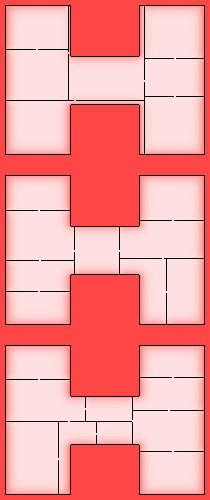

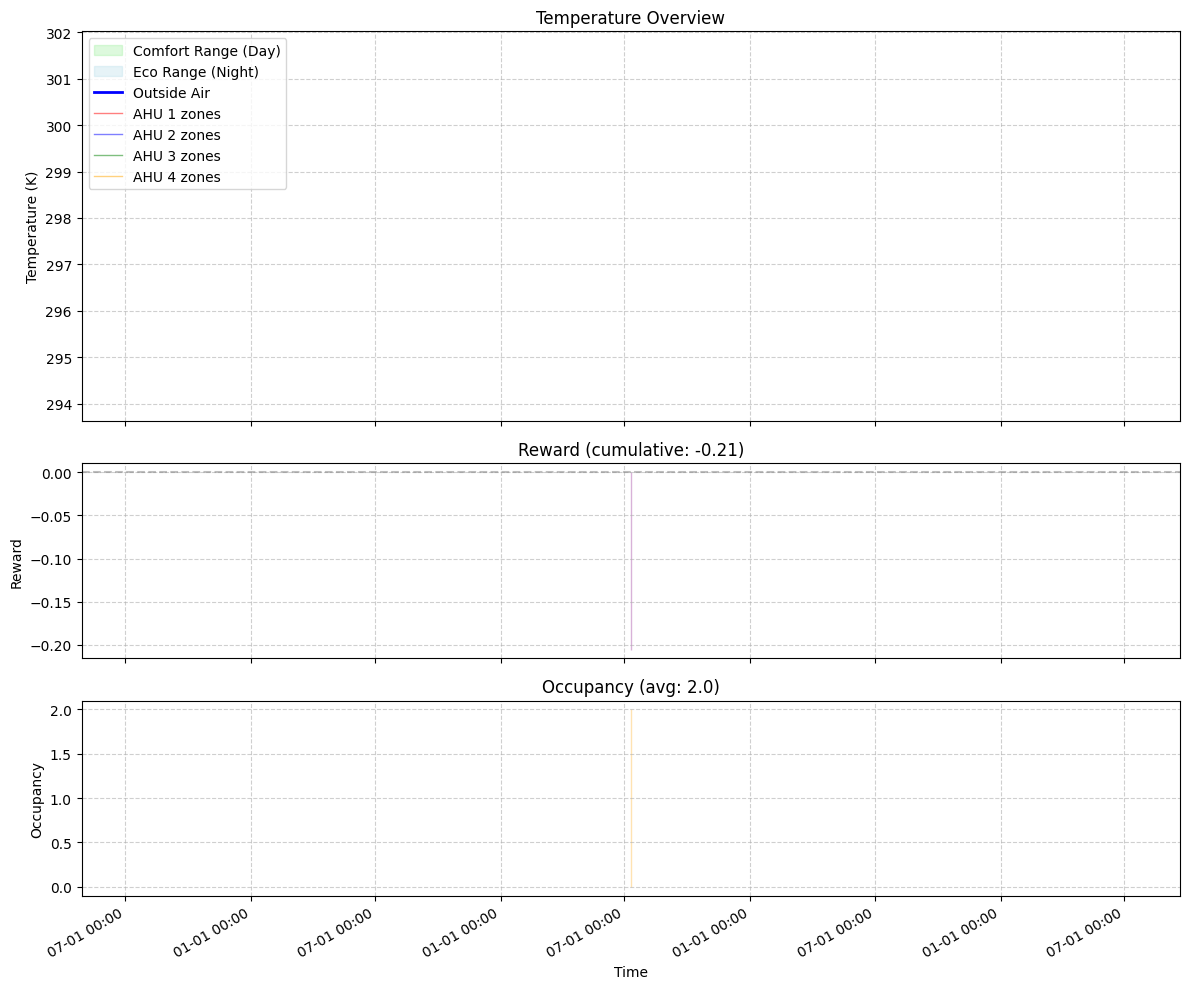

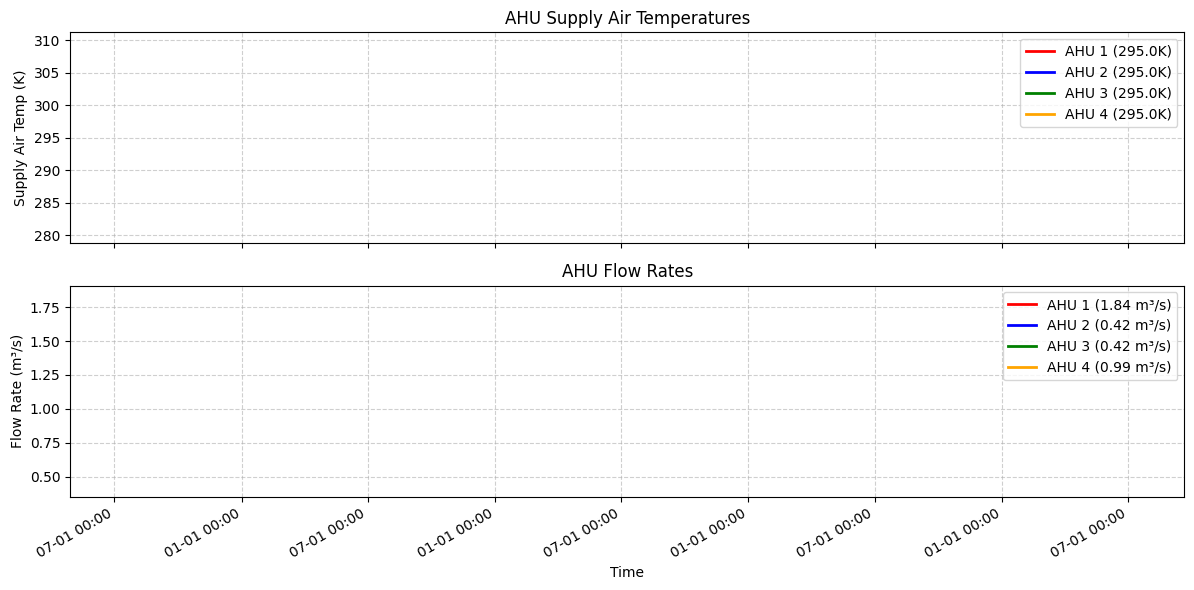

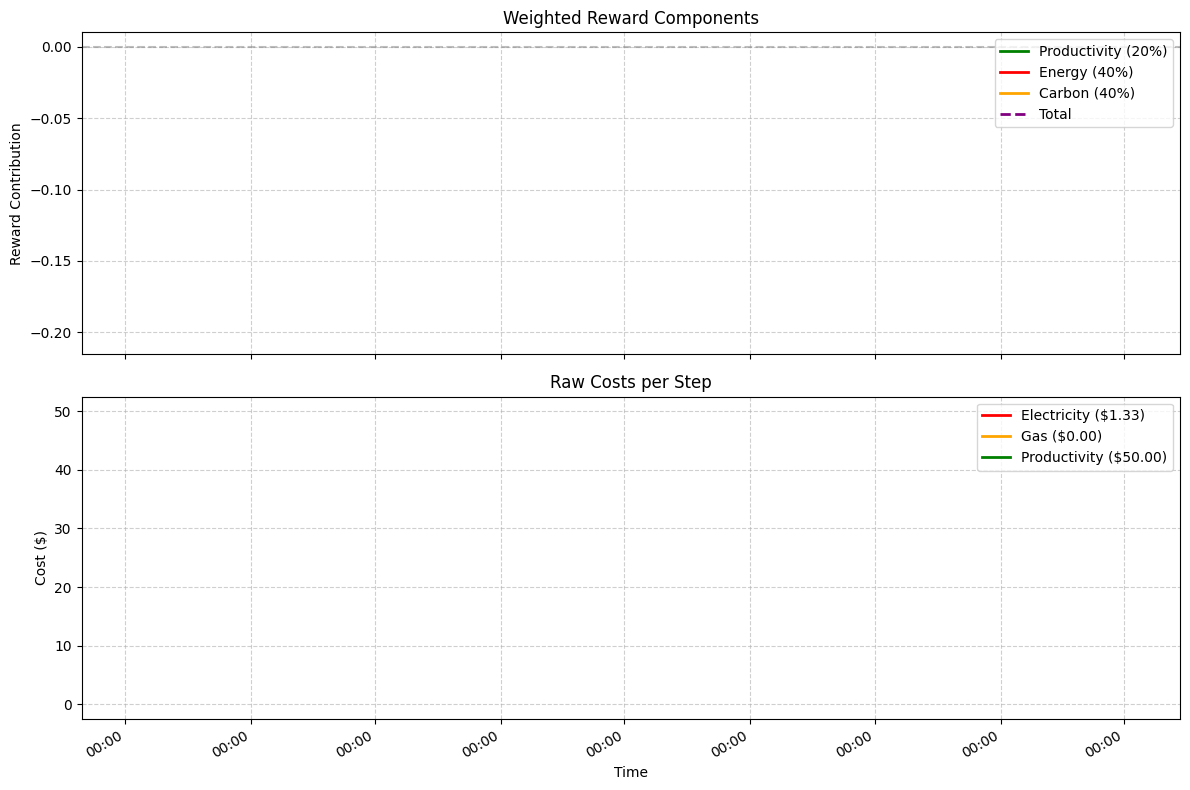

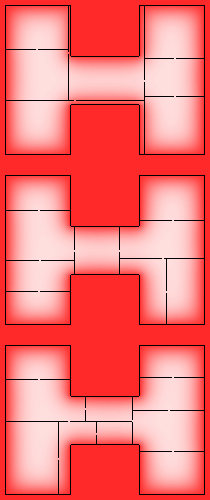

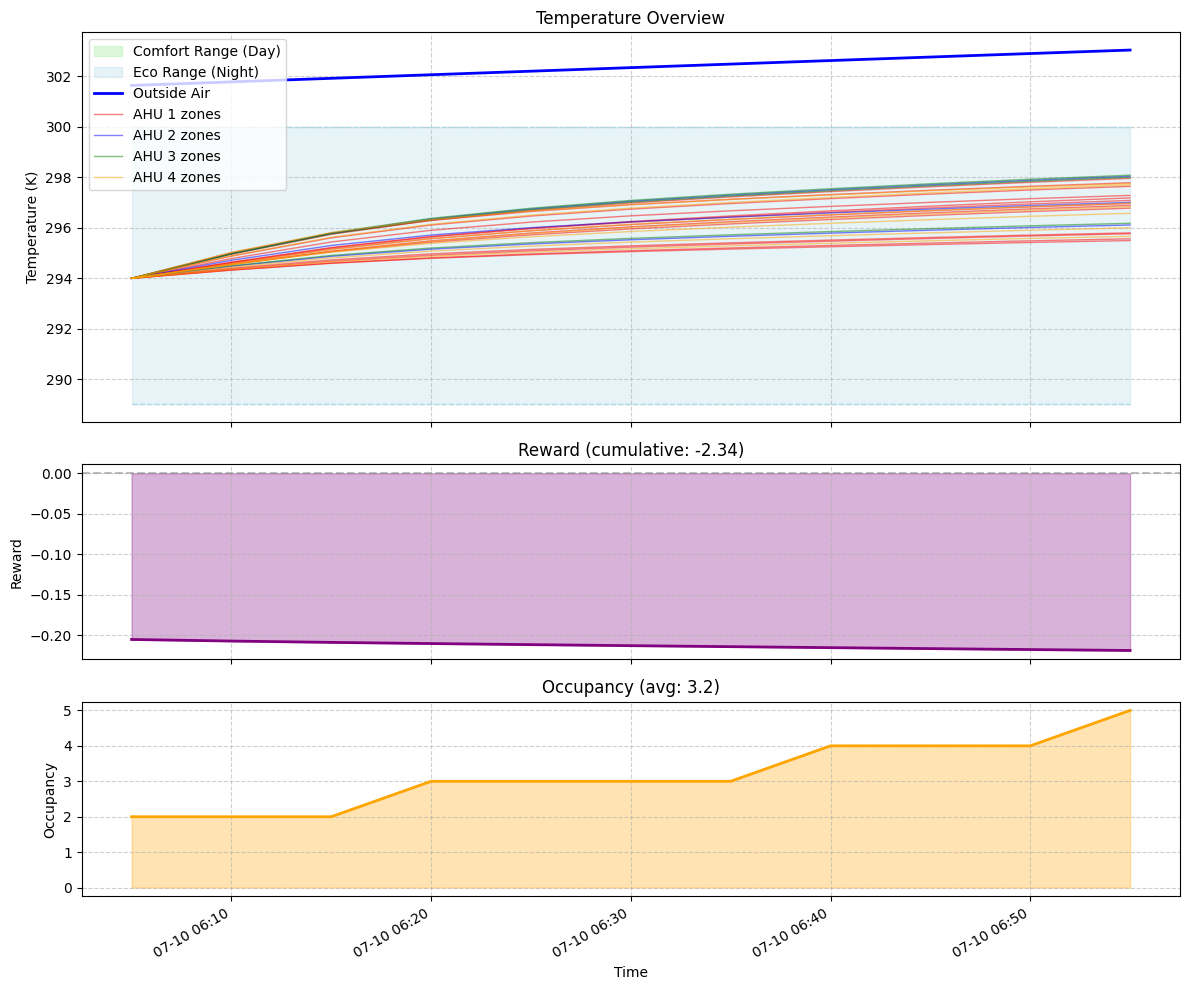

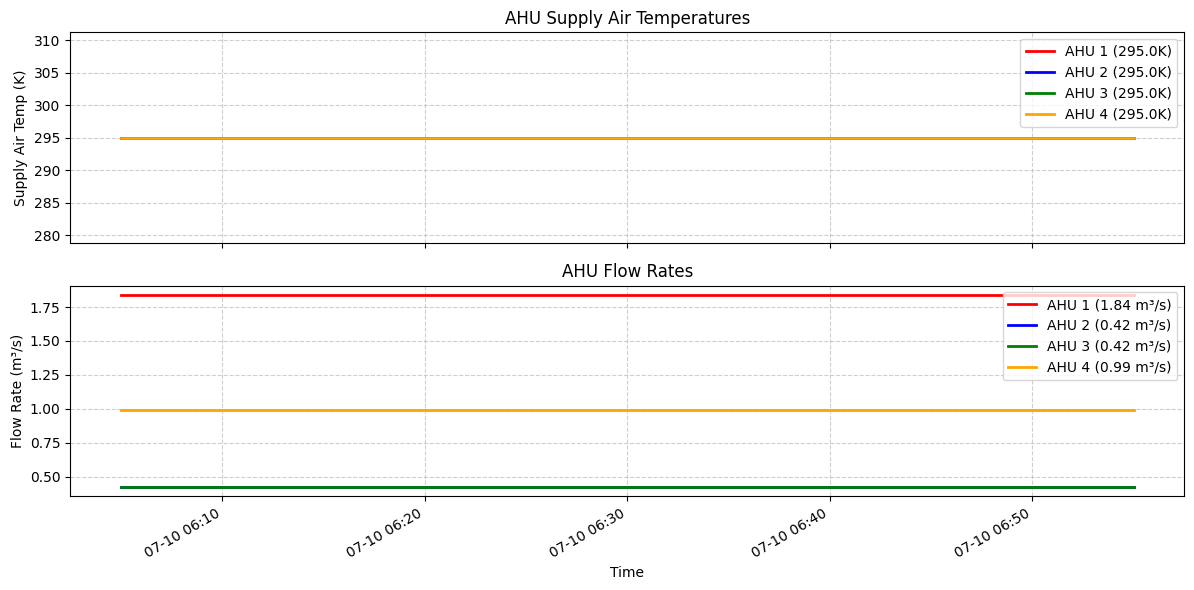

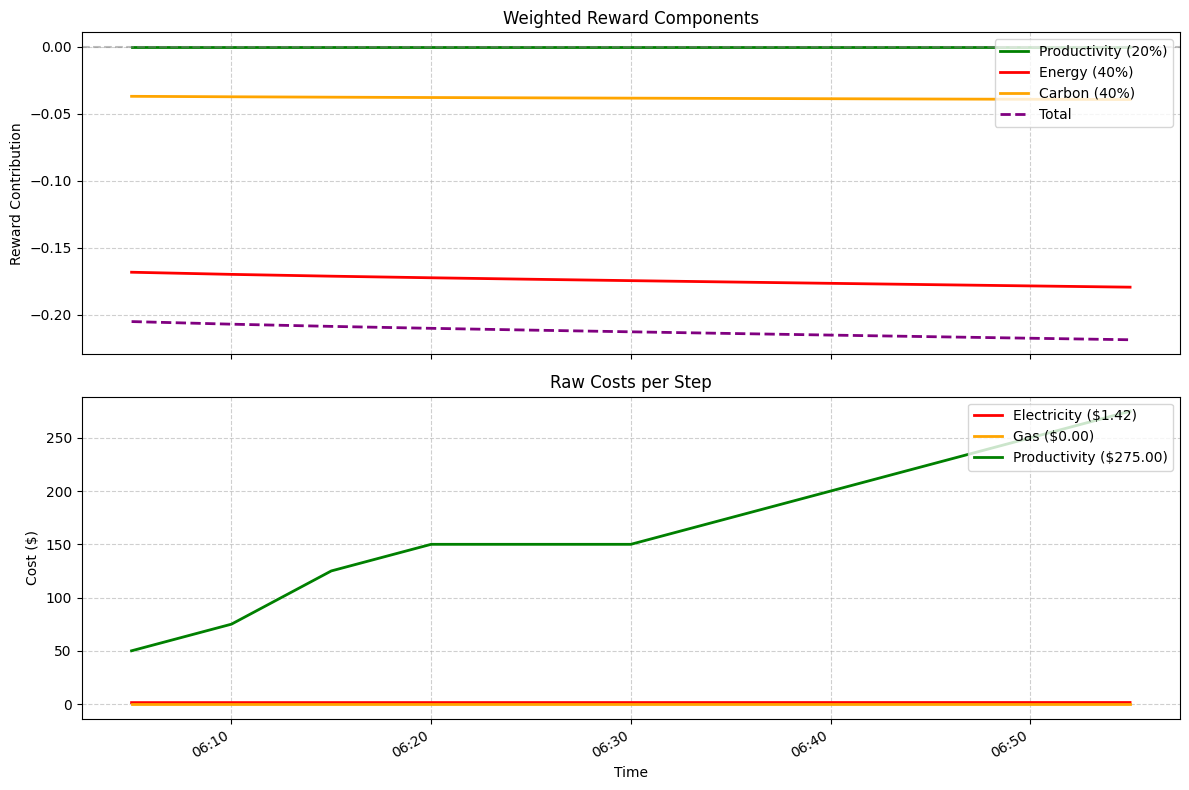

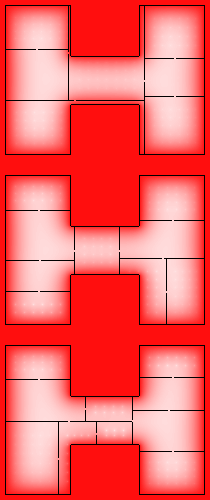

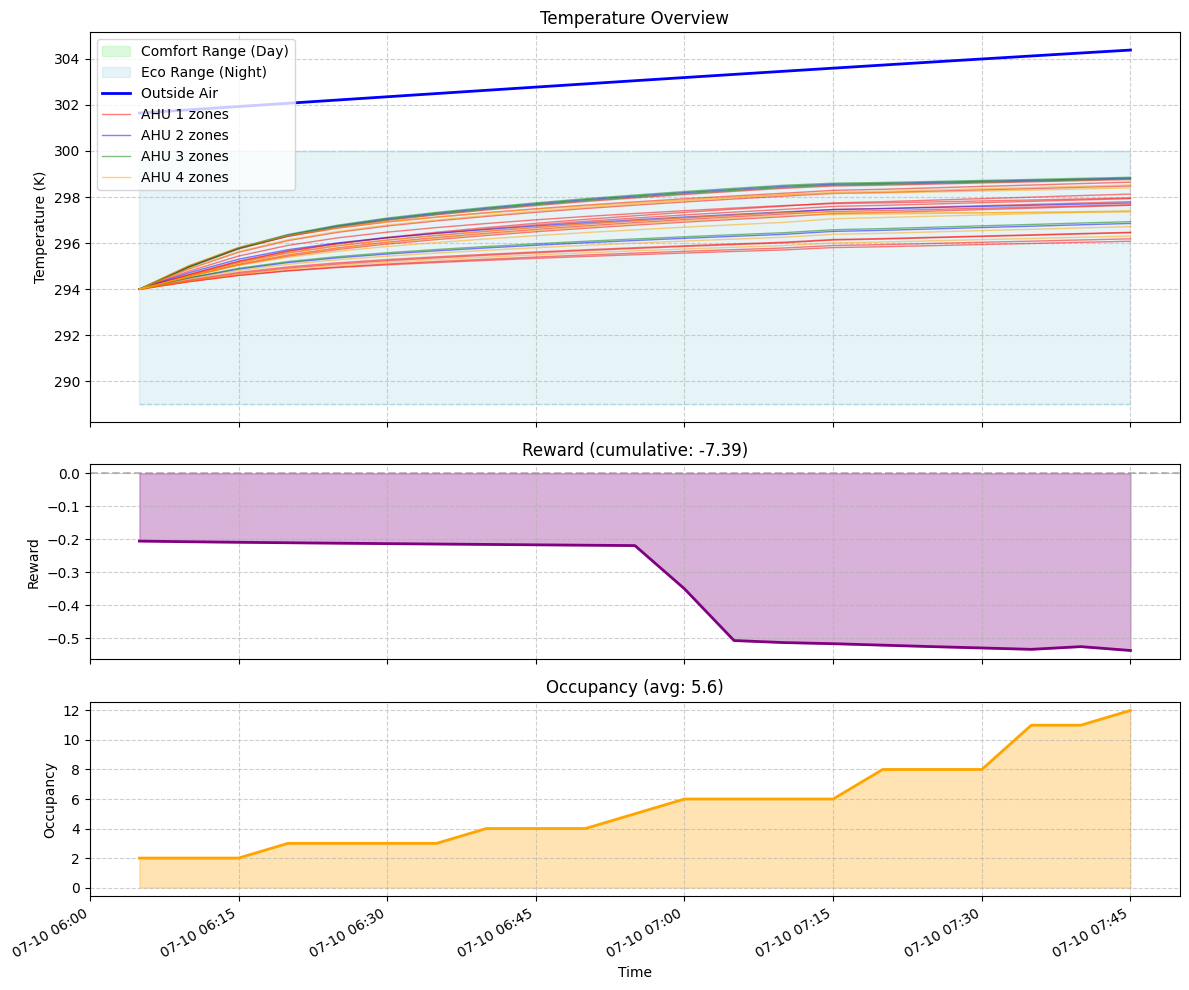

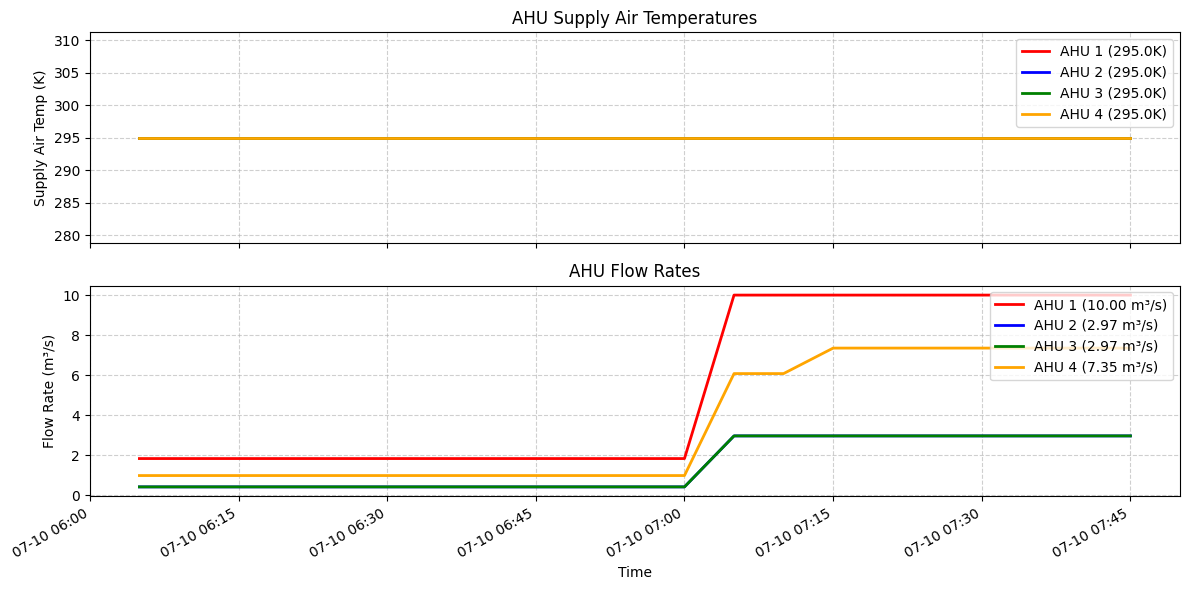

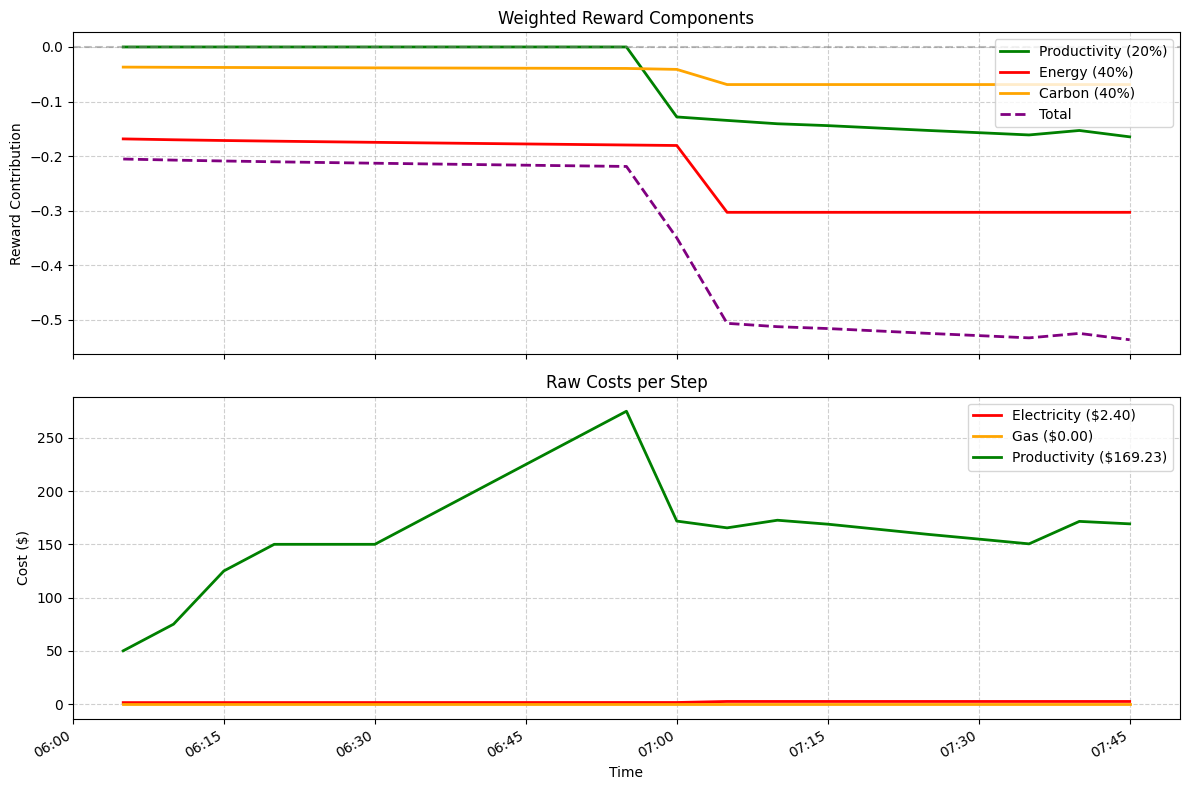

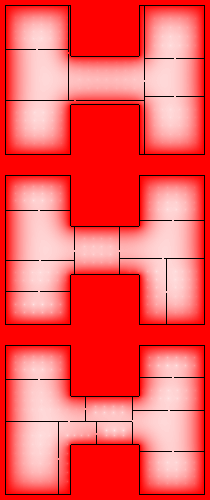

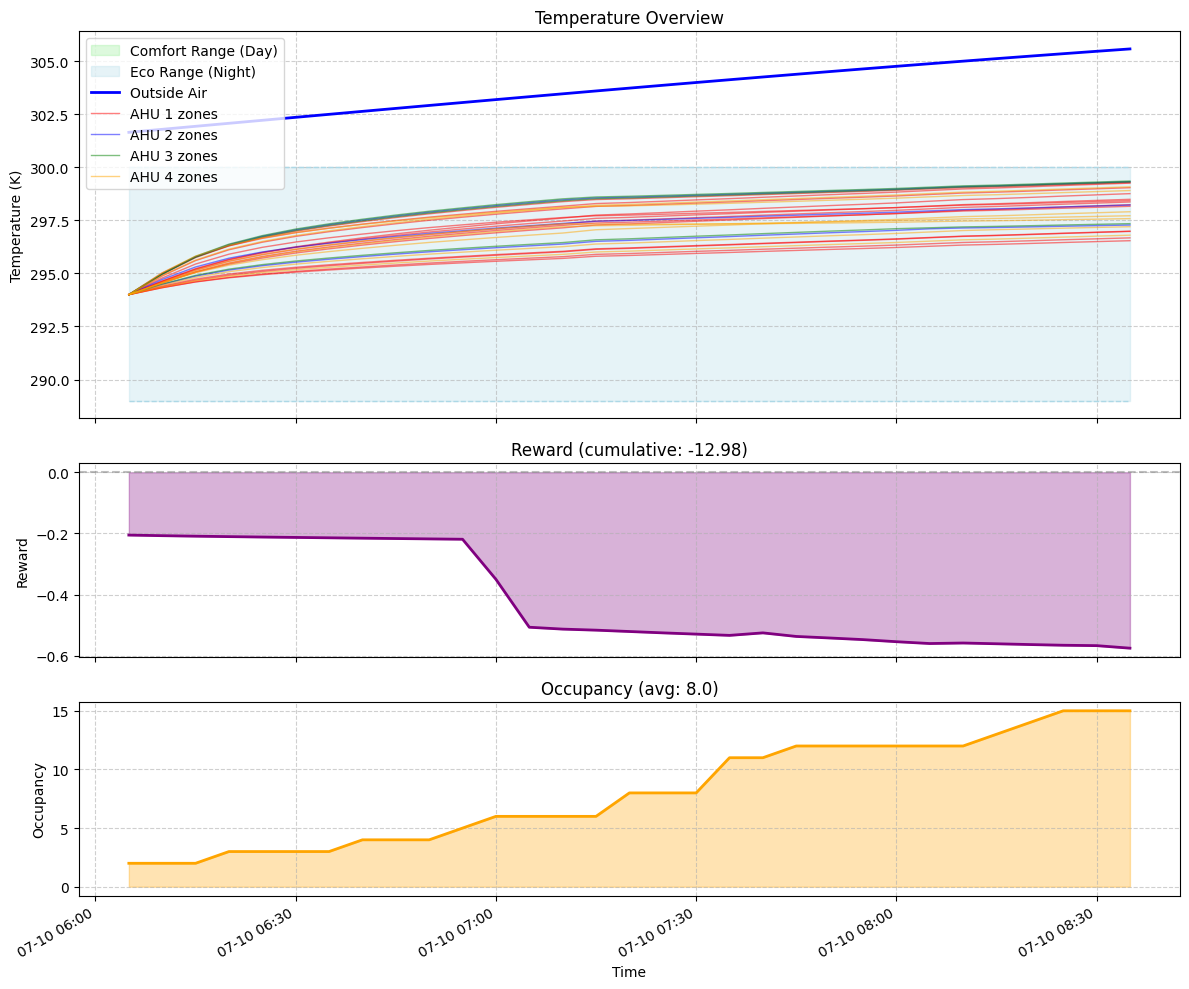

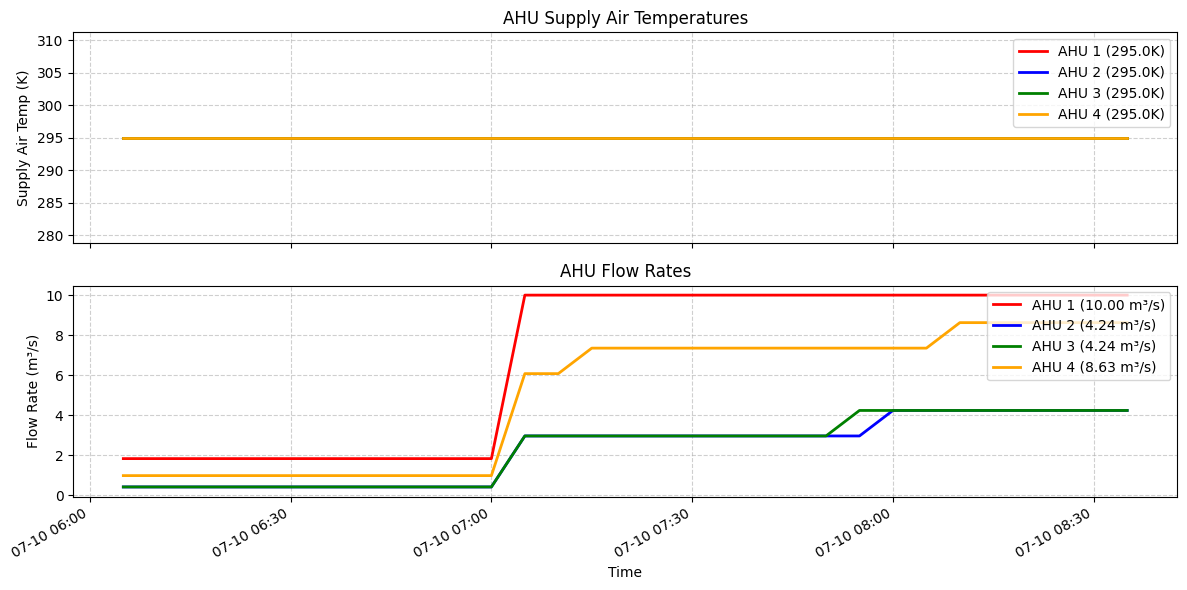

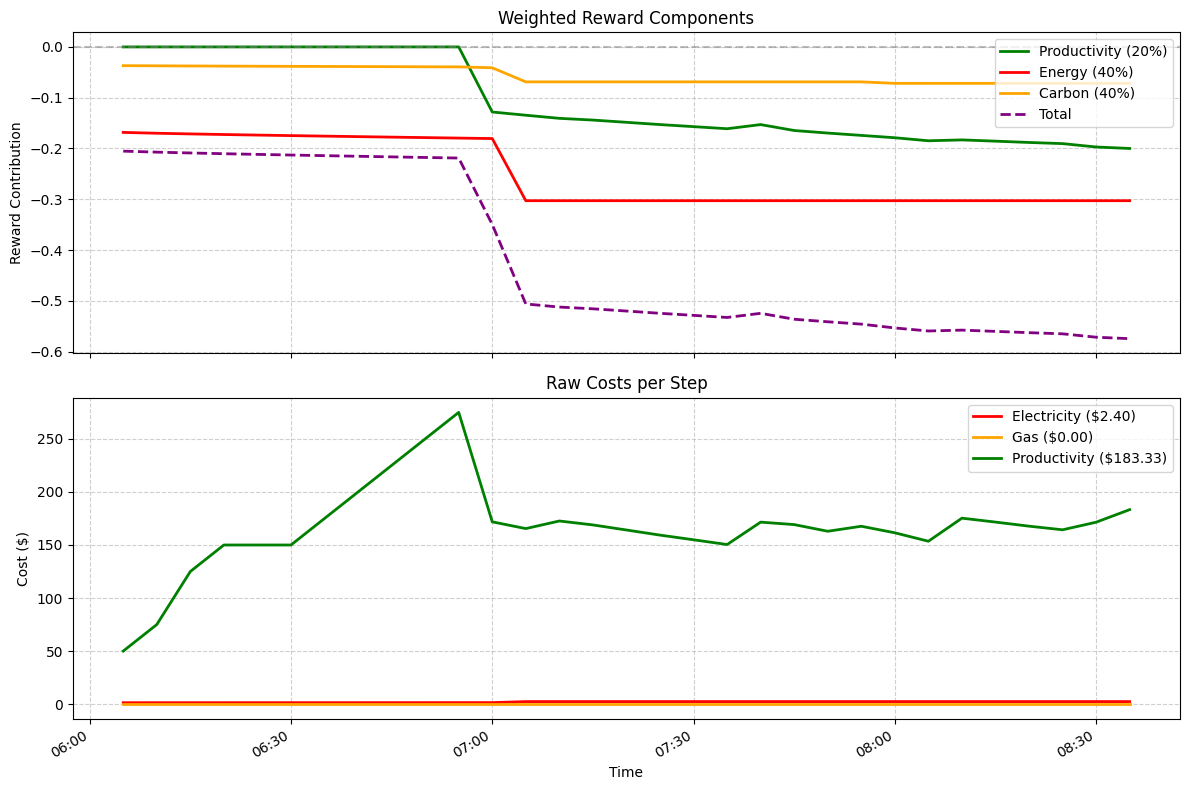

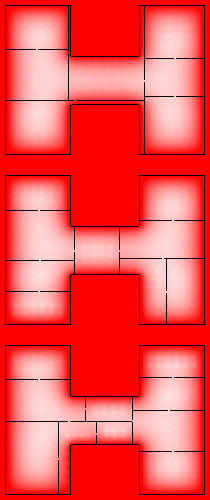

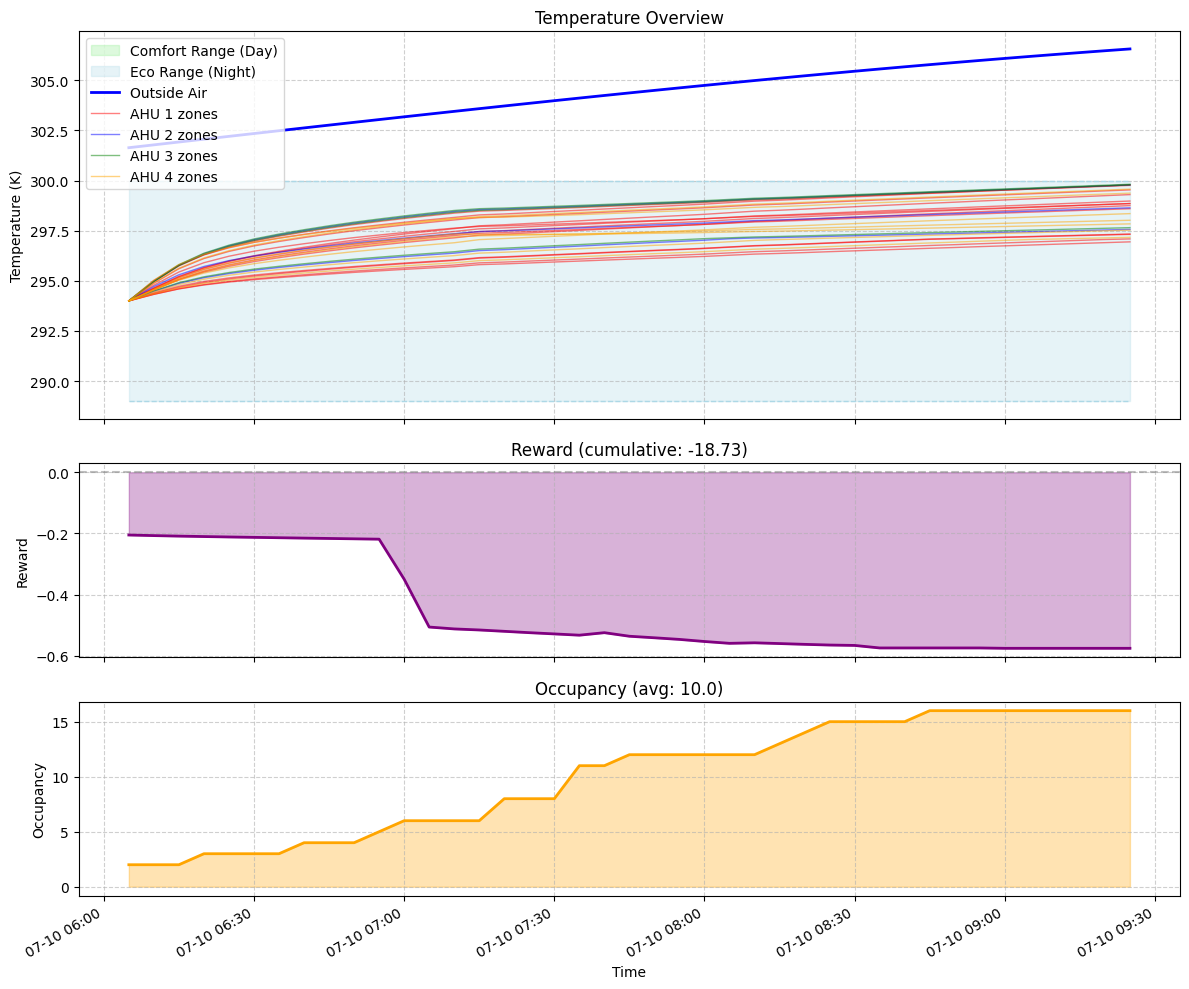

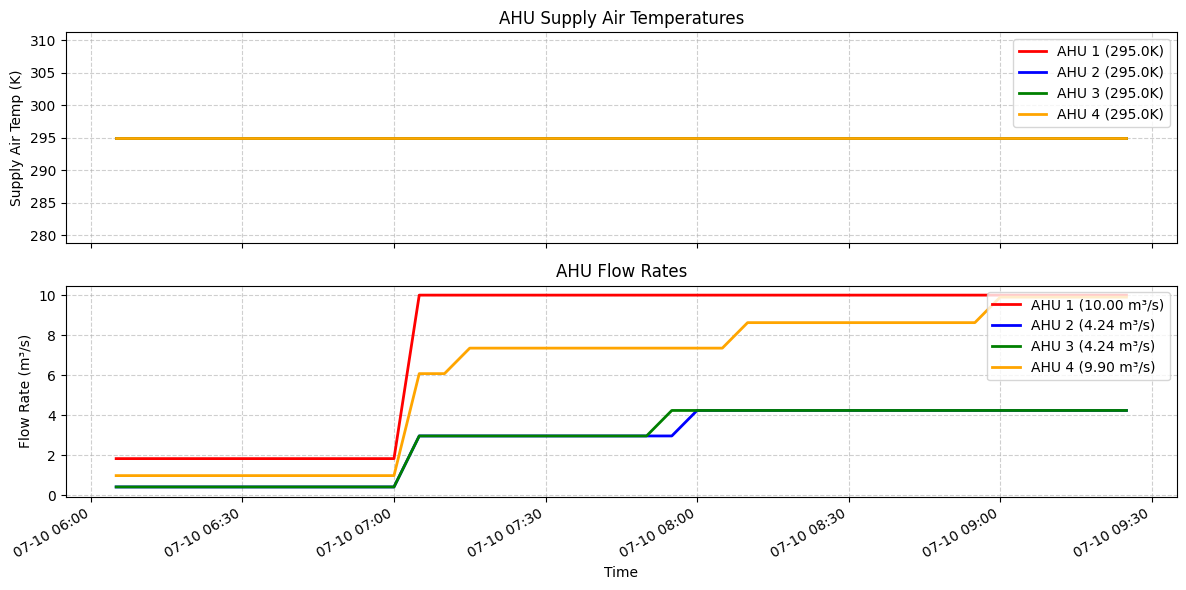

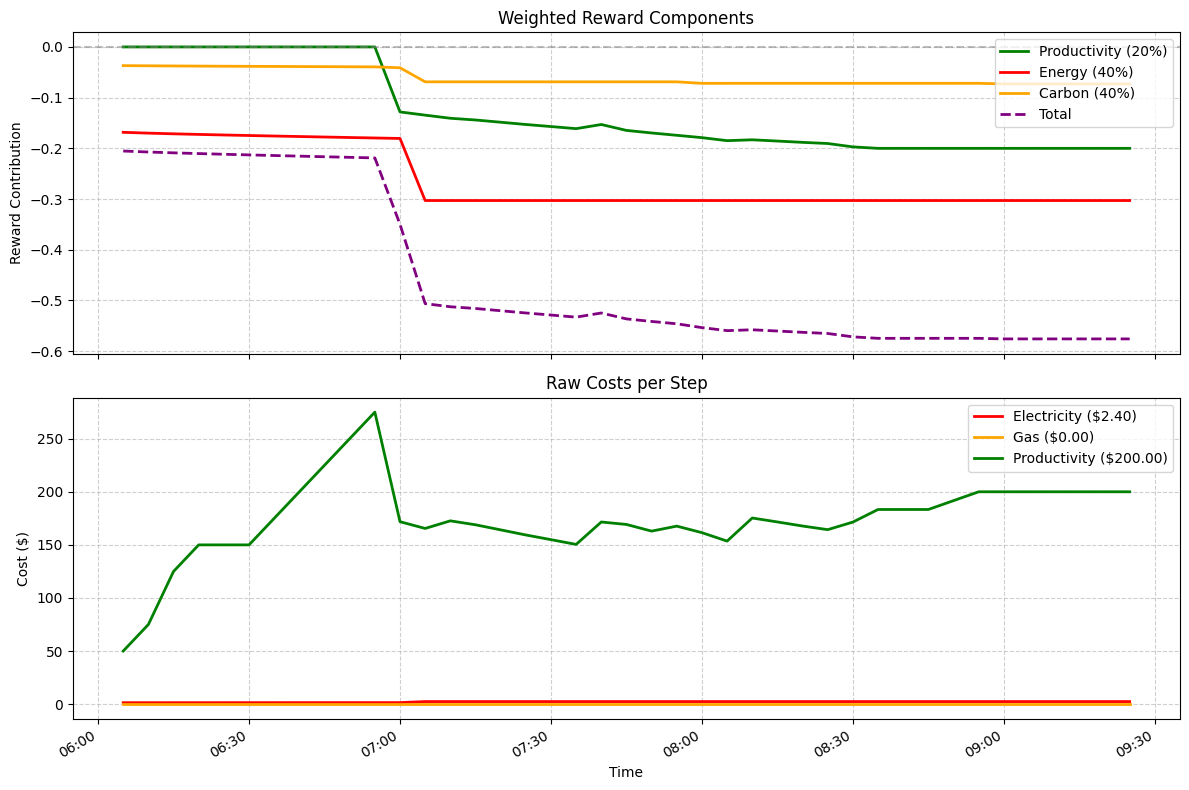

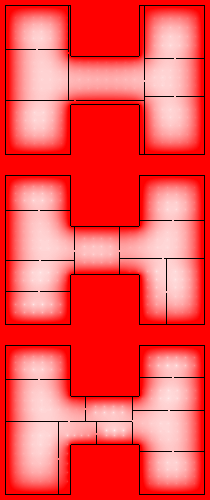

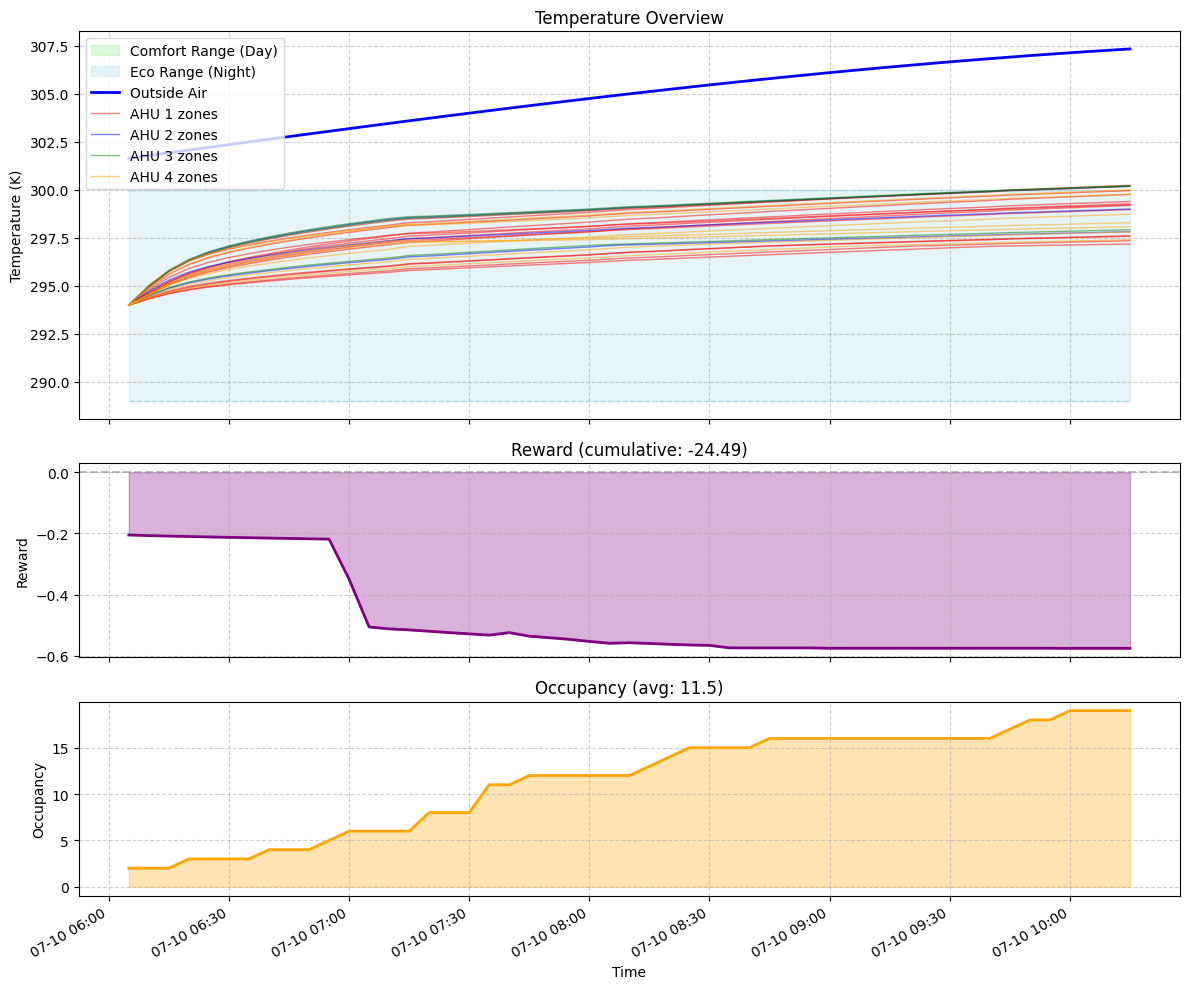

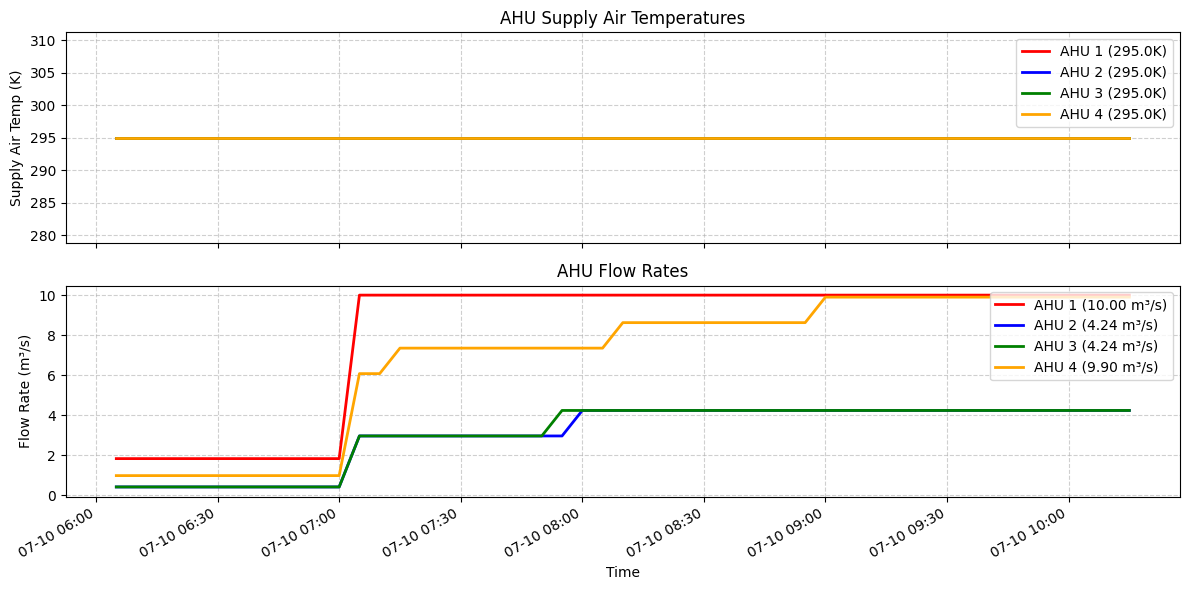

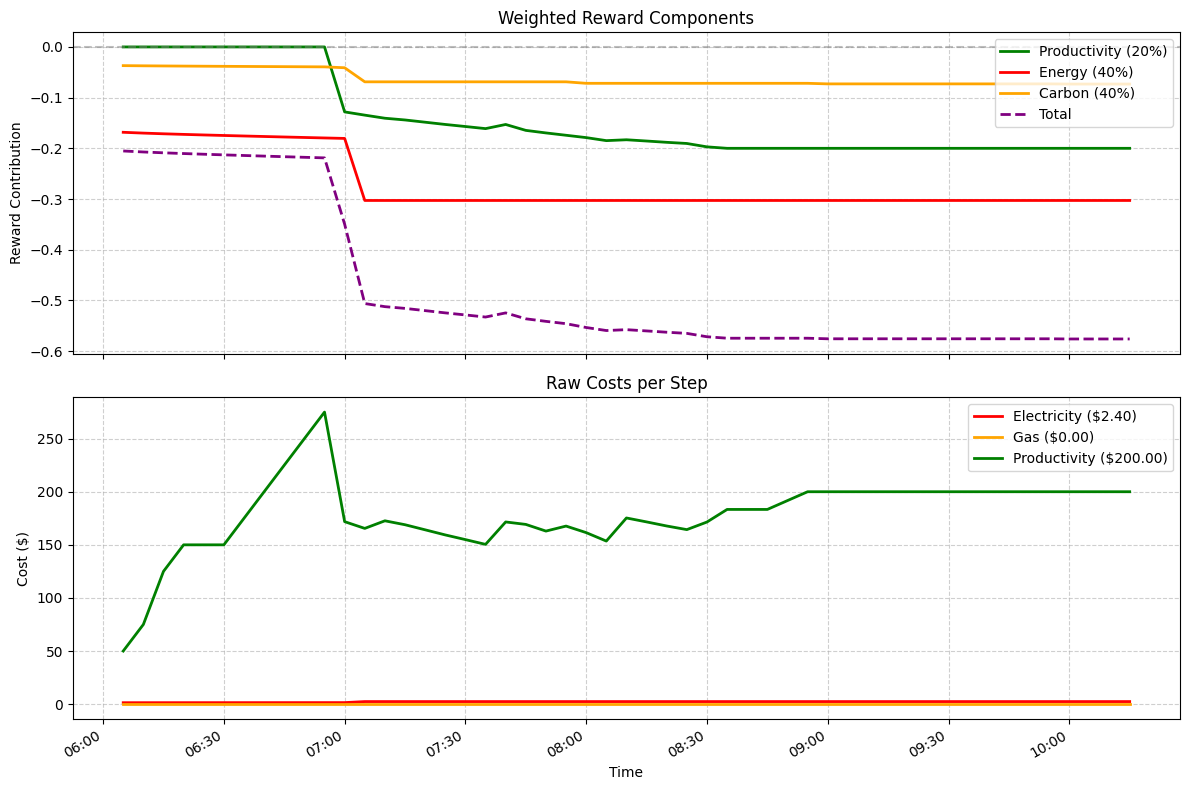

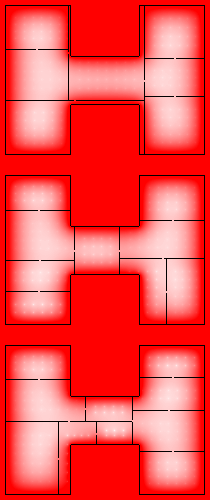

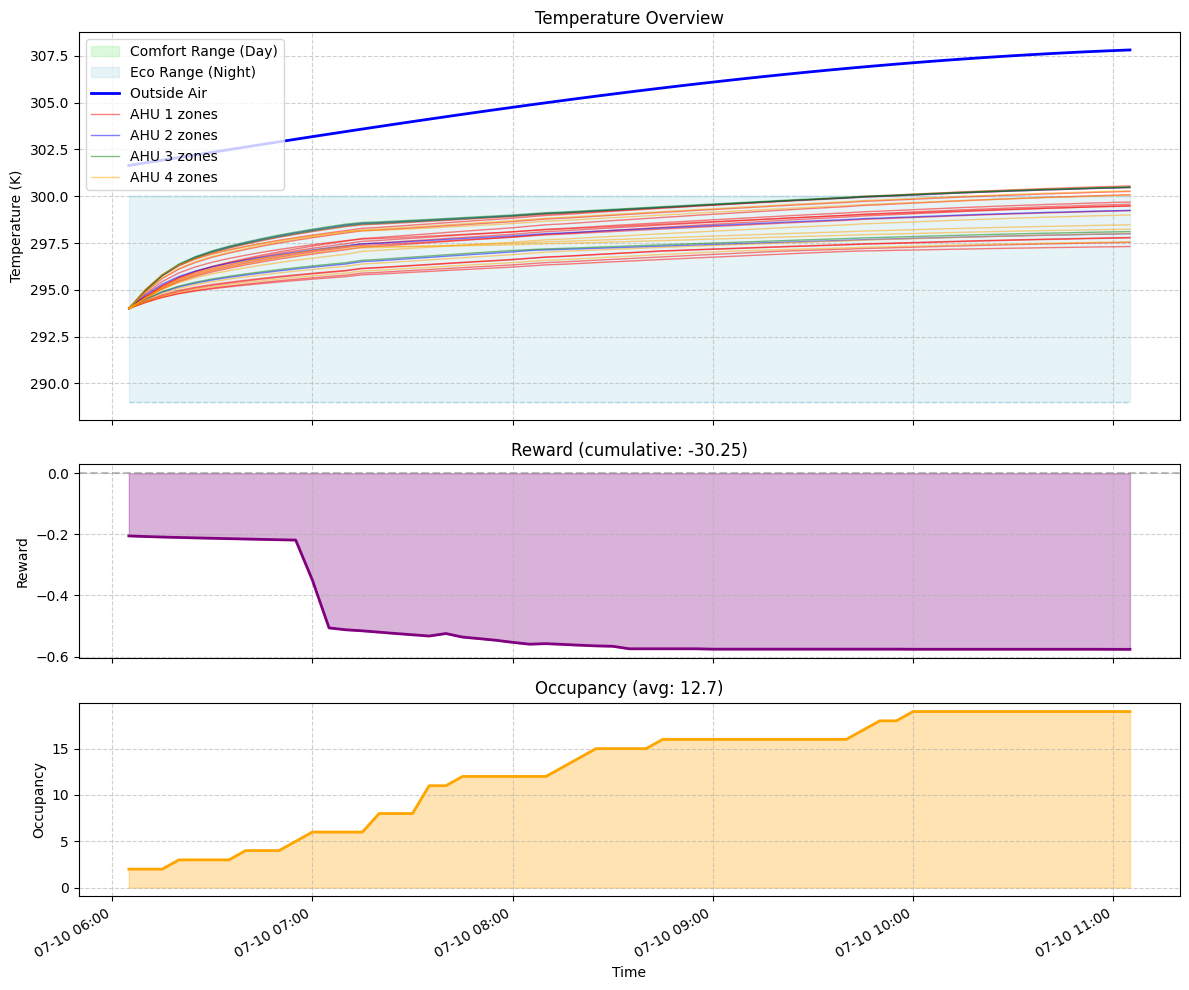

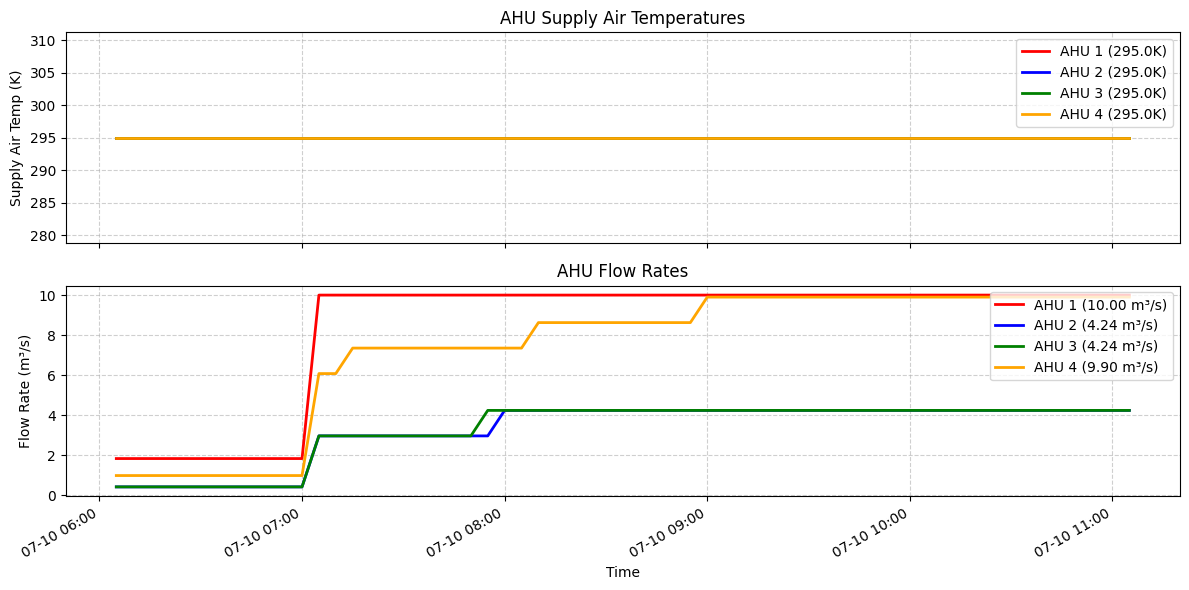

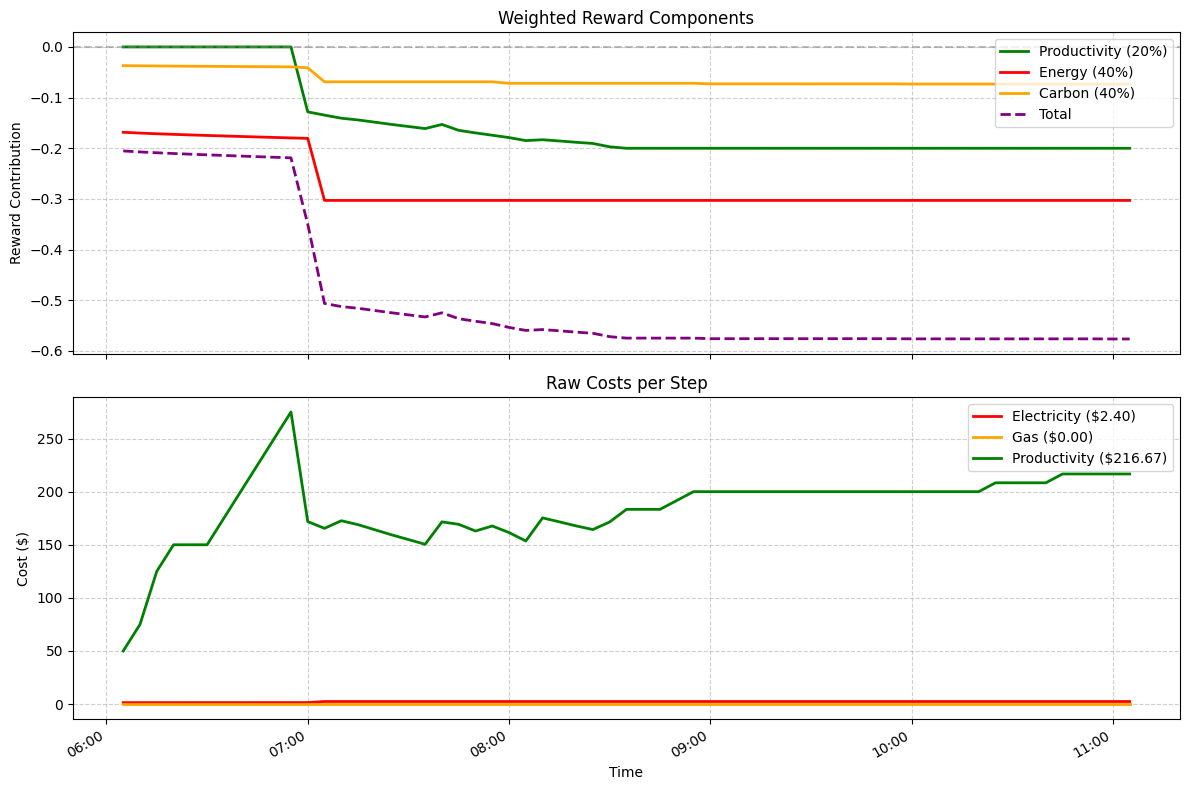

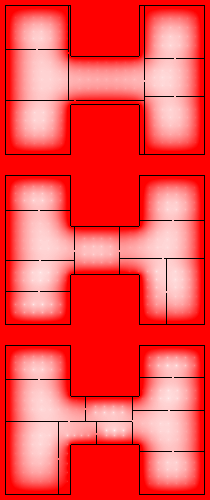

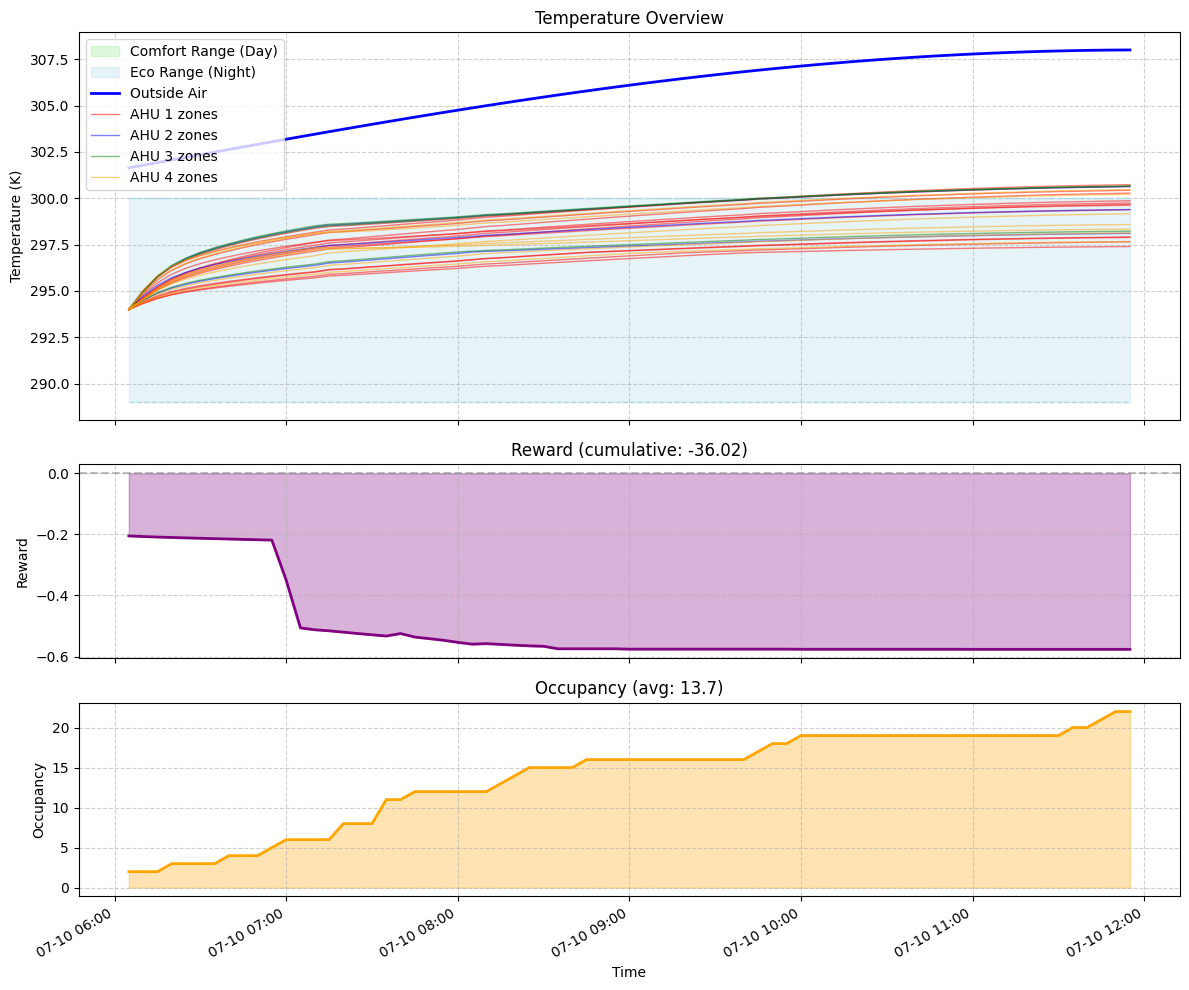

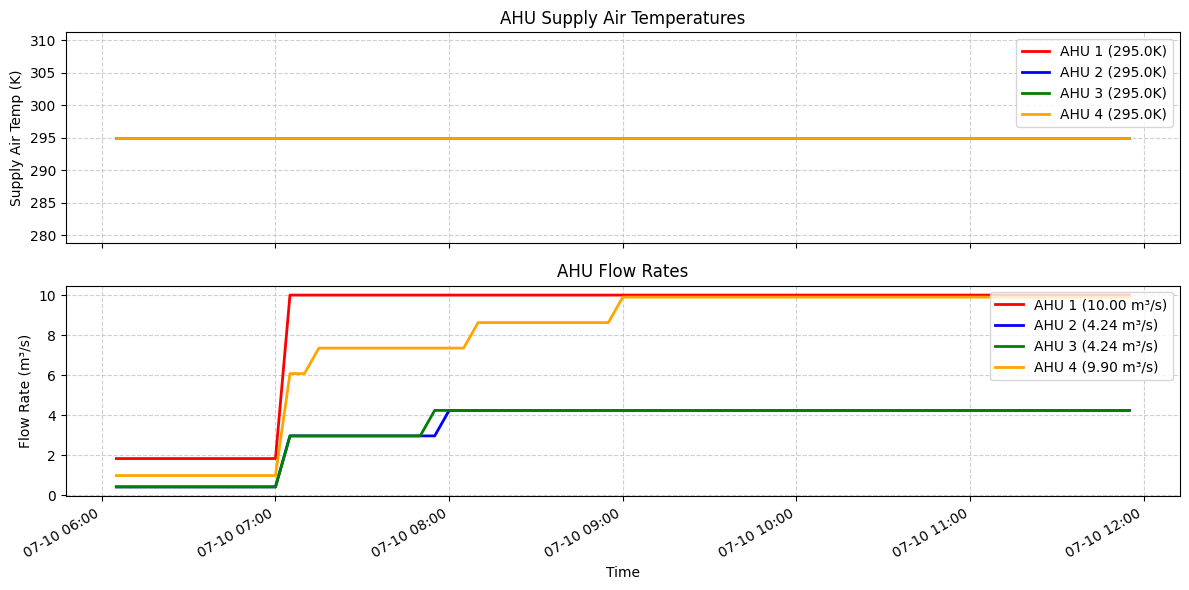

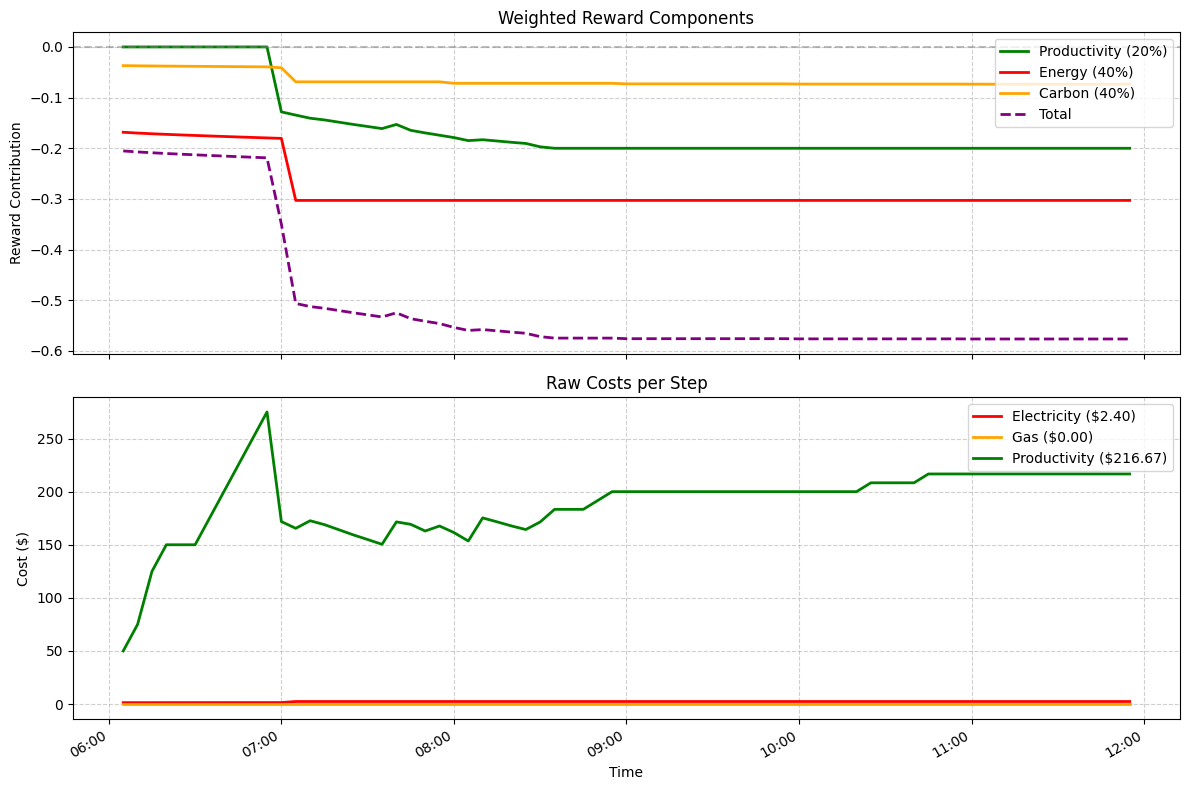

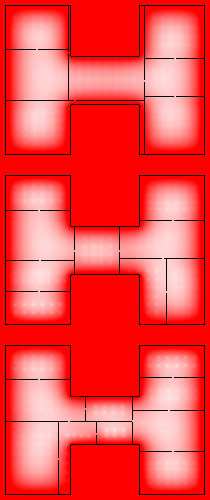

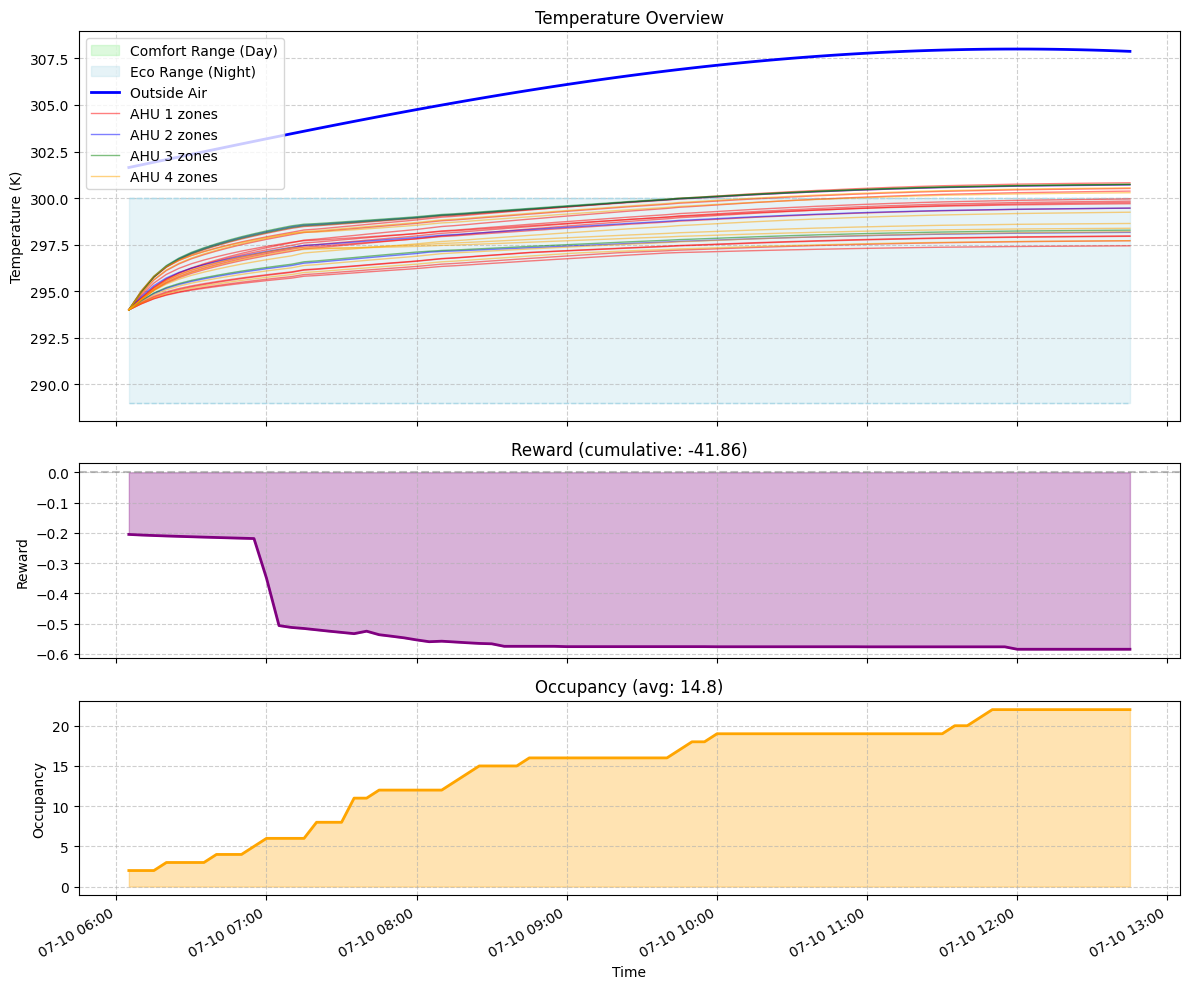

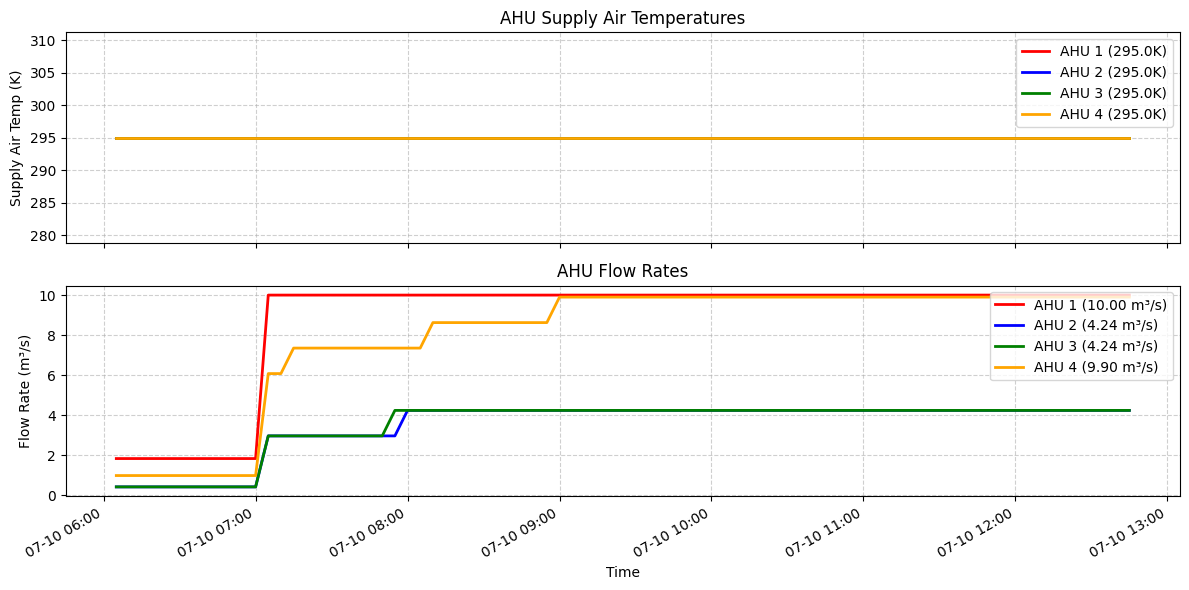

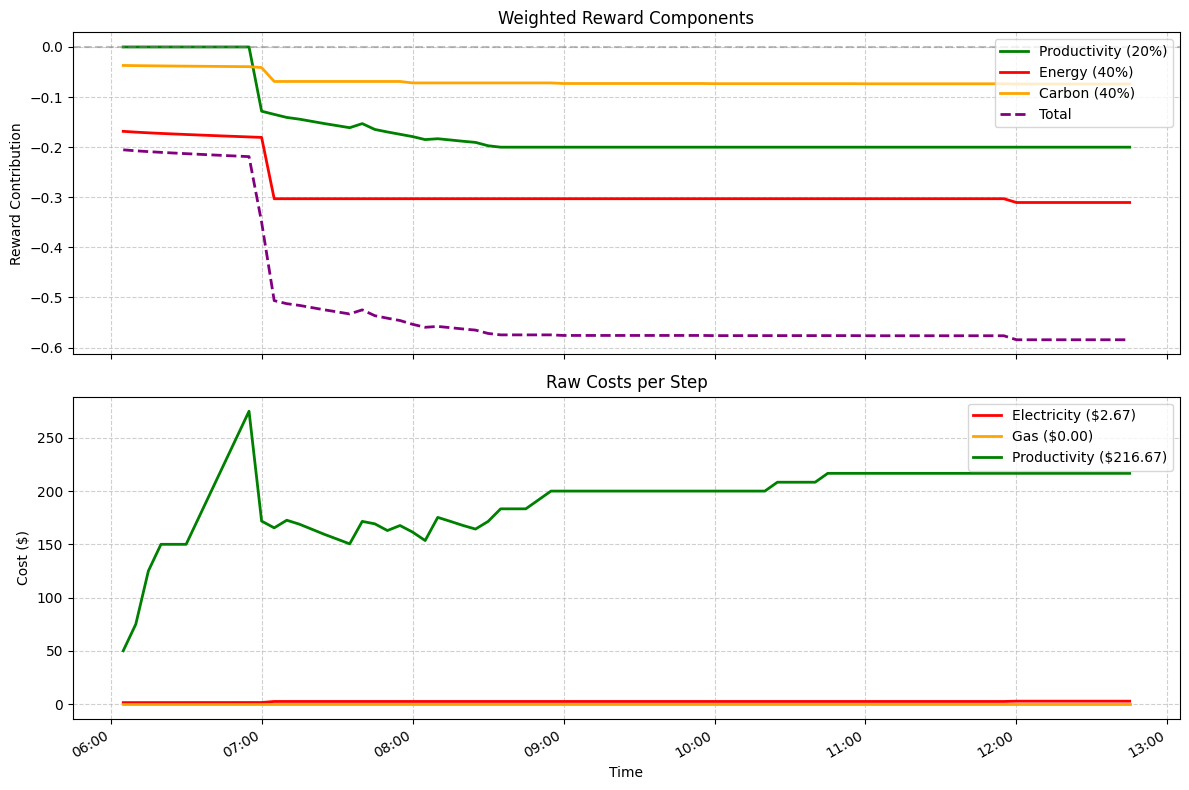

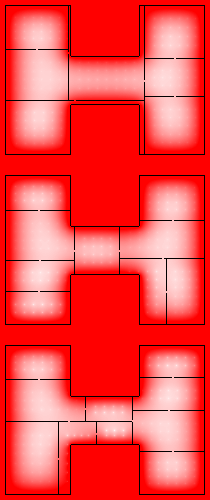

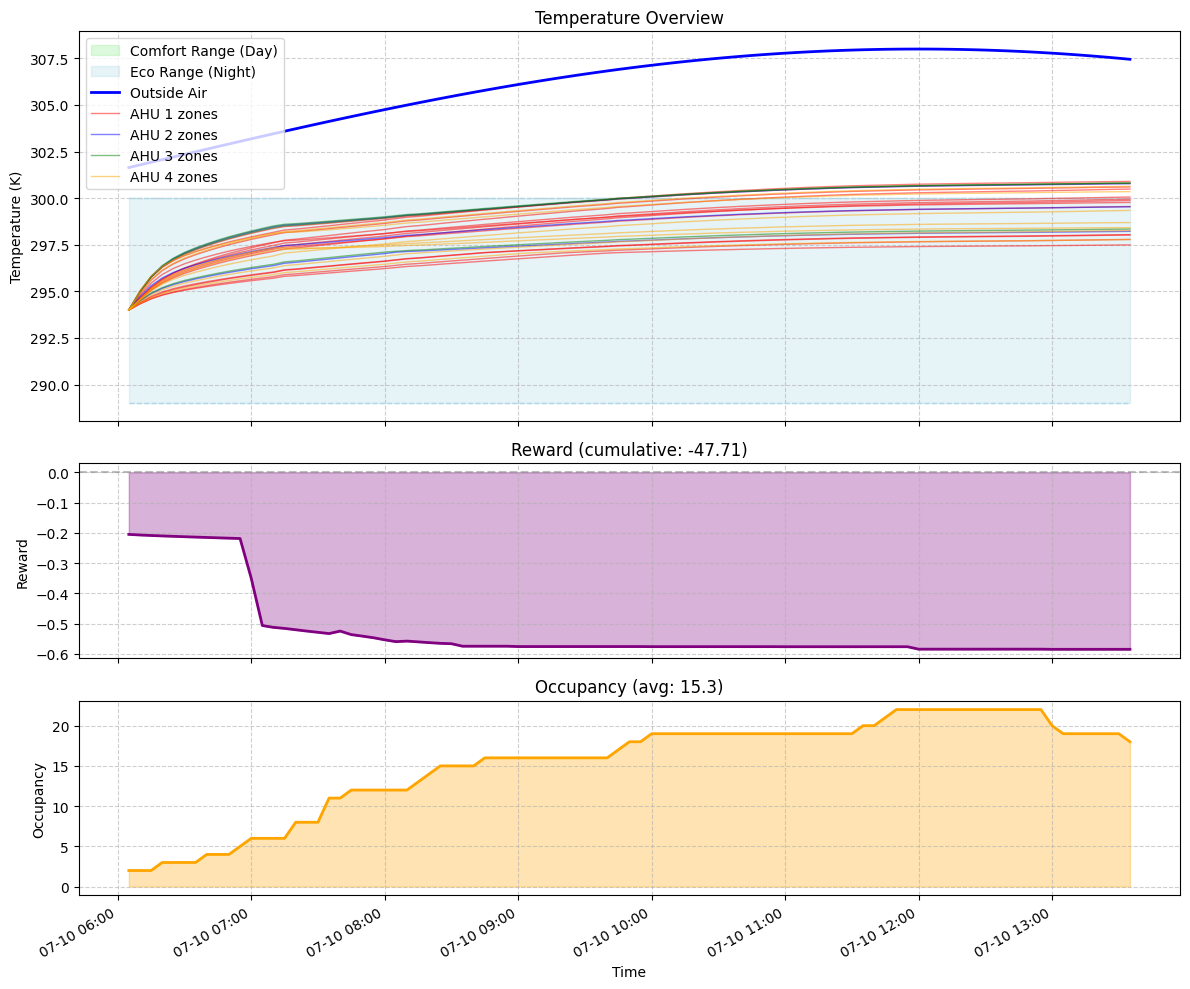

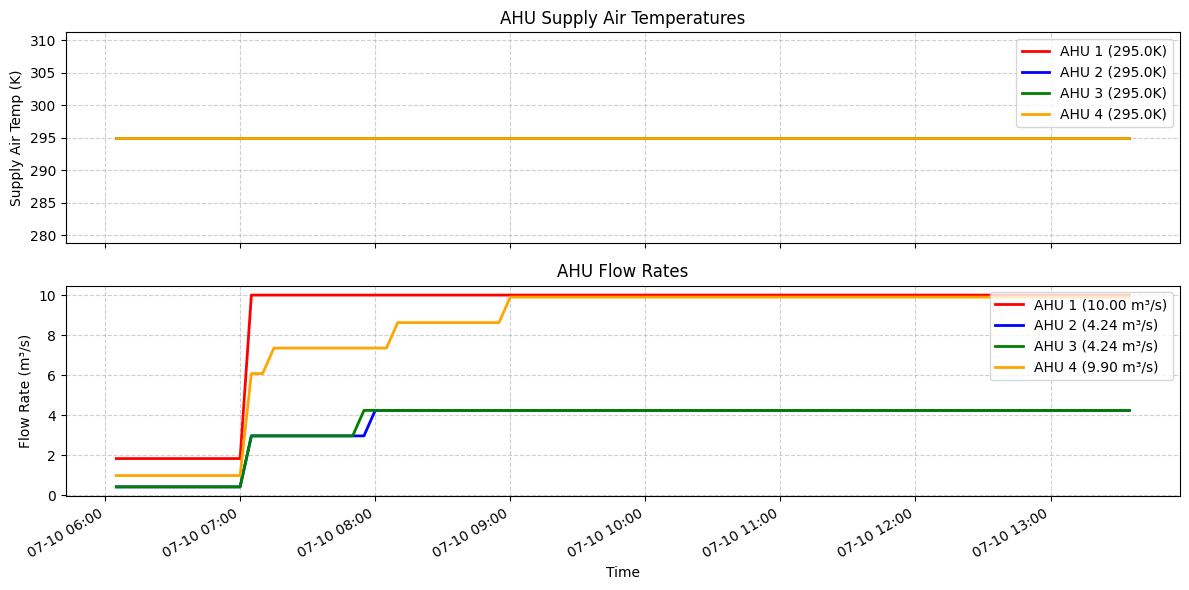

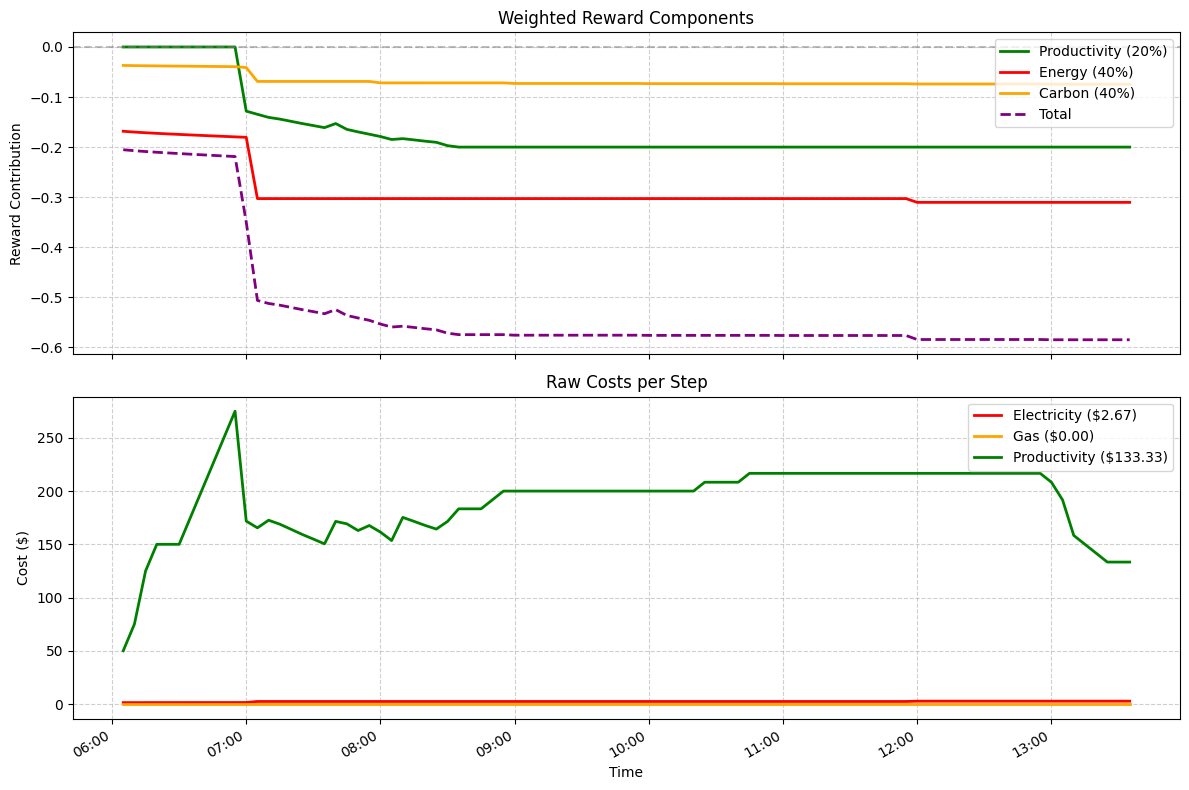

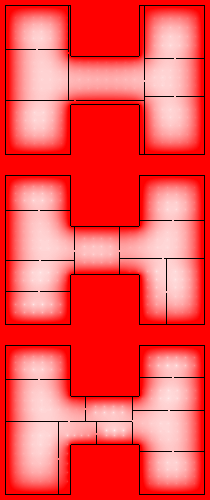

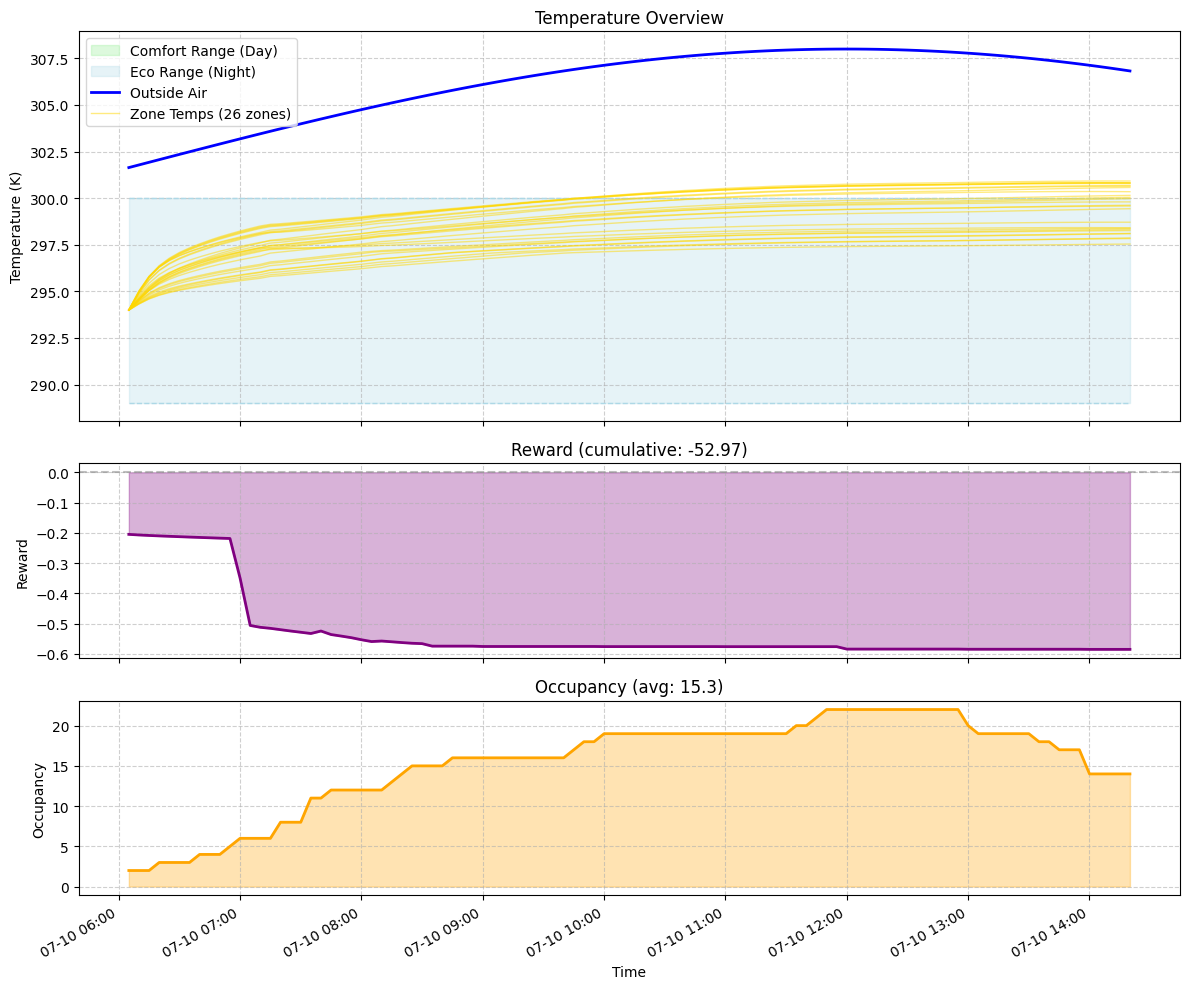

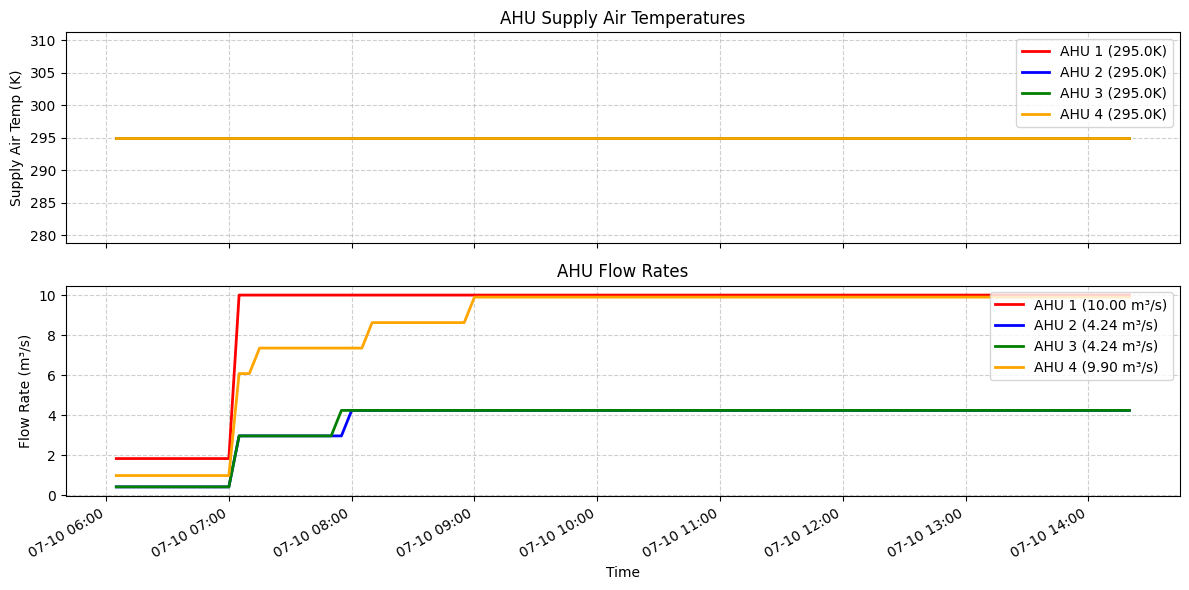

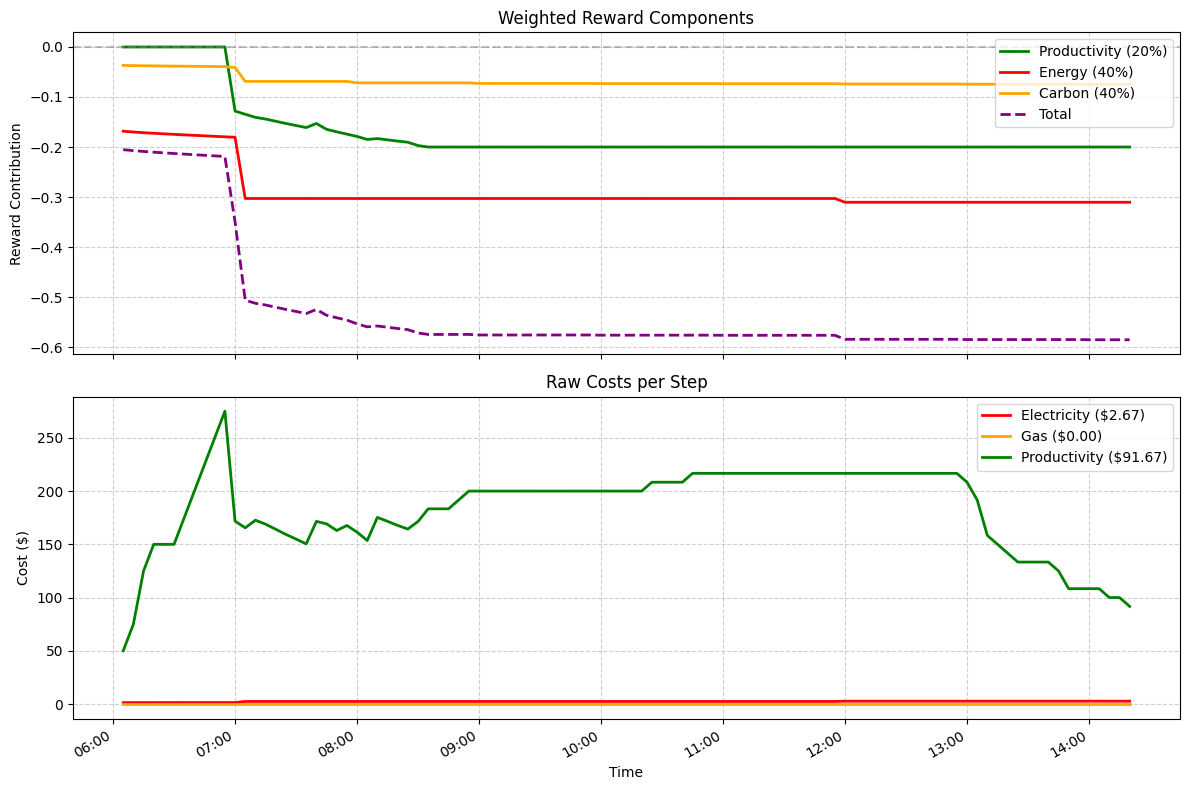


Simulation Summary (100 steps)
Cumulative Reward: -52.9727
Average Reward: -0.5297
Min/Max Reward: -0.5853 / -0.2053
Average Occupancy: 15.30
Last step costs: Elec=$2.67, Gas=$0.00, Carbon=1.39kg



In [1]:
#@title Setup
import sys
sys.path.insert(0, '/home/judah/icml/smart_buildings')
from smart_buildings.smart_control.utils.scenario_generator import generate_scenario, get_env, print_action_spec, SimulationTracker

# # Use the minimal example
# result = generate_scenario("/home/judah/icml/smart_buildings/scenarios/minimal_scenario.yaml")

# Or the full example
result = generate_scenario("/home/judah/icml/smart_buildings/scenarios/example_scenario.yaml")
print(f"Generated {result['num_rooms']} rooms with {result['num_ahus']} AHUs")

env = get_env(result)

example_action = print_action_spec(env)
tracker = SimulationTracker(env, vmin=280, vmax=305)


# Run simulation
for i in range(100):
    tracker.step(example_action)

    if i % 10 == 0:
        tracker.render()      # Show building heatmap
        tracker.plot(color_by_ahu=True)        # Show all charts

# Render specific timestep
tracker.render(step=50)

# Individual plots
tracker.plot_overview()   # Temps, rewards, occupancy
tracker.plot_ahu()        # AHU supply temps & flow rates
tracker.plot_rewards()    # Reward component breakdown

# Summary stats
tracker.summary()


=== ACTION SPEC ===

action = {
    'discrete_action': [  # shape: (5,)
        # [0] ahu_ahu_1_supervisor_run_command -> Off=0, On=1
        # [1] ahu_ahu_2_supervisor_run_command -> Off=0, On=1
        # [2] ahu_ahu_3_supervisor_run_command -> Off=0, On=1
        # [3] ahu_ahu_4_supervisor_run_command -> Off=0, On=1
        # [4] hws_supervisor_run_command -> Off=0, On=1
    ],
    'continuous_action': [  # shape: (10,)
        # [0] ahu_ahu_1_supply_air_temperature_setpoint -> [285, 305.0] K
        # [1] ahu_ahu_1_static_pressure_setpoint -> [0, 20000.0] Pa
        # [2] ahu_ahu_2_supply_air_temperature_setpoint -> [285, 305.0] K
        # [3] ahu_ahu_2_static_pressure_setpoint -> [0, 20000.0] Pa
        # [4] ahu_ahu_3_supply_air_temperature_setpoint -> [285, 305.0] K
        # [5] ahu_ahu_3_static_pressure_setpoint -> [0, 20000.0] Pa
        # [6] ahu_ahu_4_supply_air_temperature_setpoint -> [285, 305.0] K
        # [7] ahu_ahu_4_static_pressure_setpoint -> [0, 20000.0] Pa
      